# Final Project

this is the final project of data mining course for engineers, 2024.

The project is submitted by Moshe Shenhav (205812498)

## Import and style settings

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split 
from sklearn import metrics  
from sklearn.model_selection import KFold
from sklearn.tree import export_graphviz
from IPython.display import Image  
import pydotplus
import graphviz
from sklearn.model_selection import train_test_split 
from sklearn.naive_bayes import GaussianNB 
from sklearn import metrics 
from sklearn import svm
from sklearn.model_selection import KFold 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit


In [2]:
# Display Matplotlib plots inline in the notebook
%matplotlib inline  
# Time the execution of code
%timeit  


In [3]:
# settings for seaborn plotting style and size
sns.set(color_codes=True) 
sns.set(rc={'figure.figsize':(5,5)}) 
# another settings
pd.options.display.float_format = '{:.2f}'.format


## Define functions

In [4]:
def show_nunique_summary(df):
    # Create a DataFrame with the column names and their respective unique value counts
    summary_df = pd.DataFrame({
        'Variable': df.columns,
        'Unique Values': df.nunique()
    })
    summary_df = summary_df.sort_values(by='Unique Values', ascending=True)
    # Convert the DataFrame to HTML and display it
    display(HTML(summary_df.set_index('Variable').T.to_html(index=True)))
    return summary_df

def is_boolian_series(series):
    if sum(series==0) + sum(series==1) == len(series):
        print(col, "had changed to boolian")
        return series.astype(bool)
    else:
        # print(col, "is not boolian")
        return series


In [5]:
def check_row_equality(df, index, colname):

    # Get the row to compare against, excluding the specified column
    row_values = df.drop(columns=[colname]).loc[index]
    mask = df.drop(columns=[colname]).eq(row_values).all(axis=1)
    # Exclude the row at the given index from the comparison
    mask.loc[index] = False
    
    return np.where(mask)


## Get a first impression from the data

 <span style="font-size:20px; color:black; font-weight:bold"> Read the data and give simple views to understand the variables and their types</span>


### Data shape and attribute types

In [6]:
# read data
raw_hotel_df = pd.read_csv("hotels_train.csv")

# show frame of data
(n_reservations, n_attributes)=raw_hotel_df.shape
print('')
display(HTML(f'<span style="font-size:18px; color:blue; font-weight:bold;">The frame of data:'))
display(HTML(f'<span style="font-size:25px; color:#7F1734; font-weight:bold;">Num of reservations: {n_reservations}</span>'))
display(HTML(f'<span style="font-size:25px; color:#7F1734; font-weight:bold;">Num of attributes: {n_attributes}</span>'))
print('')

# show example of data
display(HTML(f'<span style="font-size:18px; color:blue; font-weight:bold;">And this is what the data looks like:'))
raw_hotel_df.head()


ID  weekend_nights  week_nights    room_type  board_type  n_adults  \
0  INN09588               1            5  Room_Type 1  half board         2   
1  INN07691               0            3  Room_Type 1         NaN         2   
2  INN32192               0            2  Room_Type 4  half board         1   
3  INN32218               1            2  Room_Type 1         NaN         2   
4  INN02994               1            3  Room_Type 4  half board         2   

   n_less_12  n_more_12  booked_tour  n_requests  lead_time purchase_type  \
0          0          0            0           2      34.00        Online   
1          0          0            0           0     365.00           NaN   
2          0          0            0           1     148.00        Online   
3          0          0            0           0     502.00       Offline   
4          0          1            0           2      32.00       Offline   

   n_p_cacellation  n_p_not_cacellation  repeated  price        date  \
0                0                    0         0 108.40  11/28/2018   
1                0                    0         0    NaN  11/03/2018   
2                0                    0         0 137.30  05/06/2018   
3                0                    0         0 127.00   9/26/2018   
4                0                    0         0 110.00  10/19/2017   

   is_canceled  
0            0  
1            1  
2            0  
3            1  
4            0

In [7]:
raw_hotel_df.info()
print(type(raw_hotel_df['price'][0]))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27213 entries, 0 to 27212
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   27213 non-null  object 
 1   weekend_nights       27213 non-null  int64  
 2   week_nights          27213 non-null  int64  
 3   room_type            27213 non-null  object 
 4   board_type           19045 non-null  object 
 5   n_adults             27213 non-null  int64  
 6   n_less_12            27213 non-null  int64  
 7   n_more_12            27213 non-null  int64  
 8   booked_tour          27213 non-null  int64  
 9   n_requests           27213 non-null  int64  
 10  lead_time            26794 non-null  float64
 11  purchase_type        22366 non-null  object 
 12  n_p_cacellation      27213 non-null  int64  
 13  n_p_not_cacellation  27213 non-null  int64  
 14  repeated             27213 non-null  int64  
 15  price                23808 non-null 

Most of variables are defined for all reservations. 
the following variables are not defined for all: "board_type", "lead_time", "purchase_type", "price".

Already at first glance, one can guess that some of the features are presented as numeric, but it is also appropriate to present them as an object.
In addition, we note that there is some variables typed as int, but it seems that they are really boolean: "booked_tour", "repeated", "is_canceled".

Beyond that, there are variables that are similar to each other and it is interesting to analyze their sum as a separate variableץ

The following code will change what realy boolian to 'bool' type, sum same variables and display the num of unique values in each attribute



In [8]:
hotel_df=raw_hotel_df    # we will do all changes on 'hotel_df' 
for col in hotel_df:
    hotel_df[col]=is_boolian_series(hotel_df[col])

# sum num of children and num of pearsons 
hotel_df['n_children'] = hotel_df['n_more_12']+hotel_df['n_less_12']
hotel_df['n_persons'] = hotel_df['n_adults']+hotel_df['n_children']

# sum total nights
hotel_df['total_nights'] = hotel_df['week_nights']+hotel_df['weekend_nights']

print('\n')
display(HTML(f'<span style="font-size:15px; color:black; font-weight:bold;">The number of unique values for each attribute:'))
nunique_df = show_nunique_summary(hotel_df)
print('')


booked_tour had changed to boolian
repeated had changed to boolian
is_canceled had changed to boolian




**Now we can notice:**
- The number of unique values of IDs is equal to its counts, as we would expect.
- In some numeric variables there are few unique vlaues. Those, they can be viewed as both numerical and categorical.

  

### Atrributes statistics

#### Split to categorical and numerical attributes

In [9]:
numeric_col = hotel_df.describe().columns # to get the numeric column
numerical_hotel_data = hotel_df[numeric_col]
categorical_hotel_data = hotel_df.drop(numeric_col, axis=1)

display(HTML(f'<span style="font-size:15px; color:black; font-weight:bold;">Some statistics of categorical attributes:'))
categorical_hotel_data.describe(include="all")


ID    room_type  board_type booked_tour purchase_type repeated  \
count      27213        27213       19045       27213         22366    27213   
unique     27213            7           4           2             5        2   
top     INN09588  Room_Type 1  half board       False        Online    False   
freq           1        21084       14591       26349         14306    26494   

              date is_canceled  
count        27213       27213  
unique         553           2  
top     10/13/2018       False  
freq           188       18296

In [10]:
display(HTML(f'<span style="font-size:15px; color:black; font-weight:bold;">Some statistics of numerical attributes:'))
numerical_hotel_data.describe(include="all")


weekend_nights  week_nights  n_adults  n_less_12  n_more_12  \
count        27213.00     27213.00  27213.00   27213.00   27213.00   
mean             0.81         2.20      1.85       0.05       0.05   
std              0.87         1.40      0.52       0.27       0.27   
min              0.00         0.00      0.00       0.00       0.00   
25%              0.00         1.00      2.00       0.00       0.00   
50%              1.00         2.00      2.00       0.00       0.00   
75%              2.00         3.00      2.00       0.00       0.00   
max              7.00        17.00      4.00       6.00       4.00   

       n_requests  lead_time  n_p_cacellation  n_p_not_cacellation    price  \
count    27213.00   26794.00         27213.00             27213.00 23808.00   
mean         0.62     102.95             0.02                 0.16   123.46   
std          0.79     103.50             0.35                 1.73    35.14   
min          0.00       0.00             0.00                 0.00    20.00   
25%          0.00      21.00             0.00                 0.00   100.30   
50%          0.00      69.00             0.00                 0.00   119.45   
75%          1.00     153.00             0.00                 0.00   140.00   
max          5.00     532.00            13.00                57.00   560.00   

       n_children  n_persons  total_nights  
count    27213.00   27213.00      27213.00  
mean         0.11       1.95          3.01  
std          0.40       0.65          1.77  
min          0.00       1.00          0.00  
25%          0.00       2.00          2.00  
50%          0.00       2.00          3.00  
75%          0.00       2.00          4.00  
max         10.00      12.00         24.00

#### Pie charts for atrributes up to 8 unique values

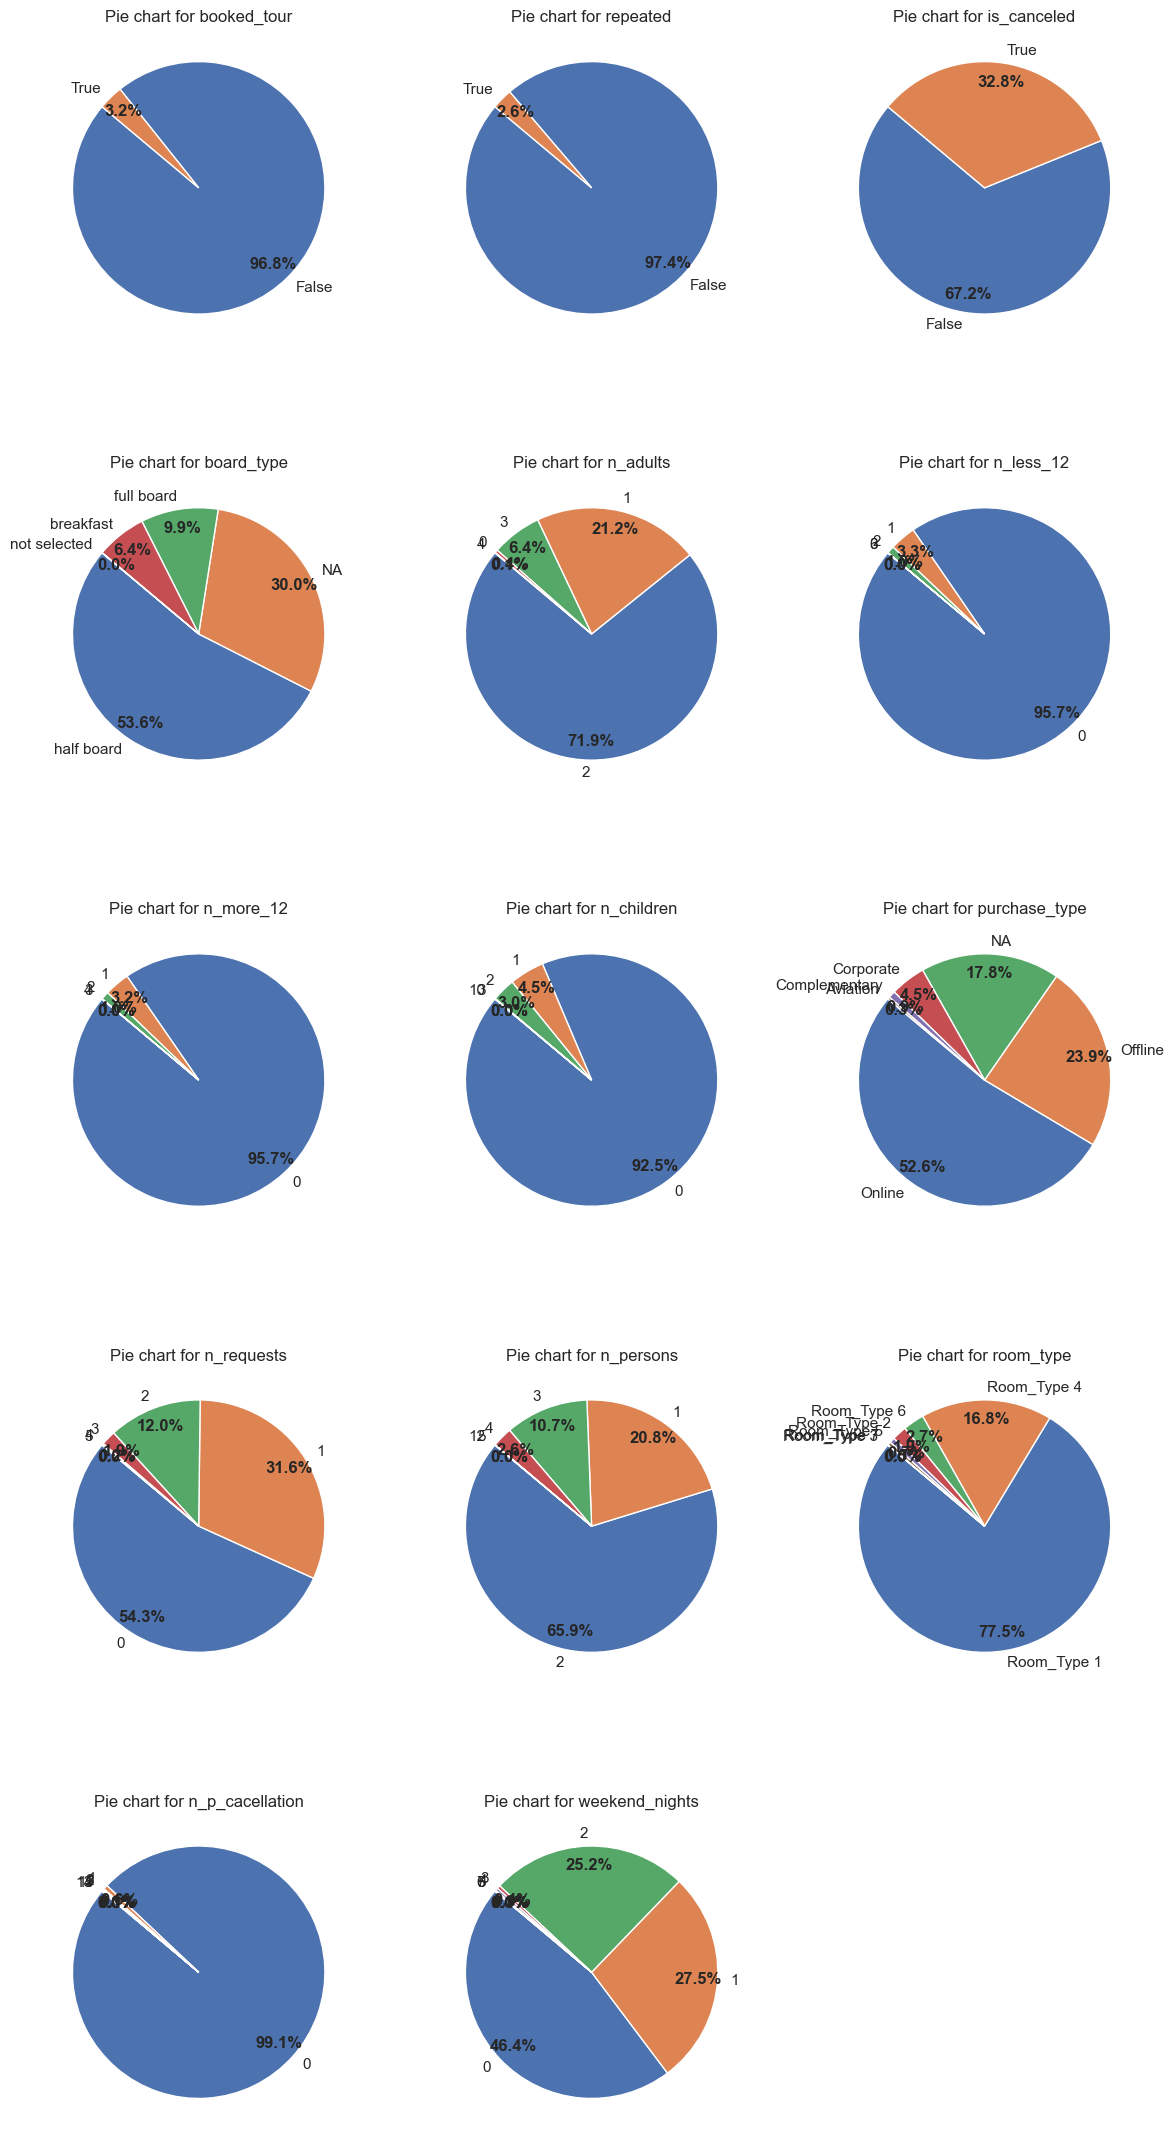

In [11]:
def plot_pie_charts_in_subplots(df):
    num_columns = df.shape[1]
    num_rows = (num_columns + 1) // 2  # Determine the number of rows needed
    
    fig, axs = plt.subplots(num_rows, 3, figsize=(12, 4.5 * num_rows))  # Create subplots
    axs = axs.flatten()  # Flatten the axes array for easy indexing
    
    for i, column in enumerate(df.columns):
        df = df.fillna('NA') # fill NA values to see it on the charts
        counts = df[column].value_counts()
        wedges, texts, autotexts = axs[i].pie(counts, labels=counts.index, autopct='%1.1f%%',pctdistance=0.85, labeldistance=1.1, startangle=140)
        axs[i].set_title(f'Pie chart for {column}')
        for autotext in autotexts:
            autotext.set_fontweight('bold')
    # Hide any unused subplots
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])
    
    plt.tight_layout()
    plt.show()

upto8_unique_vals = nunique_df[nunique_df['Unique Values']<=8]
hotel_df[upto8_unique_vals['Variable']].head()
plot_pie_charts_in_subplots(hotel_df[upto8_unique_vals['Variable']])

#### Show histograms of numerical atrributes

For numerical data we would like to know the range of values, whether there are outliers, the distribution and other statistics, though first we will draw the histograms.

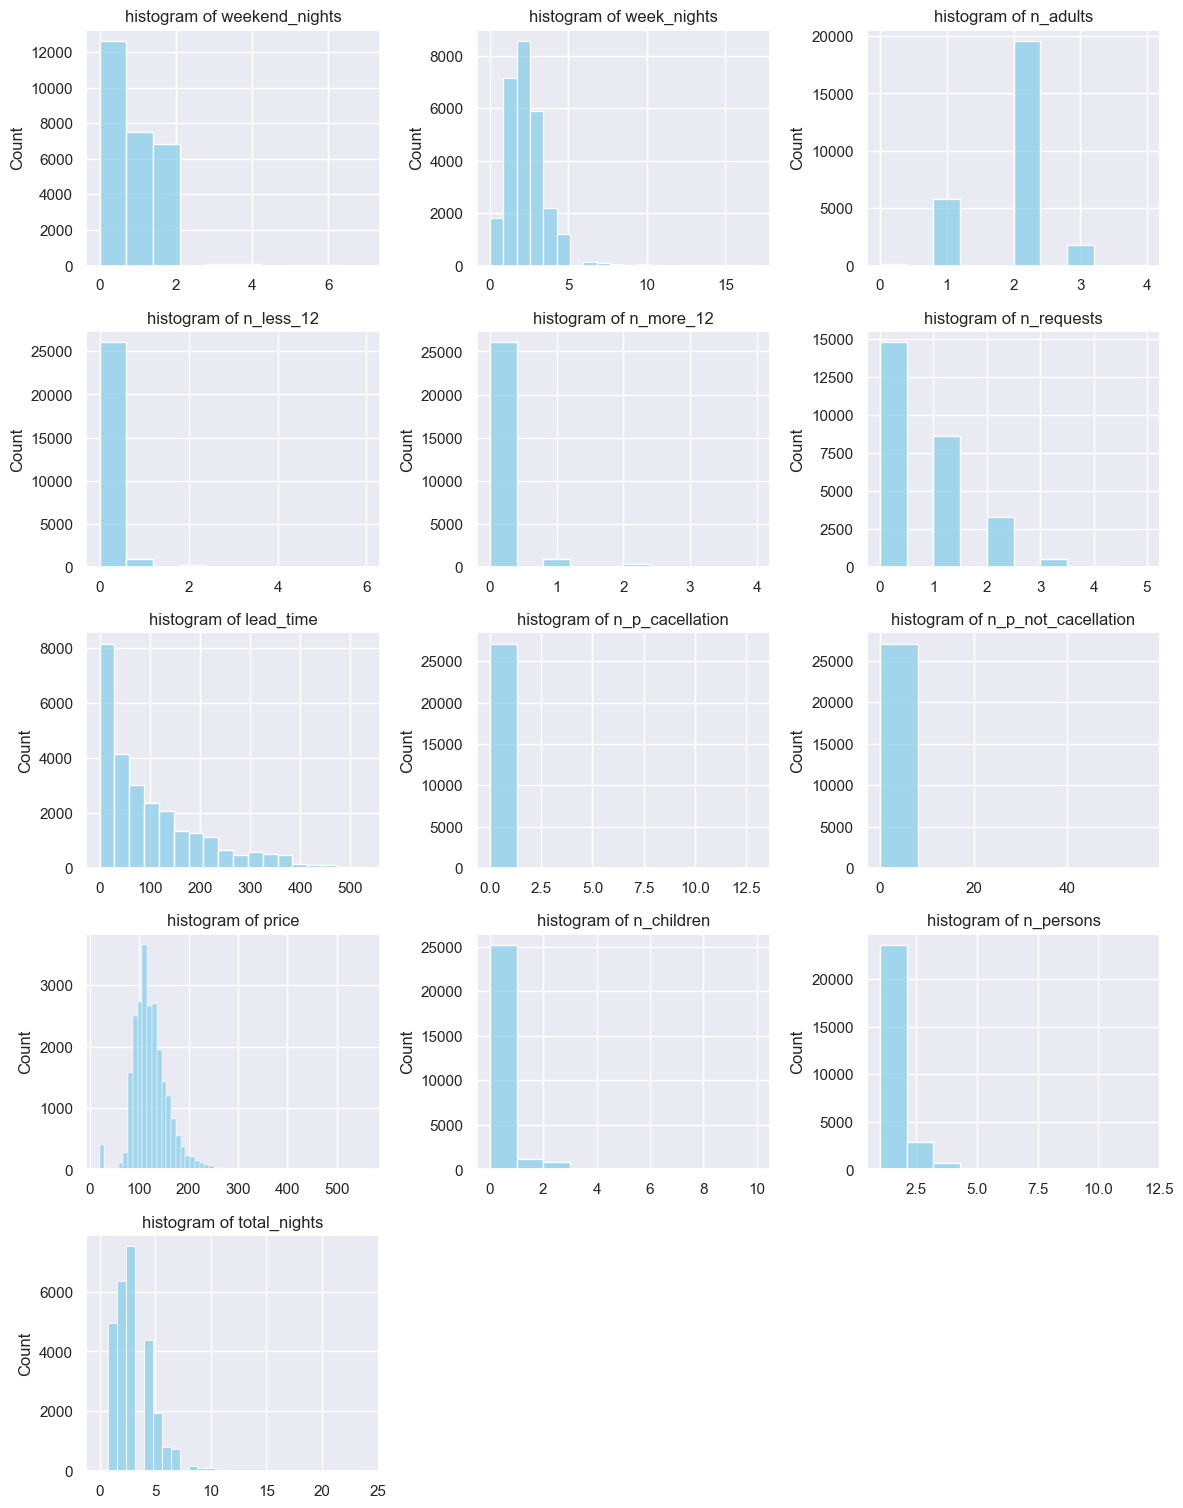

In [12]:
def plot_histograms_in_subplots(df):
    num_columns = df.shape[1]
    num_rows = (num_columns + 1) // 2  # Determine the number of rows needed
    
    fig, axs = plt.subplots(num_rows, 3, figsize=(12, 3 * num_rows))  # Create subplots
    axs = axs.flatten()  # Flatten the axes array for easy indexing
    
    for i, column in enumerate(df.columns):
        counts = df[column].value_counts()
        if df[column].nunique() < 40:
            bins = (np.int32(df[column].nunique()/10)+1)*10
        else:
            bins = np.int32(np.sqrt(df[column].nunique()))
        sns.histplot(df[column], bins=bins, color='skyblue', ax=axs[i])

        # axs[i]=sns.displot(df[column], bins=20, color='skyblue')   
        axs[i].set_title(f'histogram of {column}')
        axs[i].set_xlabel('')
    # Hide any unused subplots
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])
    
    plt.tight_layout()
    plt.show()


plot_histograms_in_subplots(numerical_hotel_data)


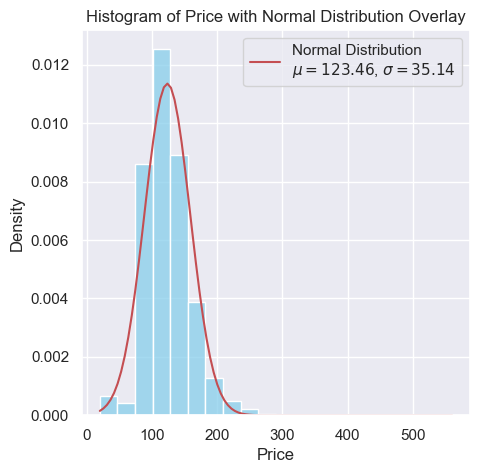

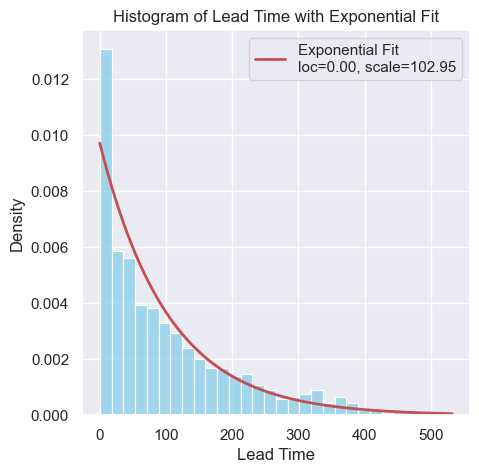

0.0 102.9523773979249


In [13]:
from scipy.stats import norm,expon

price_data = hotel_df['price'].dropna()  # Drop missing values if any
mu, sigma = price_data.mean(), price_data.std()
# Plot histogram of the price data
sns.histplot(price_data, bins=20, kde=False, color='skyblue', stat='density')
x = np.linspace(price_data.min(), price_data.max(), 100)

norm_dist = norm.pdf(x, mu, sigma)

# Plot the normal distribution on top of the histogram

plt.plot(x, norm_dist, 'r-', label=f'Normal Distribution\n$\mu={mu:.2f}$, $\sigma={sigma:.2f}$')

# Add labels and title
plt.xlabel('Price')
plt.ylabel('Density')
plt.title('Histogram of Price with Normal Distribution Overlay')
plt.legend()

# Show the plot
plt.show()


lead_time_data = hotel_df[hotel_df['lead_time'].isna()==False]['lead_time']
sns.histplot(lead_time_data, bins=30, kde=False, stat='density', color='skyblue')
# Fit an exponential distribution to the data
loc, scale = expon.fit(lead_time_data)
x = np.linspace(lead_time_data.min(), lead_time_data.max(), 1000)
pdf = expon.pdf(x, loc, scale)
# Plot the fitted exponential distribution
plt.plot(x, pdf, 'r-', lw=2, label=f'Exponential Fit\nloc={loc:.2f}, scale={scale:.2f}')
plt.xlabel('Lead Time')
plt.ylabel('Density')
plt.title('Histogram of Lead Time with Exponential Fit')
plt.legend()
plt.show()
print(loc, scale)

From the histograms above it looks like 'lead_time' is exponential distributed and 'price' distribution is similar to niorm.



#### Skweness

In [14]:
for col in ['price', 'lead_time', 'week_nights']:
    print(col, ' skewness:', numerical_hotel_data[col].skew(axis = 0, skipna = True) )

price  skewness: 0.682392611272259
lead_time  skewness: 1.291447308852505
week_nights  skewness: 1.5422954469230514


As we can see at the graphs and from the skweness calculation, the 'lead_time' and 'week_nights' columns have long right tail that indicate on asymmrtric distribution (more low values than high values relate to the range of values).

The variable I didn't care already is date. Now I'll change its type to datetime for analyze it properly.

#### Analyze date

In [15]:
hotel_df['date']

0        11/28/2018
1        11/03/2018
2        05/06/2018
3         9/26/2018
4        10/19/2017
            ...    
27208     7/18/2018
27209     2/24/2018
27210     4/15/2018
27211     5/22/2018
27212     7/17/2017
Name: date, Length: 27213, dtype: object

In [16]:
# Convert the 'dates' column from string format to datetime format
hotel_df['date1'] = pd.to_datetime(hotel_df['date'], format='%m/%d/%Y', errors='coerce')

I got an error when I run this line without coercing errors in datetype. Though, I wanted to see which non-date value exist in 'date' column

In [17]:
non_date = np.where(hotel_df['date1'].isnull())
print(f'number of non-date elements is: {len(non_date[0])}\n')
hotel_df.loc[non_date, 'date']

number of non-date elements is: 27



294      2018-2-29
389      2018-2-29
1048     2018-2-29
2872     2018-2-29
3398     2018-2-29
4753     2018-2-29
6521     2018-2-29
7110     2018-2-29
8039     2018-2-29
9087     2018-2-29
9165     2018-2-29
9852     2018-2-29
11893    2018-2-29
13943    2018-2-29
14421    2018-2-29
14886    2018-2-29
16091    2018-2-29
18667    2018-2-29
19680    2018-2-29
20142    2018-2-29
21605    2018-2-29
21898    2018-2-29
22095    2018-2-29
22115    2018-2-29
22153    2018-2-29
22940    2018-2-29
24593    2018-2-29
Name: date, dtype: object

Now I see all errors are the same "date" and the error is expected - someone forgot there's no 29/2.
I want to check my guess so I run a for loop to see the number of reservations on 1/3/2018 and close dates.

In [18]:
start_date = '02/20/2018'
end_date = '03/10/2018'

# Convert start and end dates to datetime format
start_date = pd.to_datetime(start_date, format='%m/%d/%Y')
end_date = pd.to_datetime(end_date, format='%m/%d/%Y')

# Iterate over the date range and sum occurrences for each date
for single_date in pd.date_range(start=start_date, end=end_date):
    count = hotel_df[hotel_df['date1'] == single_date].shape[0]
    if count>0:
        print(f"Date: {single_date.strftime('%m/%d/%Y')} - Number of reservations: {count}")


Date: 02/20/2018 - Number of reservations: 41
Date: 02/21/2018 - Number of reservations: 29
Date: 02/22/2018 - Number of reservations: 43
Date: 02/23/2018 - Number of reservations: 21
Date: 02/24/2018 - Number of reservations: 44
Date: 02/25/2018 - Number of reservations: 35
Date: 02/26/2018 - Number of reservations: 58
Date: 02/27/2018 - Number of reservations: 74
Date: 02/28/2018 - Number of reservations: 118
Date: 03/01/2018 - Number of reservations: 49
Date: 03/02/2018 - Number of reservations: 70
Date: 03/03/2018 - Number of reservations: 50
Date: 03/04/2018 - Number of reservations: 69
Date: 03/05/2018 - Number of reservations: 52
Date: 03/06/2018 - Number of reservations: 31
Date: 03/07/2018 - Number of reservations: 49
Date: 03/08/2018 - Number of reservations: 54
Date: 03/09/2018 - Number of reservations: 41
Date: 03/10/2018 - Number of reservations: 52


There is no sign in data show someone wrote 29/2 instead of 1/3. But still, this is a logical and plausible explanation and the available information does not contradict this explanation.

Now I want to see the distribution of dates. I want to present histogram of dates. I will also present the distribution by months and by days in month.



<Axes: xlabel='day', ylabel='Count'>

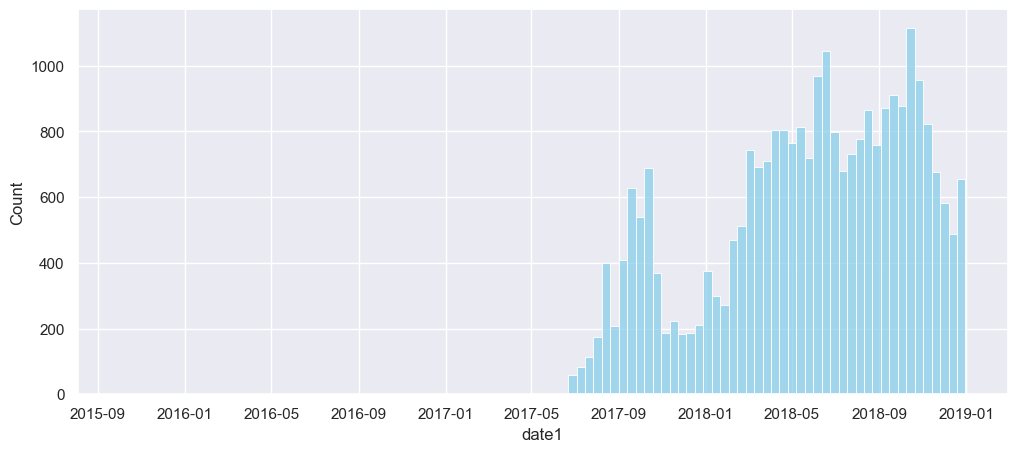

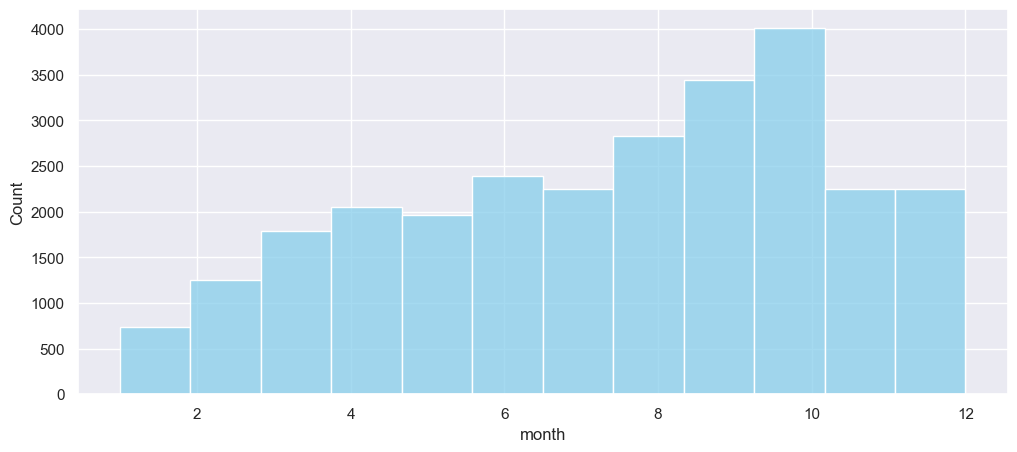

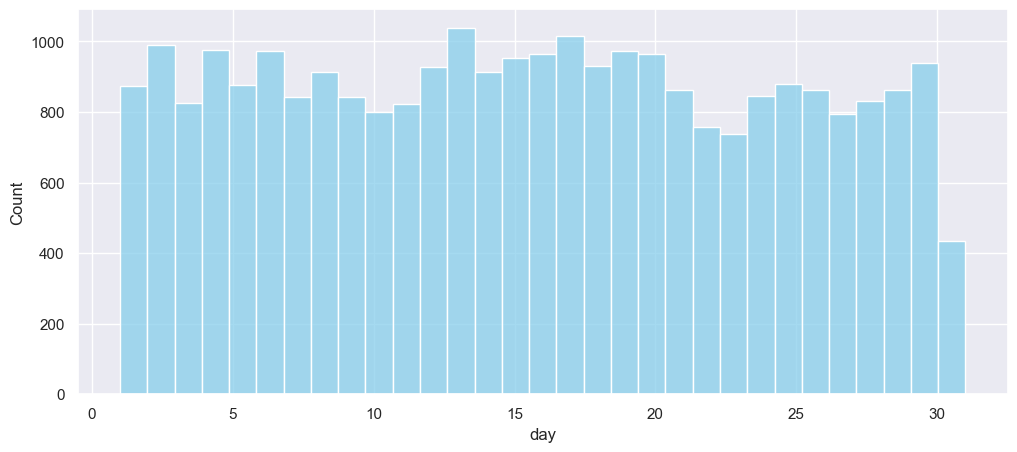

In [19]:
hotel_df['date1'] = hotel_df['date1'].fillna(pd.to_datetime('03/01/2018', format='%m/%d/%Y'))
fig, axs = plt.subplots(figsize = [12,5])
sns.histplot(hotel_df['date1'], bins=100, color='skyblue')
hotel_df['month'] = hotel_df['date1'].dt.month
hotel_df['day'] = hotel_df['date1'].dt.day
fig, axs = plt.subplots(figsize = [12,5])
sns.histplot(hotel_df['month'], bins=12, color='skyblue')
fig, axs = plt.subplots(figsize = [12,5])
sns.histplot(hotel_df['day'], color='skyblue')


It seems like there is outliers in dates (on 2015-2016), I'll show the boxplot of date to see that and filter outliers if they are few and far from the main of data.

<Axes: ylabel='date1'>

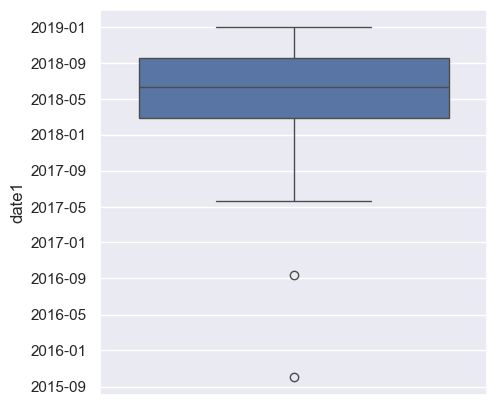

In [20]:
sns.boxplot(y="date1", data=hotel_df)


             ID  weekend_nights  week_nights    room_type  board_type  \
3279   INN00001               2            5  Room_Type 1  half board   
25403  INN00006               0            2  Room_Type 1   breakfast   

       n_adults  n_less_12  n_more_12  booked_tour  n_requests  ...  repeated  \
3279          1          0          1        False           0  ...     False   
25403         1          0          0        False           1  ...     False   

       price        date  is_canceled  n_children  n_persons total_nights  \
3279  108.00  10/02/2015        False           1          2            7   
25403 120.00   9/13/2016         True           0          1            2   

           date1  month  day  
3279  2015-10-02     10    2  
25403 2016-09-13      9   13  

[2 rows x 24 columns]


<Axes: xlabel='date1', ylabel='Count'>

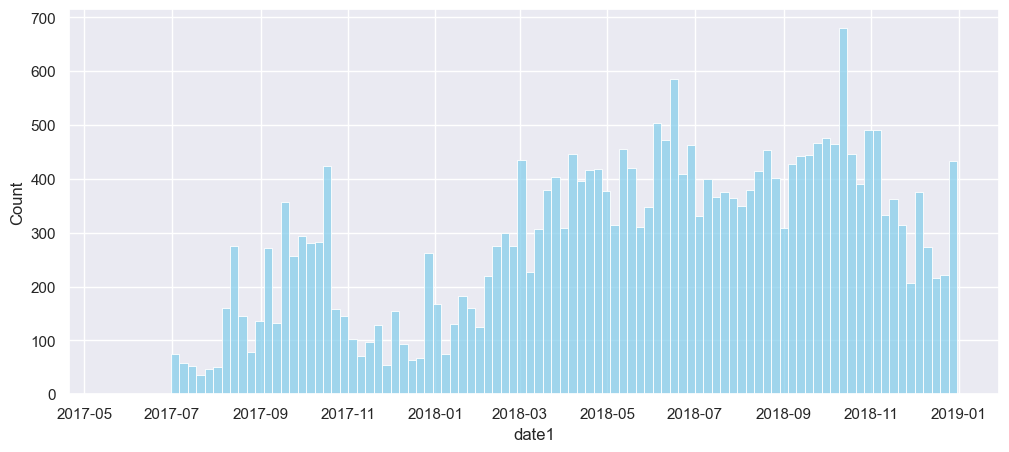

In [21]:
cutoff_date = pd.to_datetime('05/01/2017', format='%m/%d/%Y')
print(hotel_df[hotel_df['date1']<cutoff_date])
hotel_df = hotel_df[hotel_df['date1']>cutoff_date]
fig, axs = plt.subplots(figsize = [12,5])
sns.histplot(hotel_df['date1'], bins=100, color='skyblue')


### Exploring the behavior of the attributes according to the target values

#### Histograms

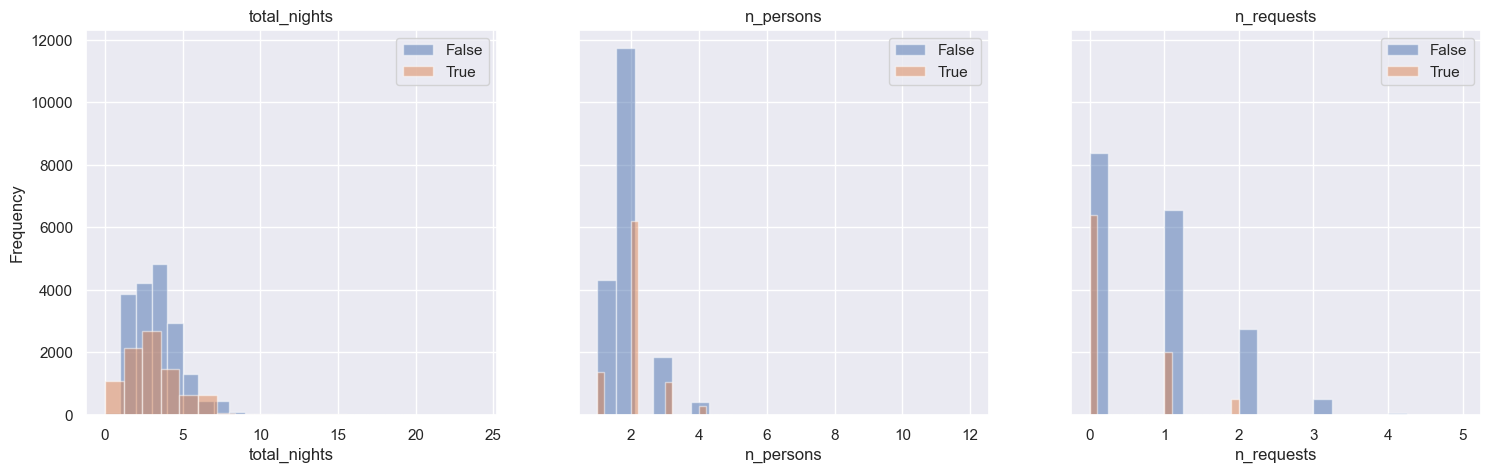

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# Loop through the columns and plot on each axis
for i, column in enumerate(['total_nights', 'n_persons', 'n_requests']):
    hotel_df.groupby('is_canceled')[column].plot(kind='hist', bins=20, alpha=0.5, legend=True, ax=axes[i])
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(column)
plt.show()



#### Scatter plot

Text(0, 0.5, 'month')

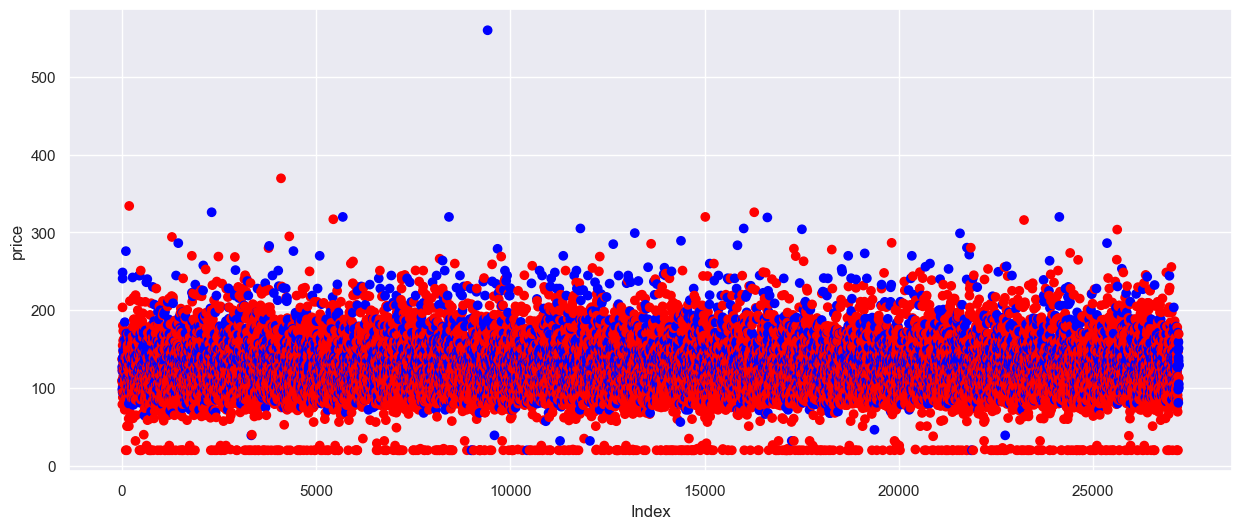

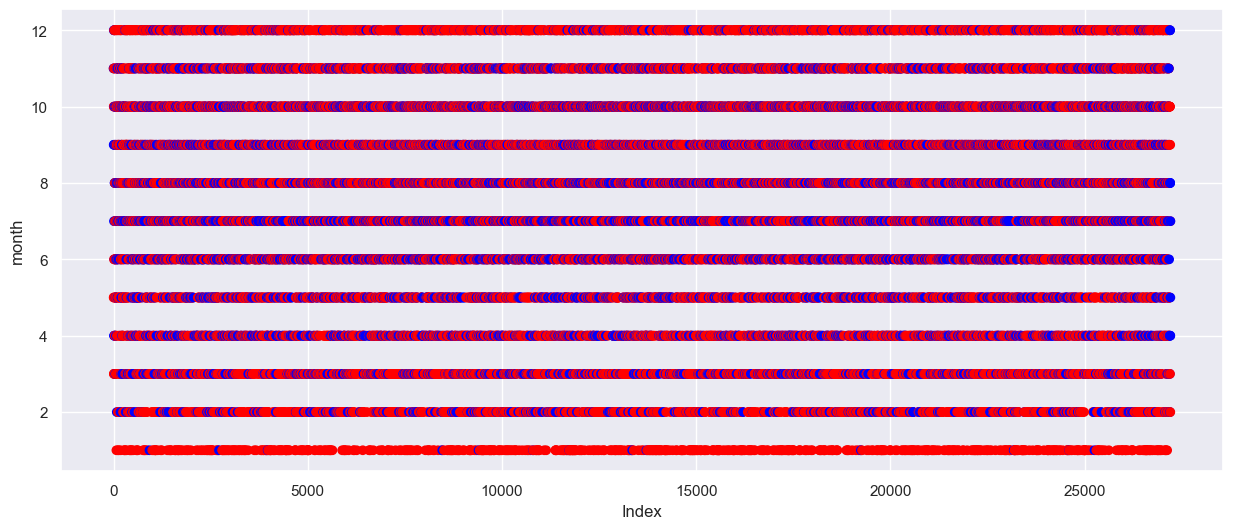

In [23]:
colordict = {False: 'red', True: 'blue'}

plt.figure(figsize=(15, 6))
plt.scatter(hotel_df.index, hotel_df['price'], c = hotel_df['is_canceled'].map(colordict))
plt.xlabel("Index")
plt.ylabel('price')

plt.figure(figsize=(15, 6))
plt.scatter(hotel_df.index, hotel_df['month'], c = hotel_df['is_canceled'].map(colordict))
plt.xlabel("Index")
plt.ylabel('month')

#### Boxplot graphs

C:\Users\Moshe\AppData\Local\Temp\ipykernel_16352\539196079.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y="price", x="n_persons", data=hotel_df, palette="Set3")


<Axes: ylabel='date1'>

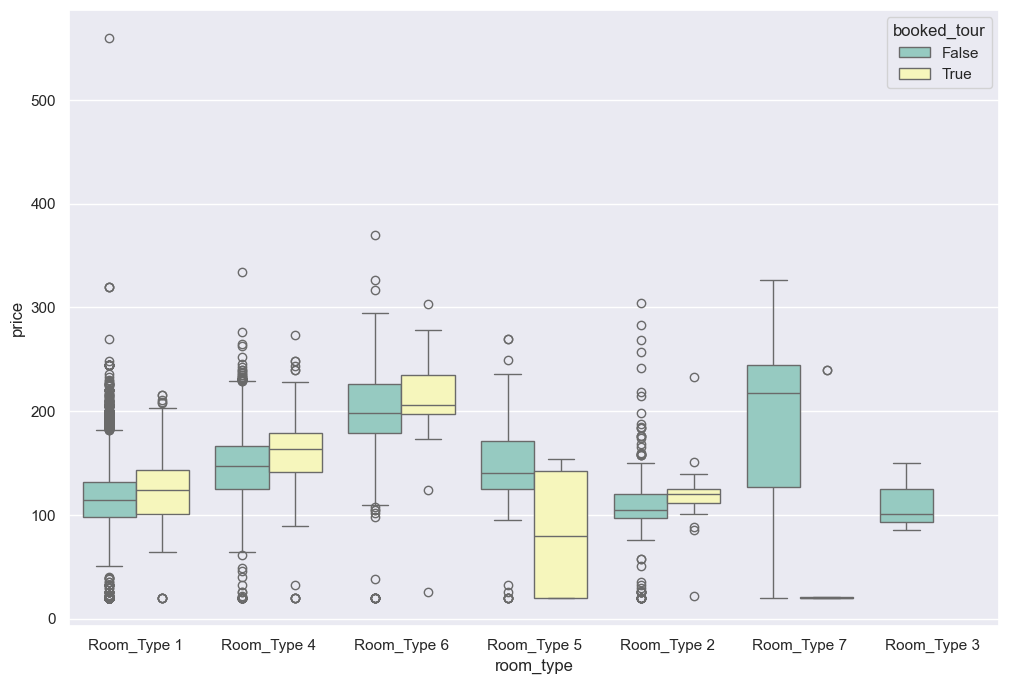

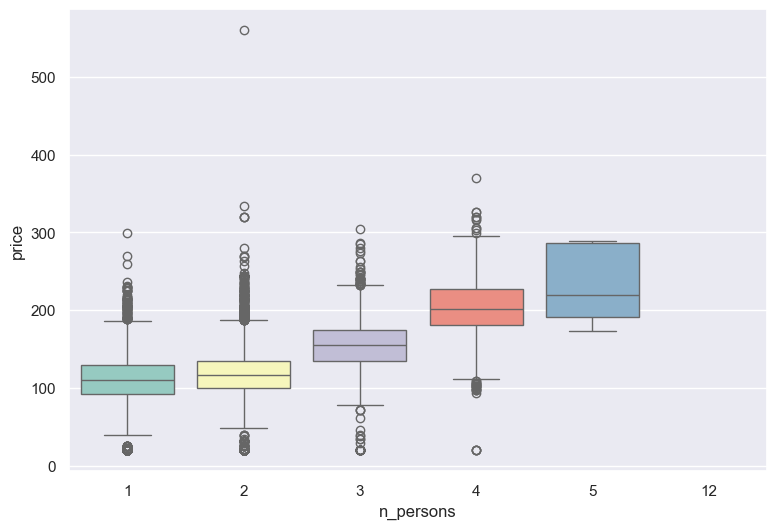

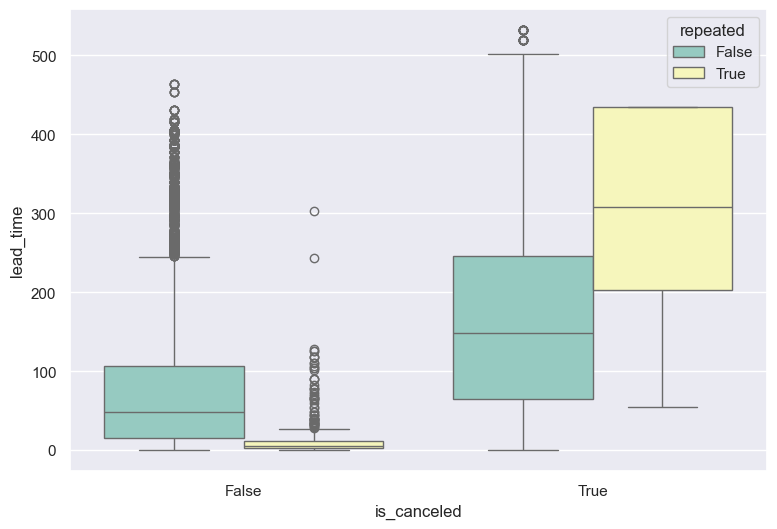

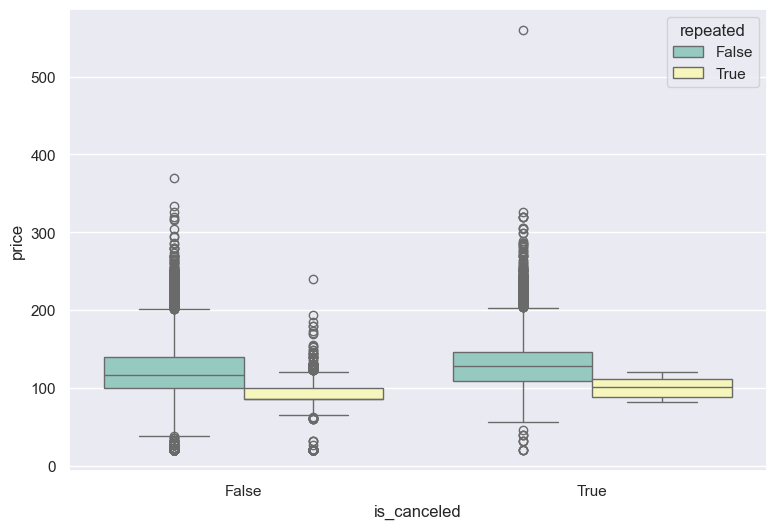

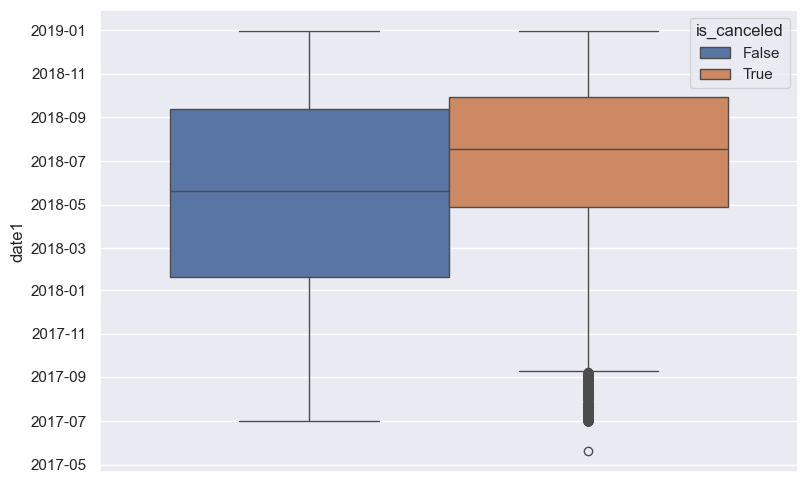

In [24]:
sns.set(rc={'figure.figsize':(12,8)})

plt.figure()
sns.boxplot(y="price", x="room_type", hue= "booked_tour", data=hotel_df, palette="Set3")

sns.set(rc={'figure.figsize':(9,6)})

plt.figure()
sns.boxplot(y="price", x="n_persons", data=hotel_df, palette="Set3")
plt.figure()
sns.boxplot(y="lead_time", x="is_canceled", hue= "repeated", data=hotel_df, palette="Set3")
plt.figure()
sns.boxplot(y="price", x="is_canceled", hue= "repeated", data=hotel_df, palette="Set3")
plt.figure()
sns.boxplot(y="date1", hue="is_canceled", data=hotel_df)

#### Barplot of relationship

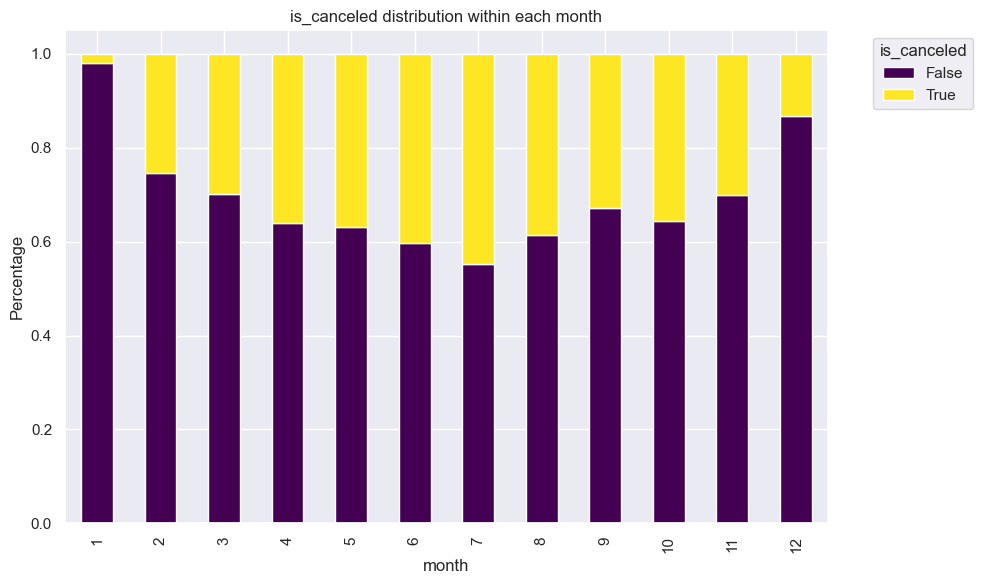

In [25]:
def plotbar_categorical_relationship(df, var1, var2):
    
    # Plot the relationship between two categorical variables in a DataFrame using bar plot.
    # Create a crosstab to count the occurrences of each combination of var1 and var2
    crosstab = pd.crosstab(df[var1], df[var2], normalize='index')

    # Plot bar chart
    crosstab.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
    plt.xlabel(var1)
    plt.ylabel('Percentage')
    plt.title(f'{var2} distribution within each {var1}')
    plt.legend(title=var2, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

# Plot relationship between 'month' and 'is_canceled'
plotbar_categorical_relationship(hotel_df, 'month', 'is_canceled')



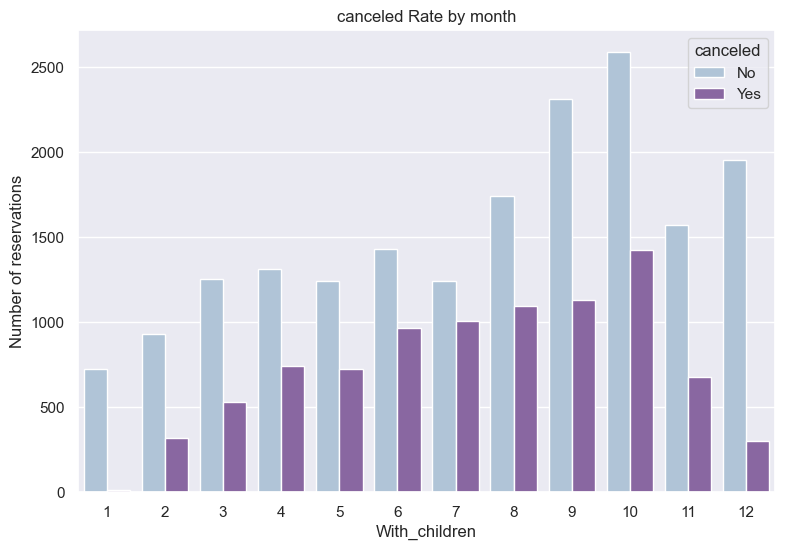

In [26]:
sns.countplot(x='month', hue='is_canceled', data=hotel_df, palette='BuPu')
plt.title('canceled Rate by month')
plt.xlabel('With_children')
plt.ylabel('Number of reservations')
plt.legend(title='canceled', labels=['No', 'Yes'])
plt.show()


we can see the cancellation rate is bigger in summer and smaller in winter

## Preproccessing

### Missing values

First, analize the form of missing values

In [27]:
cols_with_missing_values = ['price', 'lead_time', 'board_type', 'purchase_type']
# Create a boolean DataFrame indicating missing values
missing_df = hotel_df[cols_with_missing_values].isna()
n = len(cols_with_missing_values)
missing_count_matrix = np.zeros((n, n), dtype=int)

# Loop over pairs of variables to count simultaneous missing values
for i in range(n):
    for j in range(n):
        # Count rows where both variables have missing values
        missing_count_matrix[i, j] = (missing_df.iloc[:, i] & missing_df.iloc[:, j]).sum()

# Convert the matrix to a DataFrame for easier viewing
missing_count_df = pd.DataFrame(missing_count_matrix, 
                                index=cols_with_missing_values, 
                                columns=cols_with_missing_values)
print('num of missing values for each variable:')
print(missing_df.sum(axis=0))
print('\nsum of pairs of missing values:')
print(missing_count_df)


num of missing values for each variable:
price            3405
lead_time         419
board_type       8168
purchase_type    4847
dtype: int64

sum of pairs of missing values:
               price  lead_time  board_type  purchase_type
price           3405        419        3405           3405
lead_time        419        419         419            419
board_type      3405        419        8168           4847
purchase_type   3405        419        4847           4847


Second, refer to the 'simple' missing values - Those where the missing value can be defined as an independent category.

In [28]:
hotel_df.loc[hotel_df['board_type'].isna(),'board_type'] = 'missing'
hotel_df.loc[hotel_df['purchase_type'].isna(),'purchase_type'] = 'missing'


Last, refer to another missing values - in price and in lead_time.

### simple outliers

In [29]:
# check values seems to be outliers on charts
for colname in upto8_unique_vals['Variable']:
    print('Value count of', colname, ':\n', hotel_df[colname].value_counts(),'\n')

# check also n_p_not_cancelation
print('Value count of', 'n_p_not_cacellation', ':\n', hotel_df['n_p_not_cacellation'].value_counts(),'\n')

Value count of booked_tour :
 booked_tour
False    26347
True       864
Name: count, dtype: int64 

Value count of repeated :
 repeated
False    26492
True       719
Name: count, dtype: int64 

Value count of is_canceled :
 is_canceled
False    18295
True      8916
Name: count, dtype: int64 

Value count of board_type :
 board_type
half board      14590
missing          8168
full board       2697
breakfast        1752
not selected        4
Name: count, dtype: int64 

Value count of n_adults :
 n_adults
2    19565
1     5779
3     1749
0      104
4       14
Name: count, dtype: int64 

Value count of n_less_12 :
 n_less_12
0    26038
1      910
2      260
3        2
6        1
Name: count, dtype: int64 

Value count of n_more_12 :
 n_more_12
0    26050
1      875
2      283
3        2
4        1
Name: count, dtype: int64 

Value count of n_children :
 n_children
0     25167
1      1216
2       814
3        13
10        1
Name: count, dtype: int64 

Value count of purchase_type :
 purchas


Conclusions:
If you choose a threshold value of 0.2% then you will discover outliers ​​in about ten variables..

In [30]:
# replace outliers with according values
hotel_df.loc[hotel_df['board_type']=='not selected','board_type'] = 'missing'

# In order to reduce outliers, log transform n_p_not_cacellation and n_p_cacellation
hotel_df['log_n_p_cancellation'] = np.int32(np.log2(hotel_df['n_p_cacellation']+1))
hotel_df['log_n_p_not_cancellation'] = np.int32(np.log2(hotel_df['n_p_not_cacellation']+1))
hotel_df['log_n_p_not_cancellation'].value_counts()

C:\Users\Moshe\AppData\Local\Temp\ipykernel_16352\2000697766.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hotel_df['log_n_p_cancellation'] = np.int32(np.log2(hotel_df['n_p_cacellation']+1))
C:\Users\Moshe\AppData\Local\Temp\ipykernel_16352\2000697766.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hotel_df['log_n_p_not_cancellation'] = np.int32(np.log2(hotel_df['n_p_not_cacellation']+1))


log_n_p_not_cancellation
0    26582
1      256
2      197
3       98
4       58
5       20
Name: count, dtype: int64

### Correlations and 'complicate' outliers

#### Full correlation matrix

In [31]:
# Add intresting variables before calculate correlations
# assume room type is ordinal feature
hotel_df['room_type_cat'] = hotel_df['room_type'].astype('category').cat.codes
hotel_df.groupby(['room_type','room_type_cat']).size()

C:\Users\Moshe\AppData\Local\Temp\ipykernel_16352\2965023716.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hotel_df['room_type_cat'] = hotel_df['room_type'].astype('category').cat.codes


room_type    room_type_cat
Room_Type 1  0                21082
Room_Type 2  1                  511
Room_Type 3  2                    3
Room_Type 4  3                 4571
Room_Type 5  4                  180
Room_Type 6  5                  741
Room_Type 7  6                  123
dtype: int64

In [32]:
cat_columns = ['weekend_nights', 'week_nights', 'total_nights', 'n_persons', 'n_children',
       'n_adults', 'n_less_12', 'n_more_12', 'month', 'day', 'booked_tour', 'n_requests',
       'log_n_p_cancellation', 'log_n_p_not_cancellation',
       'repeated','lead_time',  'price', 'room_type_cat', 'is_canceled'] 
# cat_columns = hotel_df.drop(columns=['date', 'ID', 'board_type', 'purchase_type', 'room_type']).columns
hotel_df[cat_columns].corr(method = 'pearson')

weekend_nights  week_nights  total_nights  \
weekend_nights                      1.00         0.17          0.63   
week_nights                         0.17         1.00          0.88   
total_nights                        0.63         0.88          1.00   
n_persons                           0.10         0.10          0.13   
n_children                          0.03         0.02          0.03   
n_adults                            0.11         0.11          0.14   
n_less_12                           0.02         0.01          0.02   
n_more_12                           0.02         0.02          0.03   
month                              -0.01         0.04          0.02   
day                                 0.03        -0.01          0.00   
booked_tour                        -0.03        -0.05         -0.06   
n_requests                          0.06         0.05          0.07   
log_n_p_cancellation               -0.03        -0.04         -0.04   
log_n_p_not_cancellation           -0.06        -0.09         -0.10   
repeated                           -0.07        -0.10         -0.11   
lead_time                           0.05         0.15          0.14   
price                              -0.00         0.02          0.02   
room_type_cat                       0.06         0.09          0.10   
is_canceled                         0.07         0.09          0.11   

                          n_persons  n_children  n_adults  n_less_12  \
weekend_nights                 0.10        0.03      0.11       0.02   
week_nights                    0.10        0.02      0.11       0.01   
total_nights                   0.13        0.03      0.14       0.02   
n_persons                      1.00        0.60      0.79       0.46   
n_children                     0.60        1.00     -0.02       0.75   
n_adults                       0.79       -0.02      1.00      -0.01   
n_less_12                      0.46        0.75     -0.01       1.00   
n_more_12                      0.45        0.75     -0.02       0.13   
month                          0.02       -0.00      0.02      -0.00   
day                            0.04        0.03      0.03       0.02   
booked_tour                    0.03        0.04      0.01       0.04   
n_requests                     0.23        0.13      0.19       0.09   
log_n_p_cancellation          -0.08       -0.02     -0.08      -0.02   
log_n_p_not_cancellation      -0.16       -0.03     -0.18      -0.02   
repeated                      -0.18       -0.04     -0.20      -0.03   
lead_time                      0.05       -0.05      0.10      -0.04   
price                          0.45        0.34      0.30       0.26   
room_type_cat                  0.44        0.37      0.27       0.28   
is_canceled                    0.09        0.03      0.09       0.02   

                          n_more_12  month   day  booked_tour  n_requests  \
weekend_nights                 0.02  -0.01  0.03        -0.03        0.06   
week_nights                    0.02   0.04 -0.01        -0.05        0.05   
total_nights                   0.03   0.02  0.00        -0.06        0.07   
n_persons                      0.45   0.02  0.04         0.03        0.23   
n_children                     0.75  -0.00  0.03         0.04        0.13   
n_adults                      -0.02   0.02  0.03         0.01        0.19   
n_less_12                      0.13  -0.00  0.02         0.04        0.09   
n_more_12                      1.00  -0.00  0.02         0.02        0.10   
month                         -0.00   1.00 -0.03        -0.02        0.11   
day                            0.02  -0.03  1.00        -0.00        0.02   
booked_tour                    0.02  -0.02 -0.00         1.00        0.09   
n_requests                     0.10   0.11  0.02         0.09        1.00   
log_n_p_cancellation          -0.02  -0.01 -0.02         0.03       -0.01   
log_n_p_not_cancellation      -0.02  -0.02 -0.01         0.10        0.02   
repeated 

Text(0.5, 1.0, 'Spearman correlation')

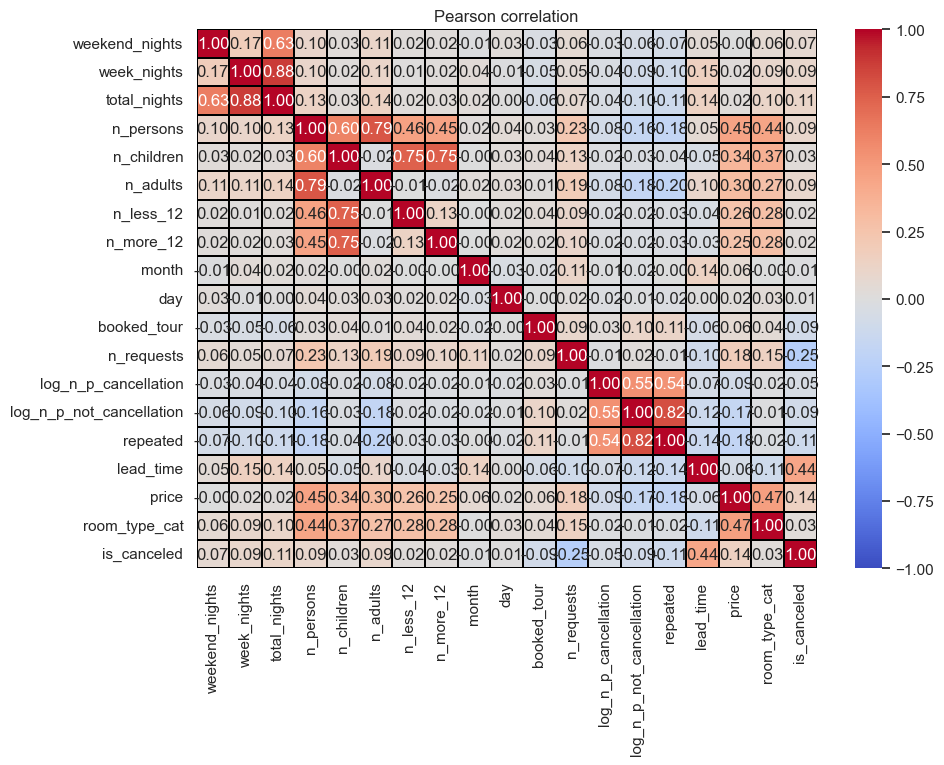

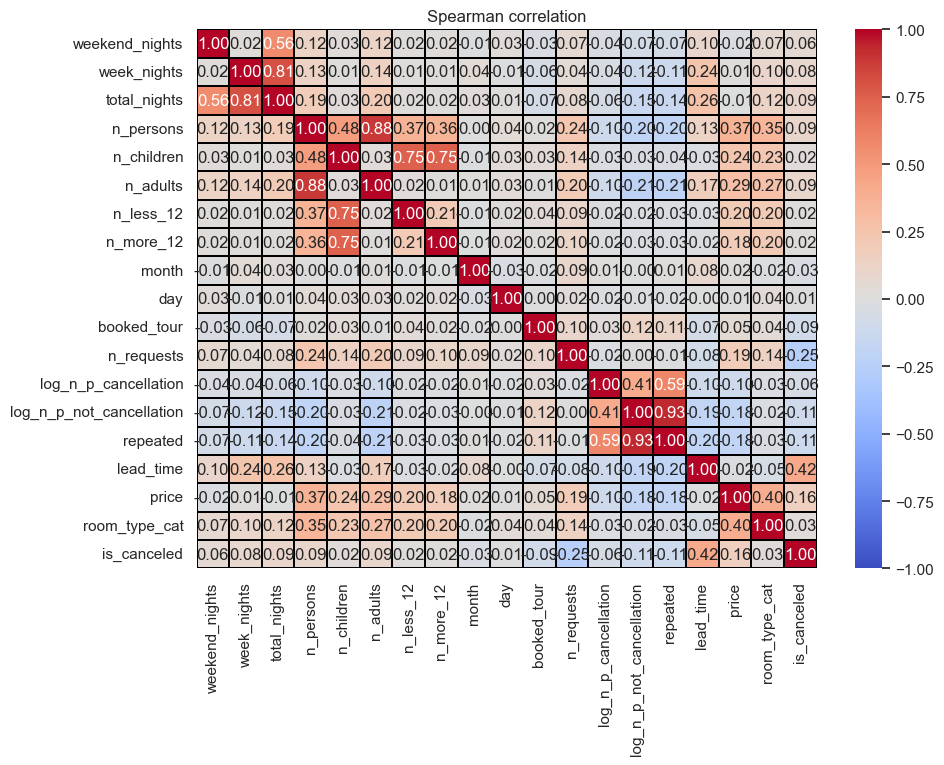

In [33]:
display(HTML(f'<span style="font-size:24px; color:black; font-weight:bold;">Pearson and spearman correlation map between numerical/ordinal variables:'))
f, ax = plt.subplots(figsize=(10, 7))
ax = sns.heatmap(hotel_df[cat_columns].corr(method = 'pearson'), annot = True, vmin=-1, vmax=1, center= 0,
            cmap= 'coolwarm', linewidths=0.2, fmt='.2f', linecolor='black')
ax.set_title('Pearson correlation')
f, ax = plt.subplots(figsize=(10, 7))
ax = sns.heatmap(hotel_df[cat_columns].corr(method = 'spearman'), annot = True, vmin=-1, vmax=1, center= 0,
            cmap= 'coolwarm', linewidths=0.2, fmt='.2f', linecolor='black')
ax.set_title('Spearman correlation')


#### Mini correlation matrix

Text(0.5, 1.0, 'Spearman correlation')

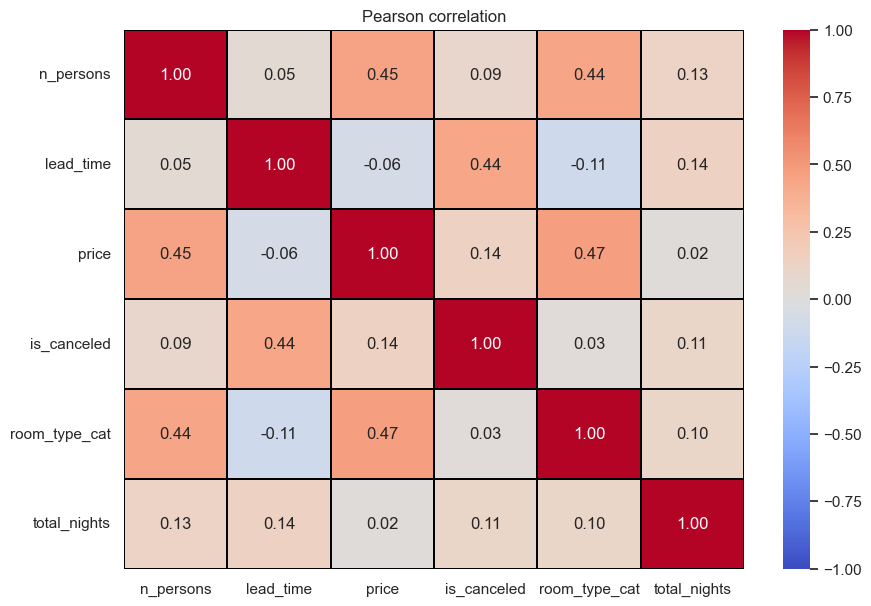

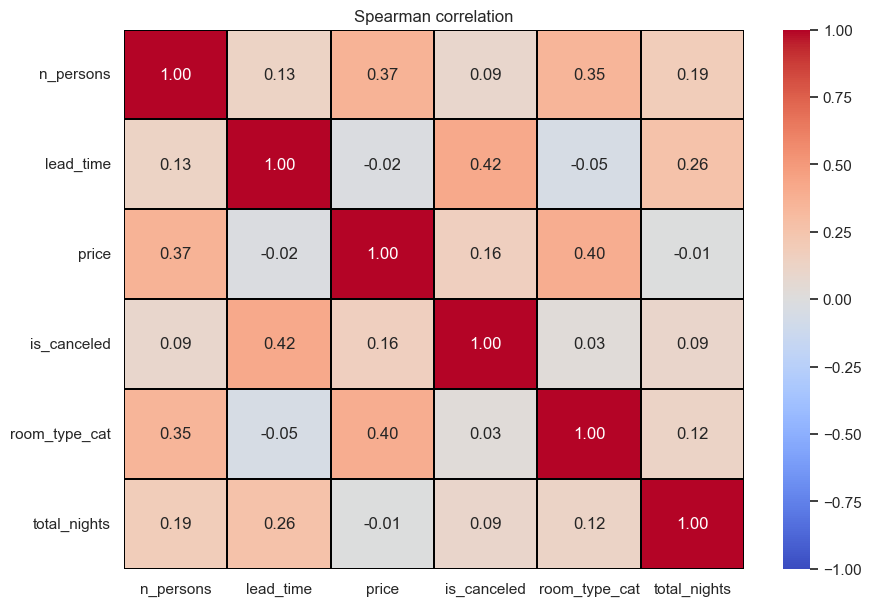

In [34]:
# mini heatmap
cat_columns = ['n_persons',
       'lead_time', 'price', 'is_canceled', 'room_type_cat', 'total_nights'] 

display(HTML(f'<span style="font-size:24px; color:black; font-weight:bold;">Heatmap of meaning correlated variables:'))
f, ax = plt.subplots(figsize=(10, 7))
ax = sns.heatmap(hotel_df[cat_columns].corr(method = 'pearson'), annot = True, vmin=-1, vmax=1, center= 0,
            cmap= 'coolwarm', linewidths=0.2, fmt='.2f', linecolor='black')
ax.set_title('Pearson correlation')
f, ax = plt.subplots(figsize=(10, 7))
ax = sns.heatmap(hotel_df[cat_columns].corr(method = 'spearman'), annot = True, vmin=-1, vmax=1, center= 0,
            cmap= 'coolwarm', linewidths=0.2, fmt='.2f', linecolor='black')
ax.set_title('Spearman correlation')


#### Relations between room type, num of persons and price.

##### Vizualize relations


 Reservations with Room Type 3: 
       n_persons  n_children  price
15033          1           0  85.00
19728          2           0 100.75
23024          2           0 150.00





<Figure size 300x400 with 0 Axes>

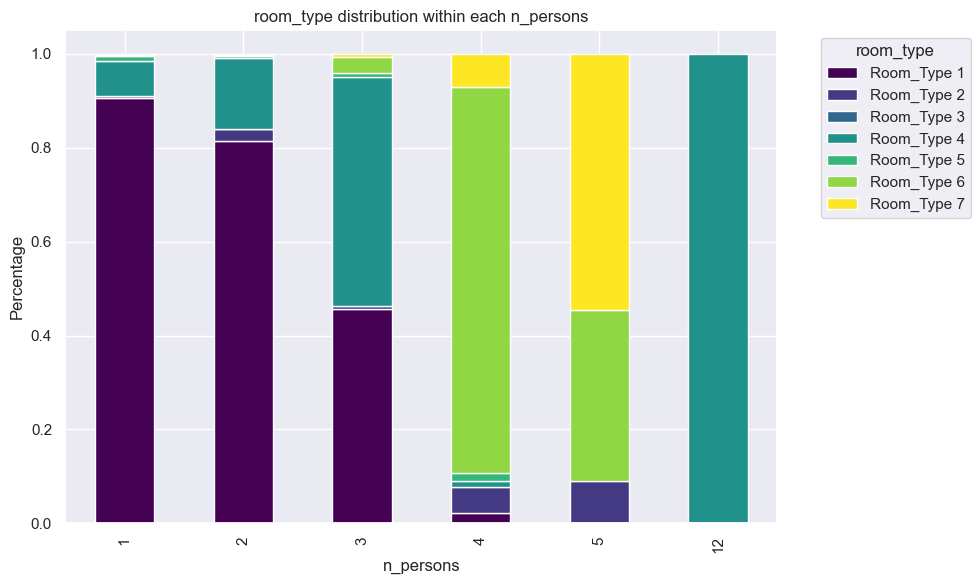

<Figure size 300x400 with 0 Axes>

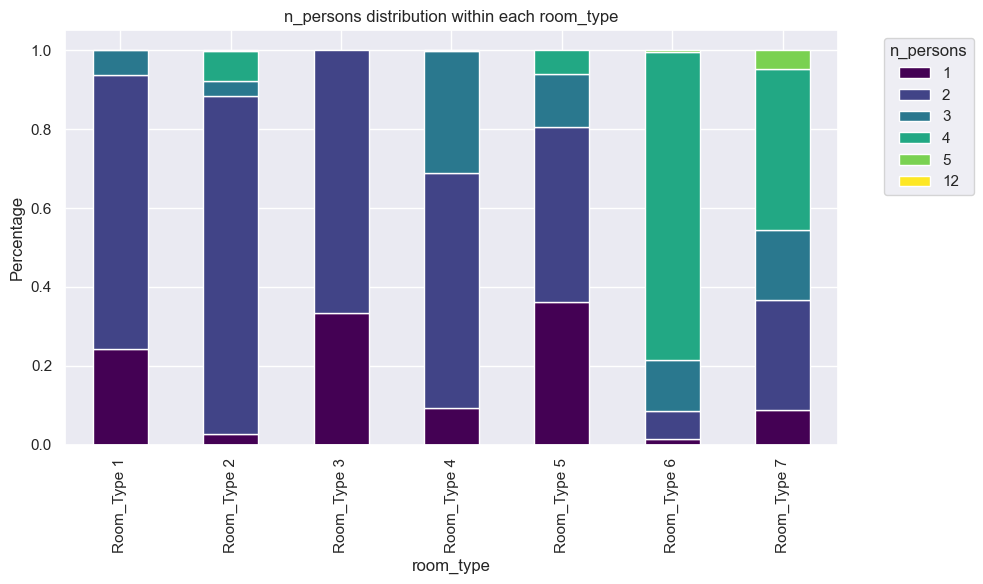

<Figure size 300x400 with 0 Axes>

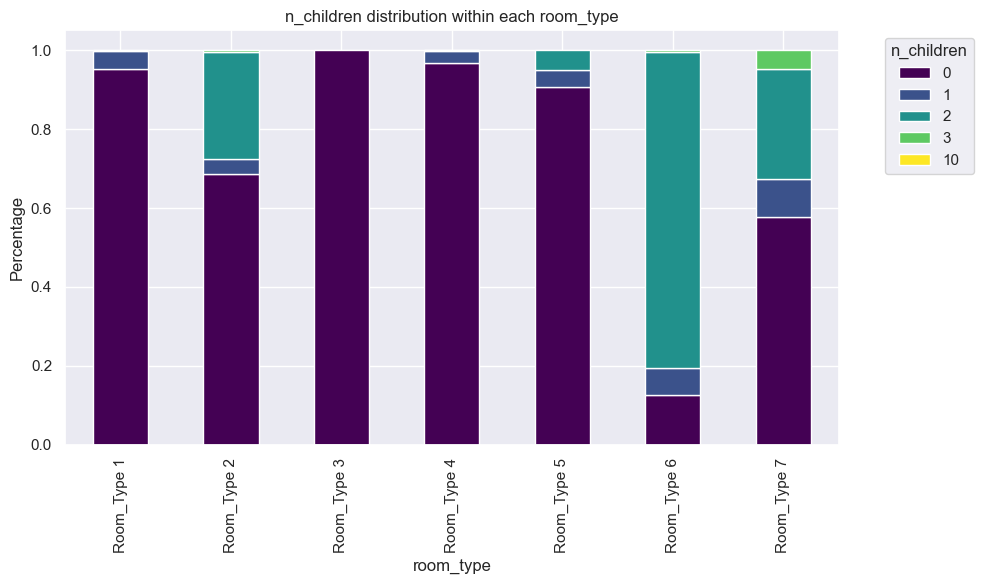

<Figure size 300x400 with 0 Axes>

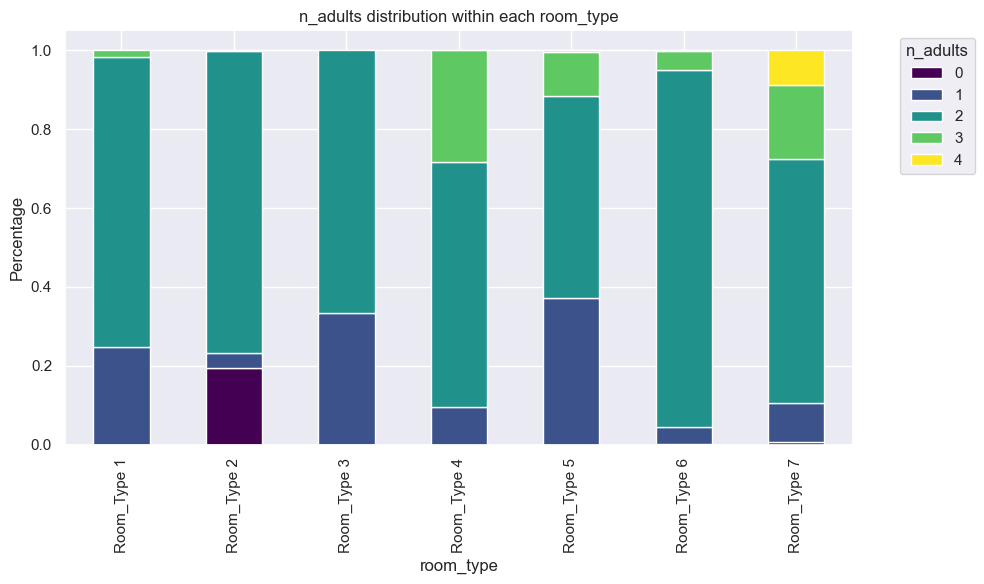

In [35]:
print('\n Reservations with Room Type 3: ')
print(hotel_df[hotel_df['room_type']=='Room_Type 3'][['n_persons','n_children', 'price']])
print('\n\n')
# Plot varius of relationships between 'room_type' and 'n_persons'
plt.figure(figsize=(3, 4))

plotbar_categorical_relationship(hotel_df, 'n_persons', 'room_type')
plt.figure(figsize=(3, 4))

plotbar_categorical_relationship(hotel_df, 'room_type', 'n_persons')
plt.figure(figsize=(3, 4))
plotbar_categorical_relationship(hotel_df, 'room_type', 'n_children')
plt.figure(figsize=(3, 4))
plotbar_categorical_relationship(hotel_df, 'room_type', 'n_adults')


##### fix room type

In the first graph you can see that a large majority of the reservations of one or two guests chose room type 1. In the second graph you can see that the distribution of the number of people in room 1 is the one that is most similar to the distribution of the number of people in room type 3. Therefore, I concluded that it is worth replacing the outliers of room type 3 in a type 1 room.

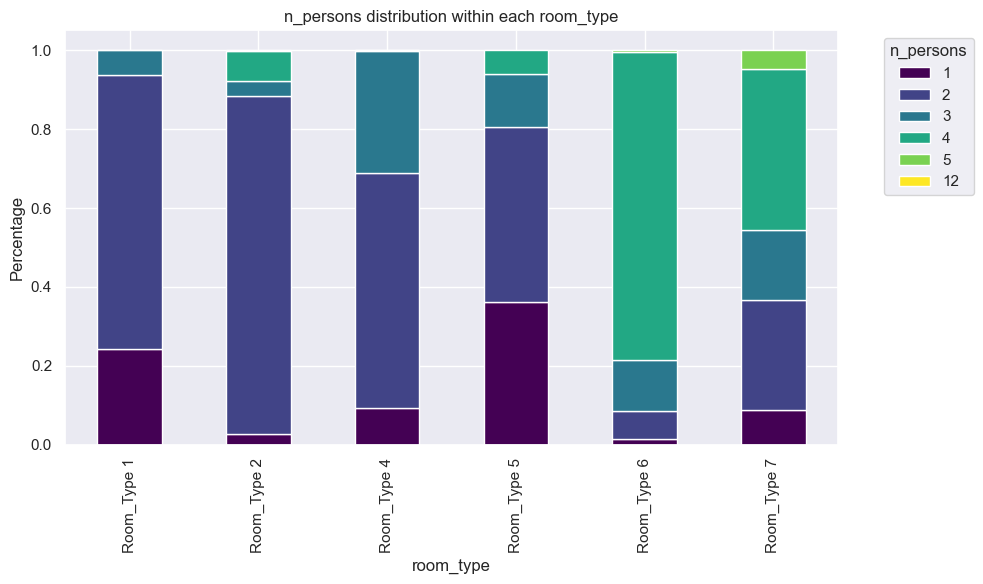

C:\Users\Moshe\AppData\Local\Temp\ipykernel_16352\4241369523.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hotel_df['room_type_cat'] = hotel_df['room_type'].astype('category').cat.codes


room_type    room_type_cat
Room_Type 1  0                21085
Room_Type 2  1                  511
Room_Type 4  2                 4571
Room_Type 5  3                  180
Room_Type 6  4                  741
Room_Type 7  5                  123
dtype: int64

In [36]:
hotel_df.loc[hotel_df['room_type']=='Room_Type 3','room_type'] = 'Room_Type 1'
plotbar_categorical_relationship(hotel_df, 'room_type', 'n_persons')
# update changes in 'room_type_cat'
hotel_df['room_type_cat'] = hotel_df['room_type'].astype('category').cat.codes
hotel_df.groupby(['room_type','room_type_cat']).size()

C:\Users\Moshe\AppData\Local\Temp\ipykernel_16352\2972909731.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hotel_df['room_type'] = pd.Categorical(hotel_df['room_type'], categories=new_order, ordered=True)
C:\Users\Moshe\AppData\Local\Temp\ipykernel_16352\2972909731.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hotel_df['room_type_cat'] = hotel_df['room_type'].cat.codes


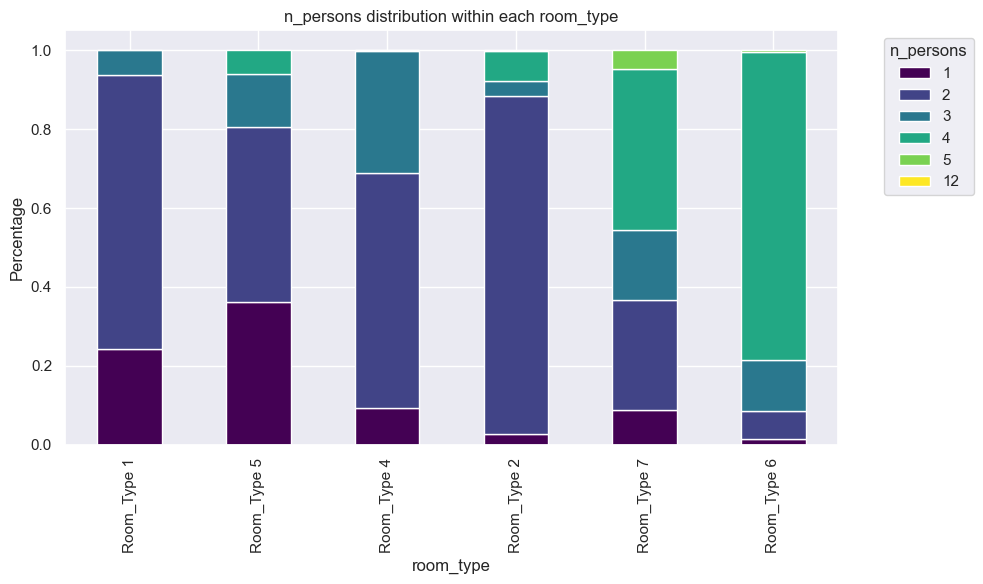

In [37]:
from pandas.api.types import CategoricalDtype
# rearrange roomtypes according to barplot
new_order = ['Room_Type 1', 'Room_Type 5', 'Room_Type 4', 'Room_Type 2', 'Room_Type 7', 'Room_Type 6'] 
# Apply the new order to the variables
hotel_df['room_type'] = pd.Categorical(hotel_df['room_type'], categories=new_order, ordered=True)
hotel_df['room_type_cat'] = hotel_df['room_type'].cat.codes
plotbar_categorical_relationship(hotel_df, 'room_type', 'n_persons')


##### fix prices

n_persons        1        2       3      4    5    12
room_type                                            
Room_Type 1 5142.00 14604.00 1324.00  15.00  NaN  NaN
Room_Type 5   65.00    80.00   24.00  11.00  NaN  NaN
Room_Type 4  425.00  2718.00 1417.00  10.00  NaN 1.00
Room_Type 2   14.00   437.00   20.00  39.00 1.00  NaN
Room_Type 7   11.00    34.00   22.00  50.00 6.00  NaN
Room_Type 6   11.00    52.00   97.00 577.00 4.00  NaN


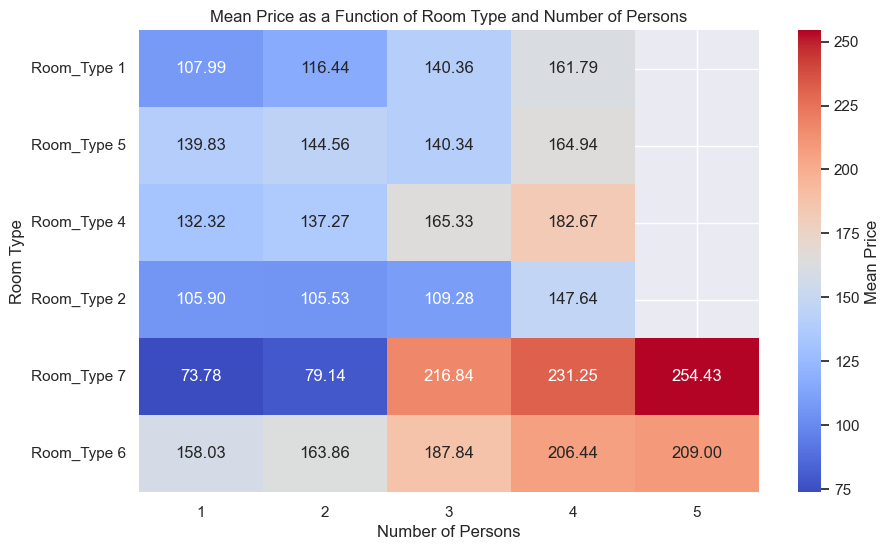

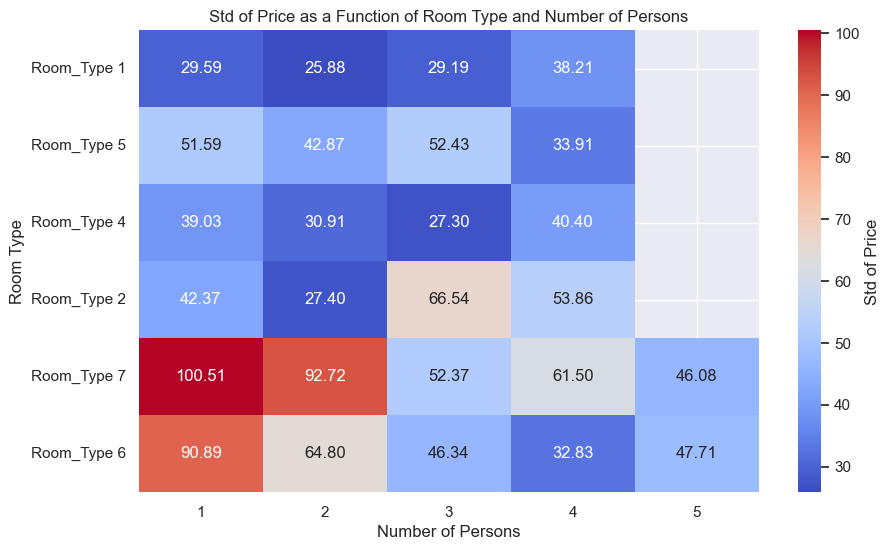

In [38]:
# Create a pivot table for prices
count_pivot_table = hotel_df.pivot_table(values='price', index='room_type', columns='n_persons', aggfunc=lambda x: len(x))
print(count_pivot_table)

# Create a pivot table with mean prices
mean_price_pivot_table = hotel_df.pivot_table(values='price', index='room_type', columns='n_persons', aggfunc='mean')

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(mean_price_pivot_table, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label': 'Mean Price'})
plt.title('Mean Price as a Function of Room Type and Number of Persons')
plt.xlabel('Number of Persons')
plt.ylabel('Room Type')

plt.show()

std_price_pivot_table = hotel_df.pivot_table(values='price', index='room_type', columns='n_persons', aggfunc='std')

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(std_price_pivot_table, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label': 'Std of Price'})
plt.title('Std of Price as a Function of Room Type and Number of Persons')
plt.xlabel('Number of Persons')
plt.ylabel('Room Type')

plt.show()




I saw that the price depends significantly on the type of room and the number of guests, and it is also distributed in a manner similar to a Gaussian distribution. Therefore, I calculated the average and variance for each combination of (room type, number of guests) and then corrected the missing values ​​by choosing a random number from the appropriate Gaussian distribution (there are a few cases where there are more than 4 guests, so it is difficult to rely on the expectancy and variance calculated in these cases Therefore I used the mean and variance of identical cases with 4 guests).

In [39]:
print(np.where(hotel_df['price']<0))
print(np.where(hotel_df['lead_time']<0))
print(np.where(hotel_df['price']==0))
print(np.where(hotel_df['lead_time']==0))

(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([   55,   239,   263,   288,   324,   327,   344,   353,   359,
         368,   398,   402,   410,   464,   517,   576,   629,   648,
         688,   692,   715,   740,   741,   789,   861,   914,   915,
         926,   930,   991,  1048,  1069,  1073,  1100,  1126,  1132,
        1174,  1180,  1187,  1190,  1194,  1215,  1287,  1345,  1349,
        1377,  1392,  1426,  1462,  1479,  1482,  1489,  1511,  1512,
        1565,  1573,  1580,  1586,  1593,  1663,  1691,  1755,  1765,
        1793,  1855,  2046,  2067,  2080,  2118,  2124,  2137,  2149,
        2204,  2218,  2228,  2264,  2280,  2310,  2357,  2361,  2387,
        2394,  2532,  2539,  2562,  2622,  2669,  2749,  2776,  2842,
        2856,  2858,  2864,  2871,  2936,  2958,  3019,  3030,  3035,
        3047,  3057,  3108,  3142,  3174,  3192,  3205,  3249,  3256,
        3279,  3298,  3314,  3334,  3338,  3362,  3406,  3411,  3480,
        354

In [40]:
# fix the last column because it doesn't statistically meaning
mean_price_pivot_table[5]=mean_price_pivot_table[4]
std_price_pivot_table[5]=std_price_pivot_table[4]

def fill_price(mean,std):
    return np.random.normal(mean, std)
    
missing_price_idx = hotel_df[hotel_df['price'].isna()==True].index
outlier_index = hotel_df[hotel_df['n_persons']>5].index
hotel_df.loc[outlier_index,'n_persons']=5
hotel_df.loc[missing_price_idx,'price'] = hotel_df.loc[missing_price_idx].apply(lambda row: fill_price(
    mean_price_pivot_table[row['n_persons']][row['room_type']],
    std_price_pivot_table[row['n_persons']][row['room_type']]) ,axis=1)
missing_price_idx = hotel_df[hotel_df['price'].isna()==True].index
missing_price_idx

Index([], dtype='int64')

##### fix lead time

In the lead_time variable I filled in the missing values ​​based on its distribution as analyzed above. I also used the fact that it depends on the variable is_canceled and I built a model that divides the data into two groups according to is_canceled and completes the values ​​randomly according to an exponential distribution whose statistics are taken from the appropriate group.

In [41]:
#fix lead time by groups according to expon dist
def fill_lead_time(locs, scales, is_canceled):  
    idx=np.int32(is_canceled)
    return expon.rvs(loc=locs[idx], scale=scales[idx])


lead_time_data = hotel_df[hotel_df['lead_time'].isna()==False][['lead_time','is_canceled']]
locs=[]
scales=[]
lead_time_data_1 = lead_time_data[lead_time_data['is_canceled']==False]['lead_time']
# Fit an exponential distribution to the data
loc, scale = expon.fit(lead_time_data_1)
print(loc,scale)
locs.append(loc)
scales.append(scale)
lead_time_data_2 = lead_time_data[lead_time_data['is_canceled']==True]['lead_time']
# Fit an exponential distribution to the data
loc, scale = expon.fit(lead_time_data_2)
print(loc,scale)
locs.append(loc)
scales.append(scale)

missing_lead_time_idx = hotel_df[hotel_df['lead_time'].isna()==True].index
hotel_df.loc[missing_lead_time_idx,'lead_time'] = hotel_df.loc[missing_lead_time_idx].apply(lambda row: fill_lead_time(locs,scales,row['is_canceled']),axis=1)
missing_lead_time_idx = hotel_df[hotel_df['lead_time'].isna()==True].index
missing_lead_time_idx

0.0 71.36538781855533
0.0 167.68693770641158


Index([], dtype='int64')

there is big gap between scales of the 2 groups, so it was good to divide the data by them

now check if there are minus values of price and lead time

In [42]:
print(np.where(hotel_df['price']<0))
print(np.where(hotel_df['lead_time']<0))

(array([10419, 22677], dtype=int64),)
(array([], dtype=int64),)


I'll fix the minus value by inverse it to plus (because maybe it was a keyboard mistake 

In [43]:
print(hotel_df.loc[hotel_df['price']<0,'price'])
hotel_df.loc[hotel_df['price']<0,'price'] = -hotel_df.loc[hotel_df['price']<0,'price']
print(np.where(hotel_df['price']<0))


10420   -2.17
22678   -3.05
Name: price, dtype: float64
(array([], dtype=int64),)


#### another corellation with target value (after preproccess)

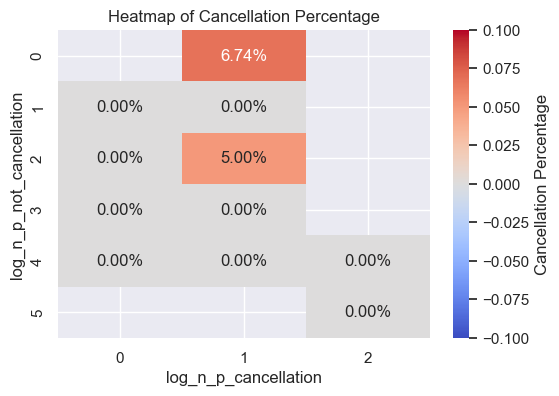

is_canceled
False    709
True      10
Name: count, dtype: int64
0.9860917941585535


C:\Users\Moshe\AppData\Local\Temp\ipykernel_16352\3455685952.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(repeated_cancels[0]/(repeated_cancels[1]+repeated_cancels[0]))


In [44]:
# Heatmap of repeated reservations - help to learn the relation between former cancellations and current cancellation
repeated_df = hotel_df[hotel_df['repeated']==True]

def plot_cancellation_heatmap(df, var1, var2):
    # Create a pivot table to calculate the percentage of 'is_canceled' = True for each combination
    pivot_table = pd.pivot_table(df, 
                                 values='is_canceled', 
                                 index=var1, 
                                 columns=var2, 
                                 aggfunc=lambda x: (x==True).mean() if len(x) >= 10 else None, 
                                 fill_value=np.inf)
    
    # Plot the heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(pivot_table, annot=True, fmt=".2%", cmap='coolwarm', cbar_kws={'label': 'Cancellation Percentage'})
    plt.title(f'Heatmap of Cancellation Percentage')
    plt.xlabel(var2)
    plt.ylabel(var1)
    plt.show()


plot_cancellation_heatmap(repeated_df, 'log_n_p_not_cancellation', 'log_n_p_cancellation')
repeated_cancels=(repeated_df['is_canceled'].value_counts())
print(repeated_cancels)
print(repeated_cancels[0]/(repeated_cancels[1]+repeated_cancels[0]))


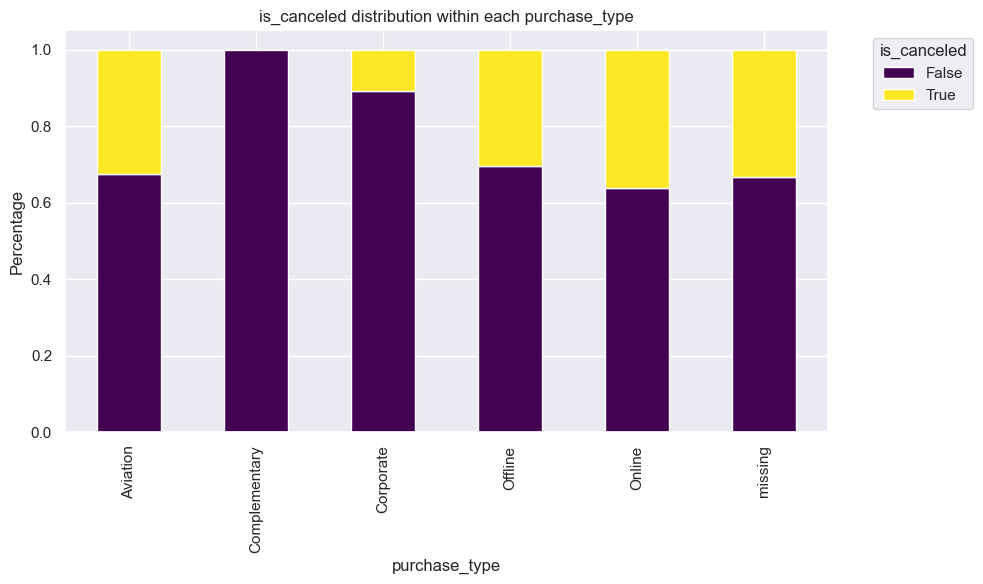

is_canceled
False    244
Name: count, dtype: int64
is_canceled
False    1104
True      134
Name: count, dtype: int64


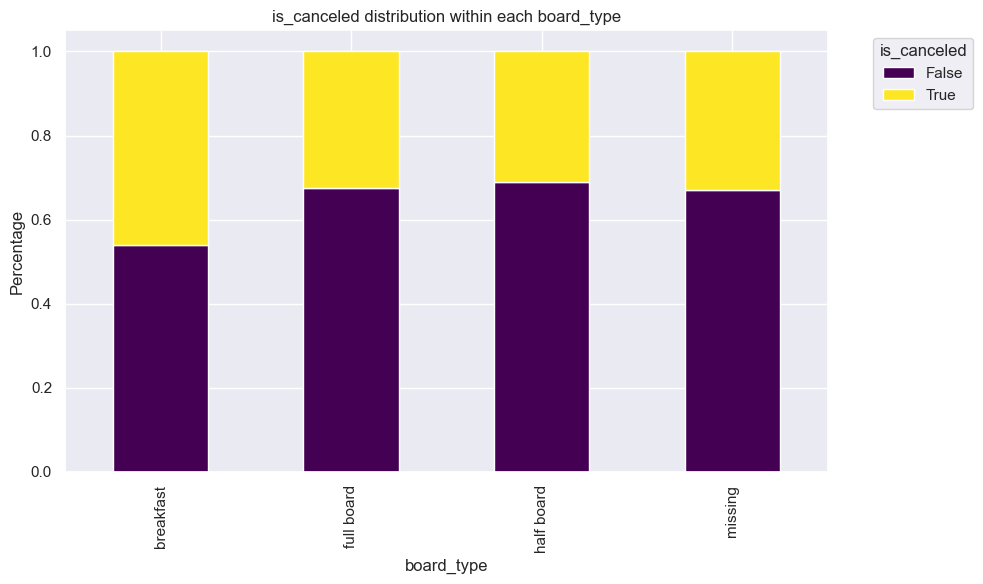

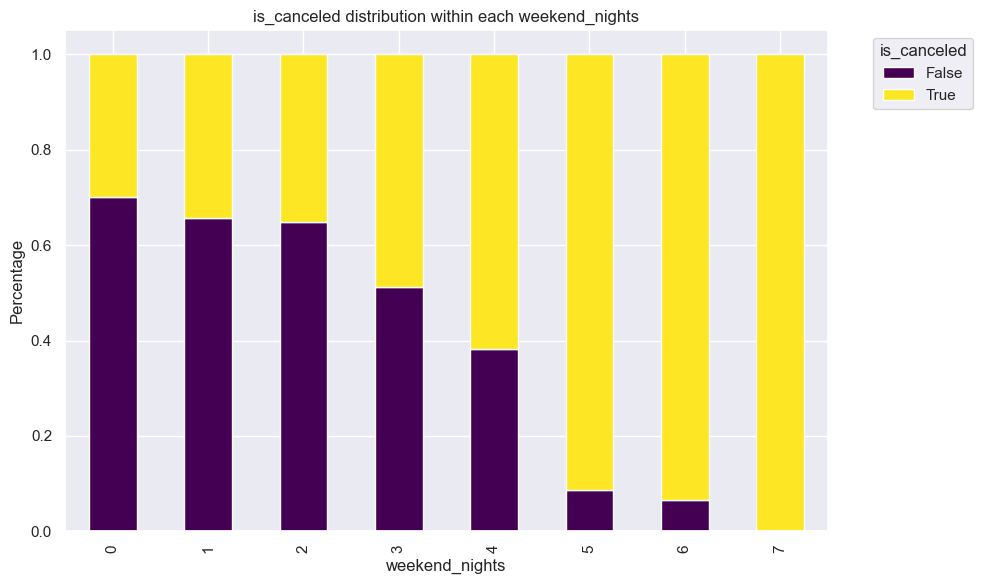

In [45]:
# Plot relationship between 'purchase_type' and 'is_canceled'
plotbar_categorical_relationship(hotel_df, 'purchase_type', 'is_canceled')
print(hotel_df.loc[hotel_df['purchase_type']=='Complementary','is_canceled'].value_counts())
print(hotel_df.loc[hotel_df['purchase_type']=='Corporate','is_canceled'].value_counts())

# Plot relationship between 'board_type' and 'is_canceled'
plotbar_categorical_relationship(hotel_df, 'board_type', 'is_canceled')

# Plot relationship between 'weekend_nights' and 'is_canceled'
plotbar_categorical_relationship(hotel_df, 'weekend_nights', 'is_canceled')


The last two cells show that 98.6 percent of repeat orders were not canceled, and that 100% of orders whose purchase type is complementary were not canceled.

Interestingly, regarding the repeat orders, I did not find a statistically significant difference between cases where there were many canceled orders and cases where there were many orders that were not canceled.

In any case, a small section can be drawn from this for the forecasting models - in the specific cases of repeat orders or complementary purchases, it is unlikely to find cancellations.

### New features
We can create a new feature for family size which combines Parch (parents/children's) and SibSp (siblings/spouses). This will enable us to drop Parch and SibSp from our datasets.

In [46]:
hotel_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27211 entries, 0 to 27212
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   ID                        27211 non-null  object        
 1   weekend_nights            27211 non-null  int64         
 2   week_nights               27211 non-null  int64         
 3   room_type                 27211 non-null  category      
 4   board_type                27211 non-null  object        
 5   n_adults                  27211 non-null  int64         
 6   n_less_12                 27211 non-null  int64         
 7   n_more_12                 27211 non-null  int64         
 8   booked_tour               27211 non-null  bool          
 9   n_requests                27211 non-null  int64         
 10  lead_time                 27211 non-null  float64       
 11  purchase_type             27211 non-null  object        
 12  n_p_cacellation        

#### children

In [47]:
hotel_df['With_children'] = 0
hotel_df.loc[hotel_df['n_children']>0, 'With_children'] = 1
hotel_df.groupby(['n_children','With_children']).size()

C:\Users\Moshe\AppData\Local\Temp\ipykernel_16352\1894773563.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hotel_df['With_children'] = 0


n_children  With_children
0           0                25167
1           1                 1216
2           1                  814
3           1                   13
10          1                    1
dtype: int64

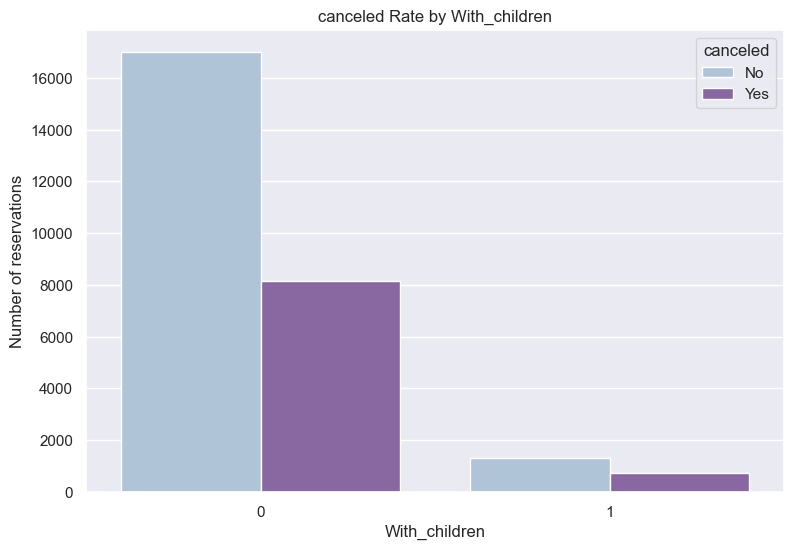

In [48]:
sns.countplot(x='With_children', hue='is_canceled', data=hotel_df, palette='BuPu')
plt.title('canceled Rate by With_children')
plt.xlabel('With_children')
plt.ylabel('Number of reservations')
plt.legend(title='canceled', labels=['No', 'Yes'])
plt.show()


In [49]:
print(hotel_df['n_adults'].value_counts(),'\n')
print(hotel_df['n_persons'].value_counts(),'\n')


n_adults
2    19565
1     5779
3     1749
0      104
4       14
Name: count, dtype: int64 

n_persons
2    17925
1     5668
3     2904
4      702
5       12
Name: count, dtype: int64 



In [50]:
hotel_df['n_adults_cat'] = hotel_df['n_adults']
hotel_df.loc[hotel_df['n_adults'] >2,'n_adults_cat'] = 3
hotel_df['n_persons_cat'] = hotel_df['n_persons']
hotel_df.loc[hotel_df['n_persons'] >3,'n_persons_cat'] = 4
print(hotel_df['n_adults_cat'].value_counts(),'\n')
print(hotel_df['n_persons_cat'].value_counts(),'\n')


n_adults_cat
2    19565
1     5779
3     1763
0      104
Name: count, dtype: int64 

n_persons_cat
2    17925
1     5668
3     2904
4      714
Name: count, dtype: int64 



C:\Users\Moshe\AppData\Local\Temp\ipykernel_16352\2887844551.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hotel_df['n_adults_cat'] = hotel_df['n_adults']
C:\Users\Moshe\AppData\Local\Temp\ipykernel_16352\2887844551.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hotel_df['n_persons_cat'] = hotel_df['n_persons']


#### season

as we have see, the cancellation rate is bigger in summer and smaller in winter. Those, create categorical variable accordingly

C:\Users\Moshe\AppData\Local\Temp\ipykernel_16352\3193937227.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hotel_df['season'] = hotel_df.apply(lambda row: classify_season(row['date1'],'obj'),axis = 1)
C:\Users\Moshe\AppData\Local\Temp\ipykernel_16352\3193937227.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hotel_df['season_cat'] =hotel_df.apply(lambda row: classify_season(row['date1'],'cat'),axis = 1)


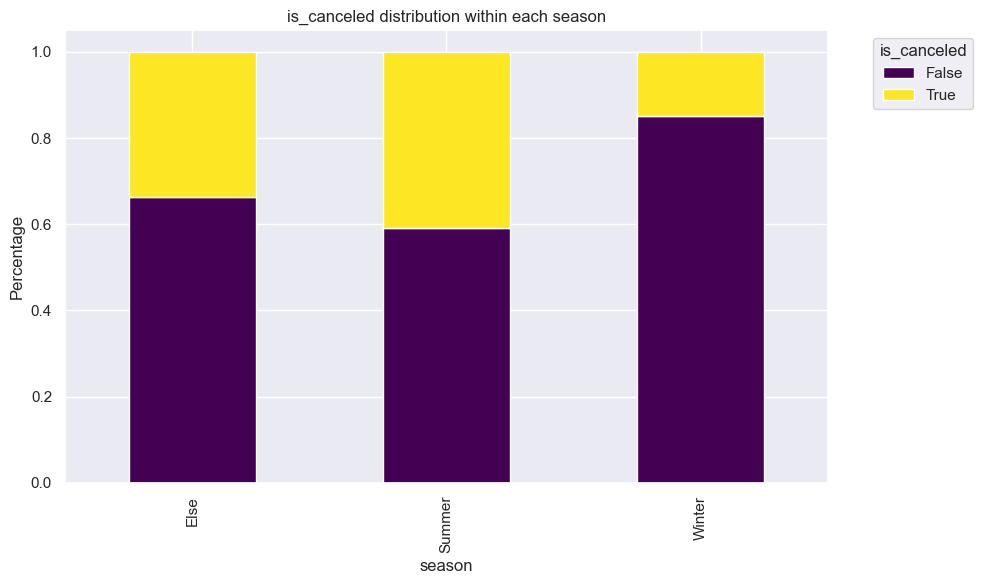

           date1  season
27198 2018-10-24    Else
27199 2017-10-31    Else
27200 2018-08-22  Summer
27201 2018-12-04  Winter
27202 2018-03-12    Else
27203 2018-12-03  Winter
27204 2018-04-21    Else
27205 2018-08-18  Summer
27206 2018-08-25  Summer
27207 2018-09-14    Else
27208 2018-07-18  Summer
27209 2018-02-24  Winter
27210 2018-04-15    Else
27211 2018-05-22    Else
27212 2017-07-17  Summer


In [51]:
# Function to classify seasons based on dates
def classify_season(date, type = 'obj'):
    month = date.month
    day = date.day

    if (month == 12 or month == 1 or month == 2):
        if type == 'cat':
            season = 0
        else:
            season = 'Winter'
    elif (month == 6 or month == 7 or month == 8):
        if type == 'cat':
            season = 2
        else:
            season = 'Summer'        
    else:
        if type == 'cat':
            season = 1
        else:
            season = 'Else'
    return season

# Apply the function to the 'date1' column and create a new column 'season'
hotel_df['season'] = hotel_df.apply(lambda row: classify_season(row['date1'],'obj'),axis = 1)
hotel_df['season_cat'] =hotel_df.apply(lambda row: classify_season(row['date1'],'cat'),axis = 1)

# Plot relationship between 'season' and 'is_canceled'
plotbar_categorical_relationship(hotel_df, 'season', 'is_canceled')

# Check the result
print(hotel_df[['date1', 'season']].tail(15))


#### nights

In [52]:
print(hotel_df['week_nights'].value_counts(),'\n')
print(hotel_df['weekend_nights'].value_counts(),'\n')
print(hotel_df['total_nights'].value_counts(),'\n')


week_nights
2     8556
1     7158
3     5875
4     2209
0     1812
5     1218
6      152
7       84
8       45
10      41
9       24
11      11
12       7
15       6
13       5
14       4
16       2
17       2
Name: count, dtype: int64 

weekend_nights
0    12620
1     7492
2     6856
3      115
4       89
5       23
6       15
7        1
Name: count, dtype: int64 

total_nights
3     7523
2     6373
1     4969
4     4394
5     1950
6      785
7      723
8      145
9       82
10      80
0       59
11      30
14      22
15      19
12      15
13      13
20       8
17       4
16       4
19       4
18       3
21       2
22       2
24       1
23       1
Name: count, dtype: int64 



In [53]:
hotel_df['week_nights_cat'] = hotel_df['week_nights']
hotel_df.loc[hotel_df['week_nights'] >5,'week_nights_cat'] = 6
hotel_df['week_nights_cat'].value_counts()

C:\Users\Moshe\AppData\Local\Temp\ipykernel_16352\396224131.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hotel_df['week_nights_cat'] = hotel_df['week_nights']


week_nights_cat
2    8556
1    7158
3    5875
4    2209
0    1812
5    1218
6     383
Name: count, dtype: int64

In [54]:
hotel_df['weekend_nights_cat'] = hotel_df['weekend_nights']
hotel_df.loc[hotel_df['weekend_nights'] >2,'weekend_nights_cat'] = 3
hotel_df['weekend_nights_cat'].value_counts()

C:\Users\Moshe\AppData\Local\Temp\ipykernel_16352\4118108721.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hotel_df['weekend_nights_cat'] = hotel_df['weekend_nights']


weekend_nights_cat
0    12620
1     7492
2     6856
3      243
Name: count, dtype: int64

In [55]:
hotel_df['total_nights_cat'] = hotel_df['total_nights']
hotel_df.loc[hotel_df['total_nights'] >5,'total_nights_cat'] = 6
hotel_df['total_nights_cat'].value_counts()

C:\Users\Moshe\AppData\Local\Temp\ipykernel_16352\3918602400.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hotel_df['total_nights_cat'] = hotel_df['total_nights']


total_nights_cat
3    7523
2    6373
1    4969
4    4394
5    1950
6    1943
0      59
Name: count, dtype: int64

#### category and more

In [56]:
hotel_df['board_type_cat'] = hotel_df['board_type'].astype('category').cat.codes
print(hotel_df.groupby(['board_type','board_type_cat']).size(),'\n')
hotel_df['purchase_type_cat'] = hotel_df['purchase_type'].astype('category').cat.codes
hotel_df.groupby(['purchase_type','purchase_type_cat']).size()

board_type  board_type_cat
breakfast   0                  1752
full board  1                  2697
half board  2                 14590
missing     3                  8172
dtype: int64 



C:\Users\Moshe\AppData\Local\Temp\ipykernel_16352\1813217642.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hotel_df['board_type_cat'] = hotel_df['board_type'].astype('category').cat.codes
C:\Users\Moshe\AppData\Local\Temp\ipykernel_16352\1813217642.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hotel_df['purchase_type_cat'] = hotel_df['purchase_type'].astype('category').cat.codes


purchase_type  purchase_type_cat
Aviation       0                       77
Complementary  1                      244
Corporate      2                     1238
Offline        3                     6499
Online         4                    14306
missing        5                     4847
dtype: int64

In [57]:
hotel_df['n_requests'].value_counts()

n_requests
0    14785
1     8595
2     3257
3      511
4       56
5        7
Name: count, dtype: int64

In [58]:
hotel_df['n_requests_cat'] = hotel_df['n_requests']
hotel_df.loc[hotel_df['n_requests']>3, 'n_requests_cat'] = 3
hotel_df['n_requests_cat'].value_counts()

C:\Users\Moshe\AppData\Local\Temp\ipykernel_16352\2897177725.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hotel_df['n_requests_cat'] = hotel_df['n_requests']


n_requests_cat
0    14785
1     8595
2     3257
3      574
Name: count, dtype: int64

### Discretization

#### price

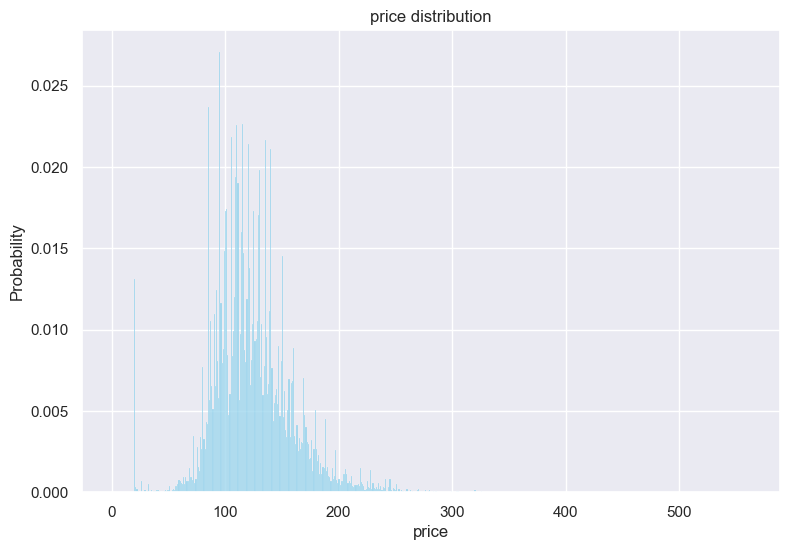

In [59]:
sns.histplot(data=hotel_df, x='price', color='skyblue', stat="probability", discrete=True)
plt.title('price distribution')
plt.xlabel('price')
plt.ylabel('Probability')
plt.show()

In [60]:
N = 9
hotel_df['price_bin'] = pd.cut(hotel_df['price'], bins=N, labels=False, include_lowest=True, right=False)

hotel_df['price_bin'].value_counts().sort_index()

C:\Users\Moshe\AppData\Local\Temp\ipykernel_16352\3478719276.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hotel_df['price_bin'] = pd.cut(hotel_df['price'], bins=N, labels=False, include_lowest=True, right=False)


price_bin
0      614
1    15173
2    10186
3     1144
4       82
5       11
8        1
Name: count, dtype: int64

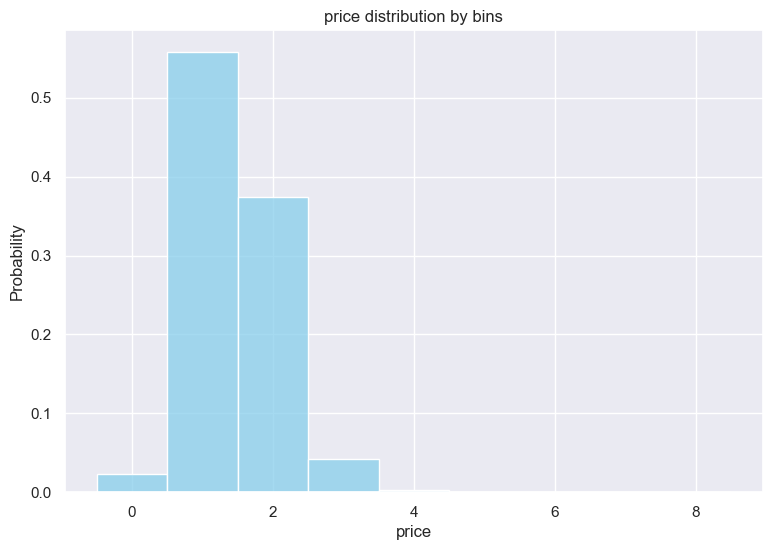

In [61]:
sns.histplot(data=hotel_df, x='price_bin', color='skyblue', stat="probability", discrete=True)
plt.title('price distribution by bins')
plt.xlabel('price')
plt.ylabel('Probability')
plt.show()

In [62]:
N = 5
hotel_df['price_bin_2'] = pd.qcut(hotel_df['price'], q=N, labels=False, duplicates='drop')

# Print the range of each bin
bins = pd.qcut(hotel_df['price'], q=N, duplicates='drop')
bin_ranges = bins.unique()
for i, bin_range in enumerate(sorted(bin_ranges)):
    print(f"Bin {i}: {bin_range.left} to {bin_range.right}")


Bin 0: 2.165 to 96.5
Bin 1: 96.5 to 111.583
Bin 2: 111.583 to 128.0
Bin 3: 128.0 to 148.856
Bin 4: 148.856 to 560.0


C:\Users\Moshe\AppData\Local\Temp\ipykernel_16352\846101313.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hotel_df['price_bin_2'] = pd.qcut(hotel_df['price'], q=N, labels=False, duplicates='drop')


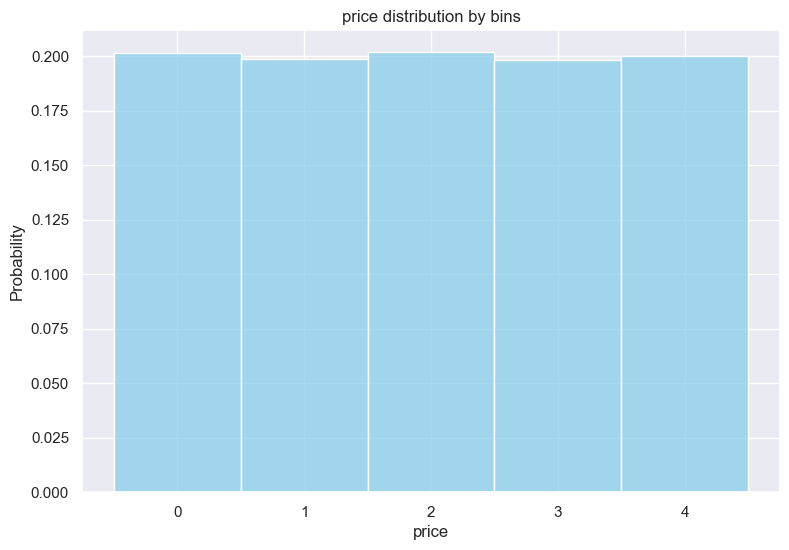

In [63]:
sns.histplot(data=hotel_df, x='price_bin_2', color='skyblue', stat="probability", discrete=True)
plt.title('price distribution by bins')
plt.xlabel('price')
plt.ylabel('Probability')
plt.show()

C:\Users\Moshe\AppData\Local\Temp\ipykernel_16352\4208251837.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hotel_df['price_bin_3'] = pd.cut(hotel_df['price'], bins=bins, labels=False, include_lowest=True)


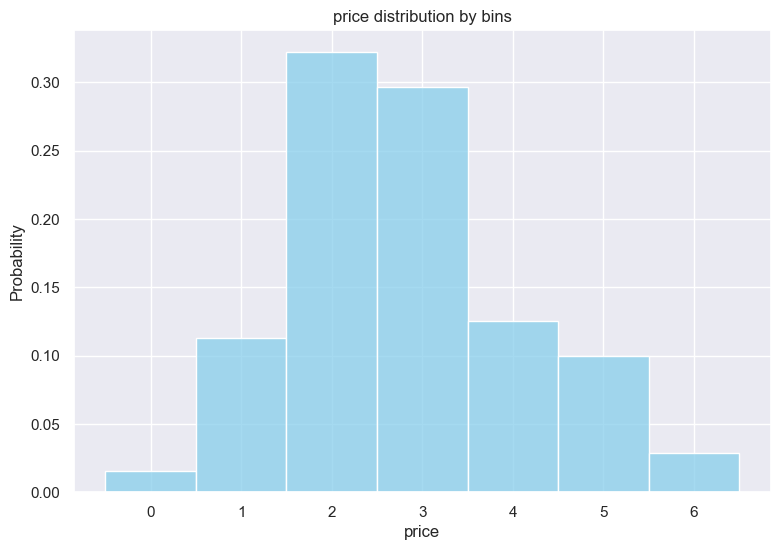

price_bin_3
0     432
1    3066
2    8759
3    8058
4    3412
5    2712
6     772
Name: count, dtype: int64

In [64]:
# resonable bins - after observation on the probability graph
bins = [-float('inf'), 40, 90, 115, 140, 160, 200, float('inf')]
hotel_df['price_bin_3'] = pd.cut(hotel_df['price'], bins=bins, labels=False, include_lowest=True)
sns.histplot(data=hotel_df, x='price_bin_3', color='skyblue', stat="probability", discrete=True)
plt.title('price distribution by bins')
plt.xlabel('price')
plt.ylabel('Probability')
plt.show()
hotel_df['price_bin_3'].value_counts().sort_index()

#### lead time

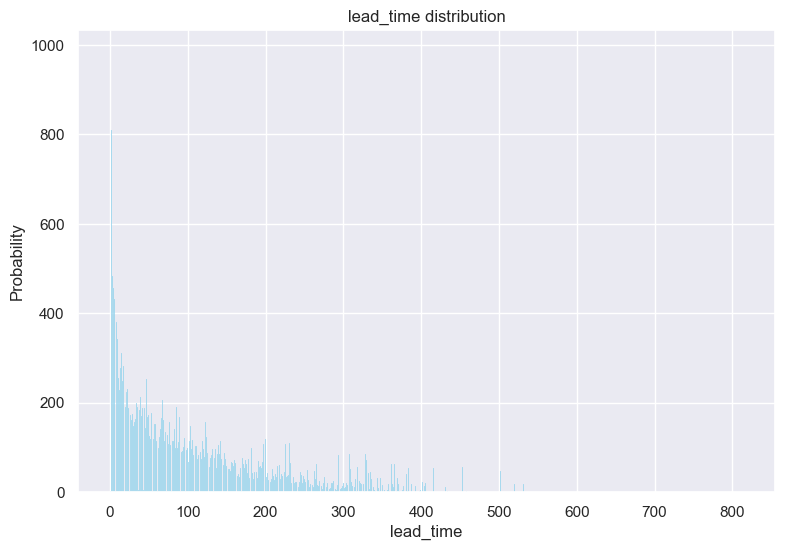

In [65]:
sns.histplot(data=hotel_df, x='lead_time', color='skyblue', stat="frequency", discrete=True)
plt.title('lead_time distribution')
plt.xlabel('lead_time')
plt.ylabel('Probability')
plt.show()

C:\Users\Moshe\AppData\Local\Temp\ipykernel_16352\1053934707.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hotel_df['log_lead_time'] = np.int32(np.emath.logn(base, hotel_df['lead_time']+1))


log_lead_time
11    3671
12    3349
10    3117
13    2813
9     2784
14    1941
8     1749
7     1585
6     1321
5     1062
0      984
3      939
4      889
2      810
15     194
1        2
16       1
Name: count, dtype: int64
log base: 1.5


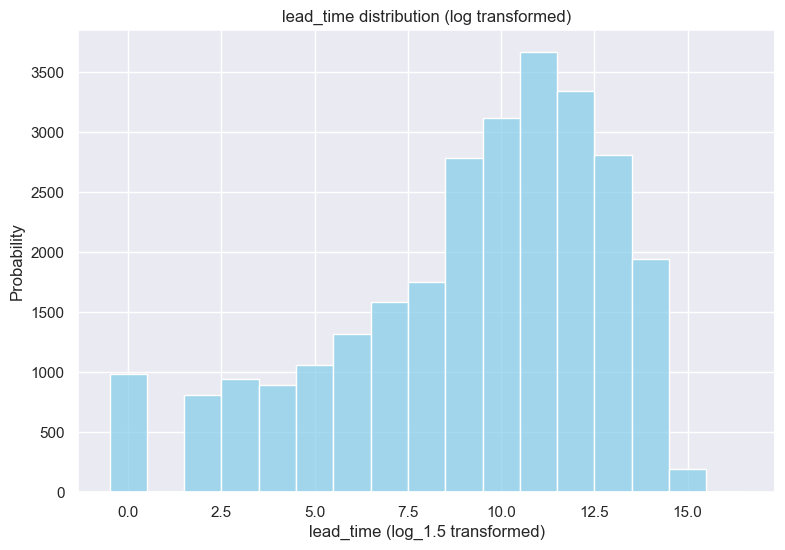

In [66]:
base = 1.5
hotel_df['log_lead_time'] = np.int32(np.emath.logn(base, hotel_df['lead_time']+1))
print(hotel_df['log_lead_time'].value_counts())
print("log base:", base)

sns.histplot(data=hotel_df, x='log_lead_time', color='skyblue', stat="frequency", discrete=True)
plt.title('lead_time distribution (log transformed)')
plt.xlabel(f'lead_time (log_{base} transformed)')
plt.ylabel('Probability')
plt.show()



the value 'log_lead_time'=9 is outlier. fix it:

In [67]:
hotel_df['lead_time_cat'] = hotel_df['log_lead_time']
hotel_df.loc[hotel_df['log_lead_time'] == 16, 'lead_time_cat'] = 15
hotel_df.loc[hotel_df['log_lead_time'] == 1, 'lead_time_cat'] = 0

C:\Users\Moshe\AppData\Local\Temp\ipykernel_16352\3900656108.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hotel_df['lead_time_cat'] = hotel_df['log_lead_time']


In [68]:
N = 10
hotel_df['lead_time_cat_2'] = pd.qcut(hotel_df['lead_time'], q=N, labels=False, duplicates='drop')

# Print the range of each bin
bins = pd.qcut(hotel_df['lead_time'], q=N, duplicates='drop')
bin_ranges = bins.unique()
for i, bin_range in enumerate(sorted(bin_ranges)):
    print(f"Bin {i}: {bin_range.left} to {bin_range.right}")


Bin 0: -0.001 to 4.0
Bin 1: 4.0 to 14.0
Bin 2: 14.0 to 29.0
Bin 3: 29.0 to 47.0
Bin 4: 47.0 to 69.0
Bin 5: 69.0 to 96.0
Bin 6: 96.0 to 131.0
Bin 7: 131.0 to 182.0
Bin 8: 182.0 to 256.0
Bin 9: 256.0 to 813.471


C:\Users\Moshe\AppData\Local\Temp\ipykernel_16352\206211496.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hotel_df['lead_time_cat_2'] = pd.qcut(hotel_df['lead_time'], q=N, labels=False, duplicates='drop')


Text(0.5, 1.0, 'Spearman correlation')

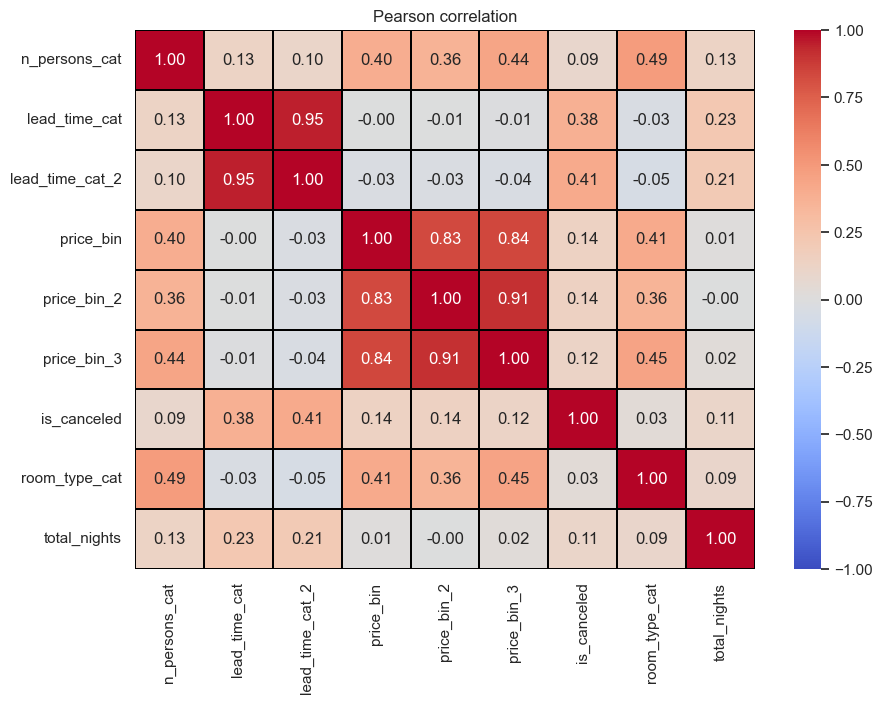

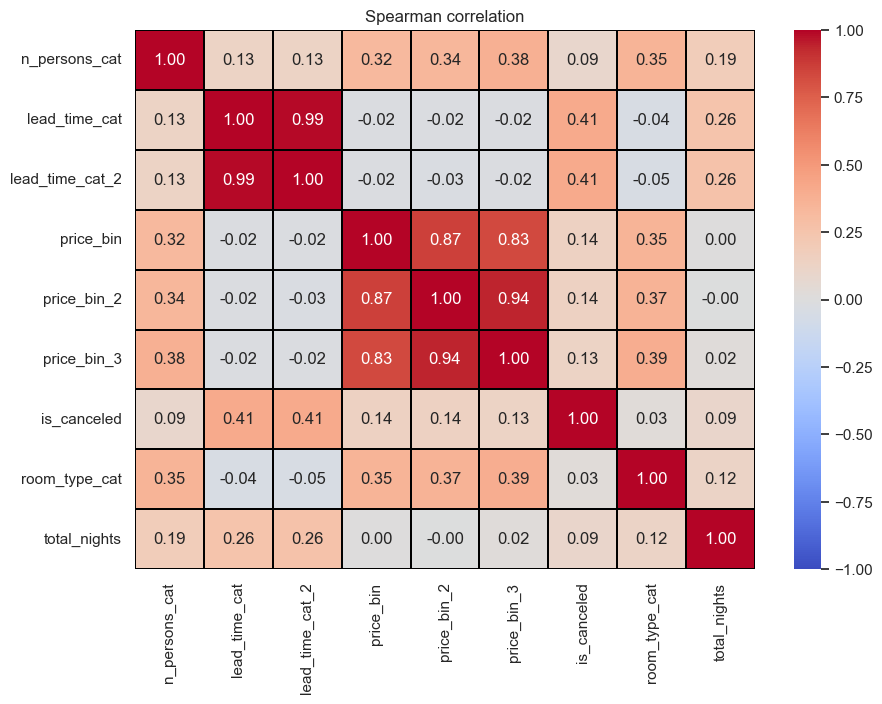

In [69]:
# mini heatmap
cat_columns = ['n_persons_cat',
       'lead_time_cat', 'lead_time_cat_2', 'price_bin', 'price_bin_2', 'price_bin_3', 'is_canceled', 'room_type_cat', 'total_nights'] 

display(HTML(f'<span style="font-size:24px; color:black; font-weight:bold;">Heatmap of meaning correlated variables:'))
f, ax = plt.subplots(figsize=(10, 7))
ax = sns.heatmap(hotel_df[cat_columns].corr(method = 'pearson'), annot = True, vmin=-1, vmax=1, center= 0,
            cmap= 'coolwarm', linewidths=0.2, fmt='.2f', linecolor='black')
ax.set_title('Pearson correlation')
f, ax = plt.subplots(figsize=(10, 7))
ax = sns.heatmap(hotel_df[cat_columns].corr(method = 'spearman'), annot = True, vmin=-1, vmax=1, center= 0,
            cmap= 'coolwarm', linewidths=0.2, fmt='.2f', linecolor='black')
ax.set_title('Spearman correlation')


## Building models - decision tree

### Prepare data 

In [229]:
print(hotel_df.columns)
hotel_df.info()

Index(['ID', 'weekend_nights', 'week_nights', 'room_type', 'board_type',
       'n_adults', 'n_less_12', 'n_more_12', 'booked_tour', 'n_requests',
       'lead_time', 'purchase_type', 'n_p_cacellation', 'n_p_not_cacellation',
       'repeated', 'price', 'date', 'is_canceled', 'n_children', 'n_persons',
       'total_nights', 'date1', 'month', 'day', 'log_n_p_cancellation',
       'log_n_p_not_cancellation', 'room_type_cat', 'With_children',
       'n_adults_cat', 'n_persons_cat', 'season', 'season_cat',
       'week_nights_cat', 'weekend_nights_cat', 'total_nights_cat',
       'board_type_cat', 'purchase_type_cat', 'n_requests_cat', 'price_bin',
       'price_bin_2', 'price_bin_3', 'log_lead_time', 'lead_time_cat',
       'lead_time_cat_2'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 27211 entries, 0 to 27212
Data columns (total 44 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----        

In [230]:
columns_for_decition_tree = ['room_type_cat', 'With_children',
       'n_adults_cat', 'n_persons_cat', 'season_cat',
       'week_nights_cat', 'weekend_nights_cat', 'total_nights_cat', 'month', 'day', 
       'price_bin_2', 'price_bin_3', 'lead_time_cat',
       'booked_tour', 'n_requests_cat',
       'board_type_cat', 'purchase_type_cat', 'log_n_p_cancellation',
       'log_n_p_not_cancellation', 'repeated', 'is_canceled']


Split the data set to X and y.<br>
X for the features and y for the target. 


In [231]:
X = hotel_df[columns_for_decition_tree].drop('is_canceled', axis=1)
y = hotel_df['is_canceled']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1) 

### Create model

To evaluate the model we split the data set to train set and test set (= validation).<br>
We train the model <b> only </b> on the train set and evaluate it on the test set.

In [232]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(random_state=1) 

# Train Decision Tree Classifer 
clf = clf.fit(X_train,y_train)

# Predict the label
y_pred = clf.predict(X_test)
# y_pred

### preliminary results

#### Confusion matrix


In [233]:
print(f"accuracy of model : {metrics.accuracy_score(y_test, y_pred)}")

pd.DataFrame(metrics.confusion_matrix(y_test, y_pred))


accuracy of model : 0.8196383948258121


0     1
0  3942   620
1   607  1634

#### Predict the labels for the train set

In [234]:
y_train_pred = clf.predict(X_train)
print(metrics.accuracy_score(y_train, y_train_pred))
pd.DataFrame(metrics.confusion_matrix(y_train, y_train_pred))

0.9929439435515484


0     1
0  13707    26
1    118  6557

### Improve model

#### improve by changing tree size
Changing hyper-parameters effects the complexity of the model. Too complex (=deep) model will overfit, too simple (=shallow) model will underfit.<br>
Configure a better model by limits the size of the tree.


In [235]:
clf2 = DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=15,
                              min_samples_split=30, min_samples_leaf=10, random_state=1) 

clf2 = clf2.fit(X_train,y_train)

In [236]:
#train
print("train set")
y_train_pred2 = clf2.predict(X_train)
print(metrics.accuracy_score(y_train, y_train_pred2))
pd.DataFrame(metrics.confusion_matrix(y_train, y_train_pred2))

train set
0.8706879655037241


0     1
0  12714  1019
1   1620  5055

In [237]:
# test
print("test set")

y_pred2 = clf2.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred2))
pd.DataFrame(metrics.confusion_matrix(y_test, y_pred2))

test set
0.8333088343377921


0     1
0  4111   451
1   683  1558

#### Improve by basic tune parameters

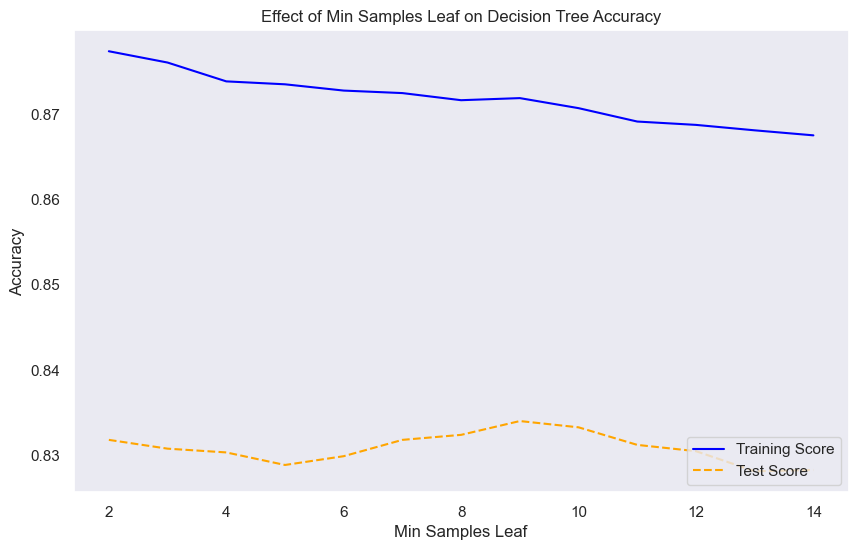

In [238]:
train_scores, test_scores = [], []

for k in range(2, 15):
    clf3 = DecisionTreeClassifier(criterion='entropy', splitter='best', 
                                  min_samples_split=30, min_samples_leaf=k,
                                  max_depth=15, random_state=1) 
    clf3.fit(X_train, y_train)
    train_scores.append(clf3.score(X_train, y_train))
    test_scores.append(clf3.score(X_test, y_test))
    
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(range(2, 15), train_scores, linestyle='-', color='blue')
ax.plot(range(2, 15), test_scores, linestyle='--', color='orange')

ax.set_xlabel('Min Samples Leaf')
ax.set_ylabel('Accuracy')
ax.set_title('Effect of Min Samples Leaf on Decision Tree Accuracy')

ax.legend(['Training Score', 'Test Score'], loc='lower right')
ax.grid()

plt.show()

In [239]:
pd.options.display.float_format = '{:.4f}'.format

test_scores_df = pd.DataFrame({
    'min_leaf': range(2, 15),
    'score': test_scores})
test_scores_df= test_scores_df.sort_values('score', ascending=False)
test_scores_df

min_leaf  score
7          9 0.8340
8         10 0.8333
6          8 0.8324
0          2 0.8318
5          7 0.8318
9         11 0.8313
1          3 0.8308
10        12 0.8305
2          4 0.8304
4          6 0.8299
3          5 0.8289
12        14 0.8283
11        13 0.8282

#### Changing the splits to be by category

In [240]:
dummies_col = []
for col in hotel_df[columns_for_decition_tree]:
    unique_values = len(hotel_df[col].unique())
    if 2 < unique_values < 8 :
        dummies_col.append(col)

X_dummies = pd.get_dummies(data=X, columns=dummies_col).astype(float)

X_dummies.head()


With_children   month     day  lead_time_cat  booked_tour  repeated  \
0         0.0000 11.0000 28.0000         8.0000       0.0000    0.0000   
1         0.0000 11.0000  3.0000        14.0000       0.0000    0.0000   
2         0.0000  5.0000  6.0000        12.0000       0.0000    0.0000   
3         0.0000  9.0000 26.0000        15.0000       0.0000    0.0000   
4         1.0000 10.0000 19.0000         8.0000       0.0000    0.0000   

   room_type_cat_0  room_type_cat_1  room_type_cat_2  room_type_cat_3  ...  \
0           1.0000           0.0000           0.0000           0.0000  ...   
1           1.0000           0.0000           0.0000           0.0000  ...   
2           0.0000           0.0000           1.0000           0.0000  ...   
3           1.0000           0.0000           0.0000           0.0000  ...   
4           0.0000           0.0000           1.0000           0.0000  ...   

   log_n_p_cancellation_0  log_n_p_cancellation_1  log_n_p_cancellation_2  \
0                  1.0000                  0.0000                  0.0000   
1                  1.0000                  0.0000                  0.0000   
2                  1.0000                  0.0000                  0.0000   
3                  1.0000                  0.0000                  0.0000   
4                  1.0000                  0.0000                  0.0000   

   log_n_p_cancellation_3  log_n_p_not_cancellation_0  \
0                  0.0000                      1.0000   
1                  0.0000                      1.0000   
2                  0.0000                      1.0000   
3                  0.0000                      1.0000   
4                  0.0000                      1.0000   

   log_n_p_not_cancellation_1  log_n_p_not_cancellation_2  \
0                      0.0000                      0.0000   
1                      0.0000                      0.0000   
2                      0.0000                      0.0000   
3                      0.0000                      0.0000   
4                      0.0000                      0.0000   

   log_n_p_not_cancellation_3  log_n_p_not_cancellation_4  \
0                      0.0000                      0.0000   
1                      0.0000                      0.0000   
2                      0.0000                      0.0000   
3                      0.0000                      0.0000   
4                      0.0000                      0.0000   

   log_n_p_not_cancellation_5  
0                      0.0000  
1                      0.0000  
2                      0.0000  
3                      0.0000  
4                      0.0000  

[5 rows x 77 columns]

In [241]:
X_train_d, X_test_d, y_train, y_test = train_test_split(X_dummies, y, test_size=0.25, random_state=1) 

In [242]:
clf3 = DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=15,
                              min_samples_split=30, min_samples_leaf=5, random_state=1) 

clf3 = clf3.fit(X_train_d,y_train)

In [243]:
y_pred3 = clf3.predict(X_test_d)
print(metrics.accuracy_score(y_test, y_pred3))
pd.DataFrame(metrics.confusion_matrix(y_test, y_pred3))

0.8333088343377921


0     1
0  4105   457
1   677  1564

In [244]:
# Get the feature importances for full tree
importances = clf3.feature_importances_
feature_importances = pd.DataFrame({'Feature': X_dummies.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print(feature_importances.head(10))

                 Feature  Importance
3          lead_time_cat      0.3189
53      n_requests_cat_0      0.0916
1                  month      0.0786
65   purchase_type_cat_4      0.0728
2                    day      0.0531
66   purchase_type_cat_5      0.0297
44         price_bin_2_3      0.0294
64   purchase_type_cat_3      0.0282
54      n_requests_cat_1      0.0169
30  weekend_nights_cat_0      0.0168


### Tuning and compare
Now I'll do tuning on 3 parameters simultaneusly and compare best results with the current classifier

In [245]:
current_clf = clf3
tunned_clf = DecisionTreeClassifier(criterion='entropy', splitter='best', random_state=1)

In [88]:

min_split_range = range(10,100,5)
min_leaf_range = range(1,15)
max_depth_range = range(2,30)
param_grid = dict(min_samples_split=min_split_range, min_samples_leaf=min_leaf_range, max_depth=max_depth_range, criterion=['entropy','gini'])

cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=1)
dcntr_random = RandomizedSearchCV(estimator = tunned_clf, param_distributions = param_grid, n_iter = 100, cv = 8,
                                verbose=2, random_state = 1, n_jobs = -1)

dcntr_random.fit(X_dummies, y)

print(
    "The best parameters are %s with a score of %0.2f"
    % (dcntr_random.best_params_, dcntr_random.best_score_)
)

Fitting 8 folds for each of 100 candidates, totalling 800 fits
The best parameters are {'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 14, 'criterion': 'entropy'} with a score of 0.84


In [89]:
cv_results = dcntr_random.cv_results_

# Extract and display mean test scores (accuracy) for each combination of parameters
#for mean_score, params in zip(cv_results['mean_test_score'], cv_results['params']):
#    print(f"Parameters: {params}, Accuracy: {mean_score:.4f}")

In [90]:
min_split_range = range(17,24)
min_leaf_range = range(2,8)
max_depth_range = range(11,17)
param_grid = dict(min_samples_split=min_split_range, min_samples_leaf=min_leaf_range, max_depth=max_depth_range, criterion=['entropy'])

cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(tunned_clf, param_grid=param_grid, cv=cv)
grid.fit(X, y)

print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)

The best parameters are {'criterion': 'entropy', 'max_depth': 14, 'min_samples_leaf': 2, 'min_samples_split': 18} with a score of 0.84


In [ ]:
X_dummies = X_dummies.to_numpy()
y=y.to_numpy()


In [96]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)

cm_a, cm_b = [], []
accuracy_a, accuracy_b = [], []
recall_a, recall_b = [], []
precision_a, precision_b = [], []
best_random = grid.best_estimator_

for train_index, test_index in kf.split(X):

    X_train, X_test = X_dummies[train_index], X_dummies[test_index]
    y_train, y_test = y[train_index], y[test_index]
 
    current_clf.fit(X_train, y_train)
    best_random.fit(X_train, y_train)
    
    y_pred_a = current_clf.predict(X_test)
    y_pred_b = best_random.predict(X_test)

    cm_a.append(metrics.confusion_matrix(y_test, y_pred_a))
    cm_b.append(metrics.confusion_matrix(y_test, y_pred_b))
    accuracy_a.append(metrics.accuracy_score(y_test, y_pred_a))
    accuracy_b.append(metrics.accuracy_score(y_test, y_pred_b))
    recall_a.append(metrics.recall_score(y_test, y_pred_a))
    recall_b.append(metrics.recall_score(y_test, y_pred_b))
    precision_a.append(metrics.precision_score(y_test, y_pred_a))
    precision_b.append(metrics.precision_score(y_test, y_pred_b))
    

In [97]:
X = X_dummies


clf_list = [current_clf,best_random]
result_dict ={}
cm_dict, auc_dict = {}, {}
kf = KFold(n_splits=10, shuffle=True, random_state=1) #for cross validation
k = 0
for train_index, test_index in kf.split(X):
    k+=1
    print("------",k,"------")
    # split to train and test
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    for clf in clf_list:
        # train the model and make a prediction
        clf.fit(X_train,y_train)
        y_pred = clf.predict(X_test)
        accuracy = metrics.accuracy_score(y_test, y_pred)
        precision = metrics.precision_score(y_test,y_pred)
        y_probs = clf.predict_proba(X_test) # probability prediction
        fpr, tpr, _ = metrics.roc_curve(y_test, y_probs[:,1])
        auc = metrics.auc(fpr, tpr)
        # save the results
        clf_dict = result_dict.get(clf, {})
        accuracy_list = clf_dict.get('accuracy',[])
        accuracy_list.append(accuracy)
        clf_dict['accuracy'] = accuracy_list
        precision_list = clf_dict.get('precision',[])
        precision_list.append(precision)
        clf_dict['precision'] = precision_list
        auc_list = clf_dict.get('auc',[])
        auc_list.append(auc)
        clf_dict['auc'] = auc_list
        result_dict[clf] = clf_dict
#         auc_list = auc_dict.get(clf,[])
#         auc_list.append(auc)
#         auc_dict[clf] = auc_list
        # print the results
        print("Classifier: ", clf)
        print("AUC " ,auc)
        print("Accuracy: ", metrics.accuracy_score(y_test, y_pred))

------ 1 ------
Classifier:  DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=5,
                       min_samples_split=30, random_state=1)
AUC  0.8952789825342866
Accuracy:  0.8332108743570904
Classifier:  DecisionTreeClassifier(criterion='entropy', max_depth=14, min_samples_leaf=2,
                       min_samples_split=18, random_state=1)
AUC  0.889425331145235
Accuracy:  0.8321087435709037
------ 2 ------
Classifier:  DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=5,
                       min_samples_split=30, random_state=1)
AUC  0.8905774728486905
Accuracy:  0.8397647923557515
Classifier:  DecisionTreeClassifier(criterion='entropy', max_depth=14, min_samples_leaf=2,
                       min_samples_split=18, random_state=1)
AUC  0.890492808471876
Accuracy:  0.8397647923557515
------ 3 ------
Classifier:  DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=5,
                       min_samples_spli

In [98]:
for clf in clf_list:
    print(clf)
    accuracy_list = result_dict[clf]['accuracy']
    print("mean accuracy: ", np.mean(accuracy_list))
    precision_list = result_dict[clf]['precision']
    print("mean precision: ", np.mean(precision_list))
    auc_list = result_dict[clf]['auc']
    print("mean auc: ", np.mean(auc_list))

DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=5,
                       min_samples_split=30, random_state=1)
mean accuracy:  0.8351035203647793
mean precision:  0.7739702002923928
mean auc:  0.8946214313306857
DecisionTreeClassifier(criterion='entropy', max_depth=14, min_samples_leaf=2,
                       min_samples_split=18, random_state=1)
mean accuracy:  0.8328984892045728
mean precision:  0.7699160632940031
mean auc:  0.8901719390946775


In [104]:
from scipy.stats import ttest_rel
ttest,pval = ttest_rel(result_dict[best_random]['accuracy'], result_dict[current_clf]['accuracy'])
print("p-value:" , pval)
if pval<0.05:
    print("reject null hypothesis")
else:
    print("accept null hypothesis")

p-value: 0.05543100450483464
accept null hypothesis


In [214]:
best_decision_tree = current_clf
best_decision_tree

DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=5,
                       min_samples_split=30, random_state=1)

## Building models - SVM

The algorithm classifies data by finding an optimal line or hyperplane that maximizes the distance between each class in an N-dimensional space. <br>
Hyperparameter:
- C: Regularization, a smaller value of C creates a small-margin hyperplane and a larger value of C creates a larger-margin hyperplane.
- Kernel: The function that used to transform the original training data into a higher dimension.

### Create model and preliminary results

In [107]:
columns_for_svm = ['room_type_cat', 'With_children',
       'n_adults_cat', 'n_persons_cat', 'season_cat',
       'week_nights_cat', 'weekend_nights_cat', 'total_nights_cat', 'month', 'day', 
       'price_bin_3', 'lead_time_cat_2',
       'booked_tour', 'n_requests_cat',
       'board_type_cat', 'purchase_type_cat', 'repeated', 'is_canceled']
X = hotel_df[columns_for_svm].drop('is_canceled', axis=1)
y = hotel_df['is_canceled']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1) 

In [108]:
clf_a = svm.SVC(kernel='rbf', C=0.9, probability=True)
clf_a.fit(X_train, y_train)
y_pred = clf_a.predict(X_test)
print(pd.DataFrame(metrics.confusion_matrix(y_test, y_pred)))
print(metrics.classification_report(y_test,y_pred))

      0     1
0  4097   465
1  1010  1231
              precision    recall  f1-score   support

       False       0.80      0.90      0.85      4562
        True       0.73      0.55      0.63      2241

    accuracy                           0.78      6803
   macro avg       0.76      0.72      0.74      6803
weighted avg       0.78      0.78      0.77      6803



#### confusion matrix and present ROC

In [ ]:
# confussion matrix
y_pred_a = clf_a.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred_a))
pd.DataFrame(metrics.confusion_matrix(y_test, y_pred_a))

In [ ]:
y_probs_a = clf_a.predict_proba(X_test) # probability prediction
fpr_a, tpr_a, threshold = metrics.roc_curve(y_test, y_probs_a[:,1])
auc_a = metrics.auc(fpr_a, tpr_a)
plt.figure()
plt.plot(fpr_a, tpr_a, color='darkorange', label='ROC curve (area = %0.2f)' %  auc_a)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate  (1-Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.show()

### Normalize data

In [109]:
scaler = MinMaxScaler()
columns_to_mm_scale = ['day', 'month', 'date1', 'total_nights_cat', 'With_children',
       'n_adults_cat', 'n_persons_cat', 'season_cat',
       'week_nights_cat', 'weekend_nights_cat', 'total_nights_cat', 'month', 'day', 
       'price', 'price_bin_3', 'lead_time', 'lead_time_cat',
       'n_requests_cat']
new_hotel_df = hotel_df[['is_canceled']]
for col in columns_to_mm_scale:
    scaler.fit(pd.DataFrame(hotel_df[col]))
    new_col = col+'_min_max'
    new_hotel_df[new_col] = scaler.transform(pd.DataFrame(hotel_df[col]))*2-1

new_hotel_df.head(10)

C:\Users\Moshe\AppData\Local\Temp\ipykernel_16352\2513569206.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_hotel_df[new_col] = scaler.transform(pd.DataFrame(hotel_df[col]))*2-1
C:\Users\Moshe\AppData\Local\Temp\ipykernel_16352\2513569206.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_hotel_df[new_col] = scaler.transform(pd.DataFrame(hotel_df[col]))*2-1
C:\Users\Moshe\AppData\Local\Temp\ipykernel_16352\2513569206.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

is_canceled  day_min_max  month_min_max  date1_min_max  \
0        False       0.8000         0.8182         0.8881   
1         True      -0.8667         0.8182         0.8034   
2        False      -0.6667        -0.2727         0.1898   
3         True       0.6667         0.4545         0.6746   
4        False       0.2000         0.6364        -0.4847   
5         True       0.2667         1.0000         0.9627   
6        False       0.8000        -0.2727         0.2644   
7        False       0.7333        -0.6364         0.0542   
8        False       0.3333         0.6364         0.7593   
9        False       0.0000        -0.0909         0.3288   

   total_nights_cat_min_max  With_children_min_max  n_adults_cat_min_max  \
0                    1.0000                -1.0000                0.3333   
1                    0.0000                -1.0000                0.3333   
2                   -0.3333                -1.0000               -0.3333   
3                    0.0000                -1.0000                0.3333   
4                    0.3333                 1.0000                0.3333   
5                   -0.3333                -1.0000                0.3333   
6                    1.0000                -1.0000                1.0000   
7                    0.6667                -1.0000                0.3333   
8                   -0.3333                -1.0000                0.3333   
9                    0.0000                -1.0000                0.3333   

   n_persons_cat_min_max  season_cat_min_max  week_nights_cat_min_max  \
0                -0.3333              0.0000                   0.6667   
1                -0.3333              0.0000                   0.0000   
2                -1.0000              0.0000                  -0.3333   
3                -0.3333              0.0000                  -0.3333   
4                 0.3333              0.0000                   0.0000   
5                -0.3333             -1.0000                  -0.3333   
6                 0.3333              0.0000                   0.3333   
7                -0.3333              0.0000                   0.0000   
8                -0.3333              0.0000                  -0.3333   
9                -0.3333              1.0000                   0.0000   

   weekend_nights_cat_min_max  price_min_max  price_bin_3_min_max  \
0                     -0.3333        -0.6191              -0.3333   
1                     -1.0000        -0.4291               0.6667   
2                     -1.0000        -0.5155               0.0000   
3                     -0.3333        -0.5524               0.0000   
4                     -0.3333        -0.6134              -0.3333   
5                     -1.0000        -0.6553              -0.3333   
6                      0.3333        -0.5653               0.0000   
7                      0.3333        -0.7249              -0.6667   
8                     -1.0000        -0.5173               0.0000   
9                     -1.0000        -0.6134              -0.3333   

   lead_time_min_max  lead_time_cat_min_max  n_requests_cat_min_max  
0            -0.9164                 0.0667                  0.3333  
1            -0.1026                 0.8667                 -1.0000  
2            -0.6361                 0.6000                 -0.3333  
3             0.2342                 1.0000                 -1.0000  
4            -0.9213                 0.0667                  0.3333  
5             0.0179                 0.8667                  0.3333  
6            -0.5870                 0.6000                  0.3333  
7            -0.7738                 0.4667                 -0.3333  
8            -0.9779                -0.3333                 -0.3333  
9            -0.5575                 0.6000                 -0.3333

In [110]:
columns_to_z_scale = ['price', 'price_bin_2', 'price_bin_3']
z_scaler = StandardScaler()
for col in columns_to_z_scale:
    z_scaler.fit(pd.DataFrame(hotel_df[col]))
    new_col = col+'_z_scaled'
    new_hotel_df[new_col] = z_scaler.transform(pd.DataFrame(hotel_df[col]))

new_hotel_df.head(10)

C:\Users\Moshe\AppData\Local\Temp\ipykernel_16352\115715415.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_hotel_df[new_col] = z_scaler.transform(pd.DataFrame(hotel_df[col]))
C:\Users\Moshe\AppData\Local\Temp\ipykernel_16352\115715415.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_hotel_df[new_col] = z_scaler.transform(pd.DataFrame(hotel_df[col]))
C:\Users\Moshe\AppData\Local\Temp\ipykernel_16352\115715415.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

is_canceled  day_min_max  month_min_max  date1_min_max  \
0        False       0.8000         0.8182         0.8881   
1         True      -0.8667         0.8182         0.8034   
2        False      -0.6667        -0.2727         0.1898   
3         True       0.6667         0.4545         0.6746   
4        False       0.2000         0.6364        -0.4847   
5         True       0.2667         1.0000         0.9627   
6        False       0.8000        -0.2727         0.2644   
7        False       0.7333        -0.6364         0.0542   
8        False       0.3333         0.6364         0.7593   
9        False       0.0000        -0.0909         0.3288   

   total_nights_cat_min_max  With_children_min_max  n_adults_cat_min_max  \
0                    1.0000                -1.0000                0.3333   
1                    0.0000                -1.0000                0.3333   
2                   -0.3333                -1.0000               -0.3333   
3                    0.0000                -1.0000                0.3333   
4                    0.3333                 1.0000                0.3333   
5                   -0.3333                -1.0000                0.3333   
6                    1.0000                -1.0000                1.0000   
7                    0.6667                -1.0000                0.3333   
8                   -0.3333                -1.0000                0.3333   
9                    0.0000                -1.0000                0.3333   

   n_persons_cat_min_max  season_cat_min_max  week_nights_cat_min_max  \
0                -0.3333              0.0000                   0.6667   
1                -0.3333              0.0000                   0.0000   
2                -1.0000              0.0000                  -0.3333   
3                -0.3333              0.0000                  -0.3333   
4                 0.3333              0.0000                   0.0000   
5                -0.3333             -1.0000                  -0.3333   
6                 0.3333              0.0000                   0.3333   
7                -0.3333              0.0000                   0.0000   
8                -0.3333              0.0000                  -0.3333   
9                -0.3333              1.0000                   0.0000   

   weekend_nights_cat_min_max  price_min_max  price_bin_3_min_max  \
0                     -0.3333        -0.6191              -0.3333   
1                     -1.0000        -0.4291               0.6667   
2                     -1.0000        -0.5155               0.0000   
3                     -0.3333        -0.5524               0.0000   
4                     -0.3333        -0.6134              -0.3333   
5                     -1.0000        -0.6553              -0.3333   
6                      0.3333        -0.5653               0.0000   
7                      0.3333        -0.7249              -0.6667   
8                     -1.0000        -0.5173               0.0000   
9                     -1.0000        -0.6134              -0.3333   

   lead_time_min_max  lead_time_cat_min_max  n_requests_cat_min_max  \
0            -0.9164                 0.0667                  0.3333   
1            -0.1026                 0.8667                 -1.0000   
2            -0.6361                 0.6000                 -0.3333   
3             0.2342                 1.0000                 -1.0000   
4            -0.9213                 0.0667                  0.3333   
5             0.0179                 0.8667                  0.3333   
6            -0.5870                 0.6000                  0.3333   
7            -0.7738                 0.4667                 -0.3333   
8            -0.9779                -0.3333                 -0.3333   
9            -0.5575                 0.6000                 -0.3333   

   price_z_scaled  price_bin_2_z_scaled  price_bin_3_z_scaled  
0         -0.4305               -0.7043               -0.6324  
1          1.0806   

In [111]:
new_hotel_df['purchase_complementary']=(hotel_df['purchase_type']=='Complementary')
new_hotel_df['purchase_complementary']

C:\Users\Moshe\AppData\Local\Temp\ipykernel_16352\3279076335.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_hotel_df['purchase_complementary']=(hotel_df['purchase_type']=='Complementary')


0        False
1        False
2        False
3        False
4        False
         ...  
27208    False
27209    False
27210    False
27211    False
27212    False
Name: purchase_complementary, Length: 27211, dtype: bool

In [112]:
X = new_hotel_df.drop('is_canceled', axis=1)
y = new_hotel_df['is_canceled']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1) 
clf_a_norm = svm.SVC(kernel='rbf', C=0.9, probability=True)
clf_a_norm.fit(X_train, y_train)
y_pred = clf_a_norm.predict(X_test)
print(pd.DataFrame(metrics.confusion_matrix(y_test, y_pred)))
print(metrics.classification_report(y_test,y_pred))

      0     1
0  4236   326
1   928  1313
              precision    recall  f1-score   support

       False       0.82      0.93      0.87      4562
        True       0.80      0.59      0.68      2241

    accuracy                           0.82      6803
   macro avg       0.81      0.76      0.77      6803
weighted avg       0.81      0.82      0.81      6803



In [ ]:
# confussion matrix
y_pred_a_norm = clf_a_norm.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred_a_norm))
pd.DataFrame(metrics.confusion_matrix(y_test, y_pred_a_norm))

### Tune parameters

#### basic tuning

Check diverse kernels on 3 different margins:

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Try different kernels using GridSearchCV for hyperparameter tuning
params = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'C': [0.1, 1, 10]}
svc = SVC()

grid = GridSearchCV(svc, params, cv=5)
grid.fit(X_train, y_train)

print(f"Best kernel: {grid.best_params_['kernel']}")
print(f"Best accuracy: {grid.best_score_}")
print(f"Best C: {grid.best_params_['C']}")


In [ ]:
cv_results = grid.cv_results_

# Extract and display mean test scores (accuracy) for each combination of parameters
for mean_score, params in zip(cv_results['mean_test_score'], cv_results['params']):
    print(f"Parameters: {params}, Accuracy: {mean_score:.4f}")

search the best margins for the best kernel found above:

#### extra tuning

In [113]:
svc = svm.SVC(random_state = 1)

print('Parameters currently in use:\n')
pprint(svc.get_params())

Parameters currently in use:

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}


In [ ]:

C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)

cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=1)
svc_random = RandomizedSearchCV(estimator = svc, param_distributions = param_grid, n_iter = 10, cv = 5,
                                verbose=2, random_state = 1, n_jobs = -1)

svc_random.fit(X, y)

print(
    "The best parameters are %s with a score of %0.2f"
    % (svc_random.best_params_, svc_random.best_score_)
)

In [ ]:
cv_results = svc_random.cv_results_

# Extract and display mean test scores (accuracy) for each combination of parameters
for mean_score, params in zip(cv_results['mean_test_score'], cv_results['params']):
    print(f"Parameters: {params}, Accuracy: {mean_score:.4f}")

In [ ]:

C_range = np.logspace(-1, 6, 8)
gamma_range = np.logspace(-4, 1, 6)
param_grid = dict(gamma=gamma_range, C=C_range)

cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=1)
svc_random = RandomizedSearchCV(estimator = svc, param_distributions = param_grid, n_iter = 100, cv = 5,
                                verbose=2, random_state = 1, n_jobs = -1)

svc_random.fit(X, y)

print(
    "The best parameters are %s with a score of %0.2f"
    % (svc_random.best_params_, svc_random.best_score_)
)

In [ ]:
X.head()

In [115]:
C_range = [1,10]
gamma_range = [0.1, 1]
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(svc, param_grid=param_grid, cv=cv)
grid.fit(X, y)

print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)

The best parameters are {'C': 1, 'gamma': 1} with a score of 0.84


### Evaluate model

In [119]:
clf_a = svc
clf_b = grid.best_estimator_
clf_list = [clf_a,clf_b]
result_dict ={}
cm_dict, auc_dict = {}, {}
X = X.to_numpy()
y=y.to_numpy()
kf = KFold(n_splits=10, shuffle=True, random_state=42) #for cross validation
k = 0
for train_index, test_index in kf.split(X):
    k+=1
    print("------",k,"------")
    # split to train and test
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    for clf in clf_list:
        # train the model and make a prediction
        clf.fit(X_train,y_train)
        y_pred = clf.predict(X_test)
        accuracy = metrics.accuracy_score(y_test, y_pred)
        precision = metrics.precision_score(y_test,y_pred)
        # save the results
        clf_dict = result_dict.get(clf, {})
        accuracy_list = clf_dict.get('accuracy',[])
        accuracy_list.append(accuracy)
        clf_dict['accuracy'] = accuracy_list
        precision_list = clf_dict.get('precision',[])
        precision_list.append(precision)
        clf_dict['precision'] = precision_list
        result_dict[clf] = clf_dict
        # print the results
        print("Classifier: ", clf)
        print("Accuracy: ", metrics.accuracy_score(y_test, y_pred))

------ 1 ------
Classifier:  SVC(random_state=1)
Accuracy:  0.807861866274798
Classifier:  SVC(C=1, gamma=1, random_state=1)
Accuracy:  0.8321087435709037
------ 2 ------
Classifier:  SVC(random_state=1)
Accuracy:  0.8122013965453877
Classifier:  SVC(C=1, gamma=1, random_state=1)
Accuracy:  0.8313120176405733
------ 3 ------
Classifier:  SVC(random_state=1)
Accuracy:  0.8269018743109151
Classifier:  SVC(C=1, gamma=1, random_state=1)
Accuracy:  0.8434399117971334
------ 4 ------
Classifier:  SVC(random_state=1)
Accuracy:  0.8133039323778023
Classifier:  SVC(C=1, gamma=1, random_state=1)
Accuracy:  0.8397647923557515
------ 5 ------
Classifier:  SVC(random_state=1)
Accuracy:  0.8125689084895259
Classifier:  SVC(C=1, gamma=1, random_state=1)
Accuracy:  0.8349871370819552
------ 6 ------
Classifier:  SVC(random_state=1)
Accuracy:  0.810731348768835
Classifier:  SVC(C=1, gamma=1, random_state=1)
Accuracy:  0.8324145534729879
------ 7 ------
Classifier:  SVC(random_state=1)
Accuracy:  0.8162

In [121]:
for clf in clf_list:
    print(clf)
    accuracy_list = result_dict[clf]['accuracy']
    print("mean accuracy: ", np.mean(accuracy_list))
    precision_list = result_dict[clf]['precision']
    print("mean precision: ", np.mean(precision_list))


SVC(random_state=1)
mean accuracy:  0.8150750510155724
mean precision:  0.796138171407514
SVC(C=1, gamma=1, random_state=1)
mean accuracy:  0.8366471110347824
mean precision:  0.8084203803127364


In [123]:
ttest,pval = ttest_rel(result_dict[clf_a]['precision'], result_dict[clf_b]['precision'])
print("p-value:" , pval)
if pval<0.05:
    print("reject null hypothesis")
else:
    print("accept null hypothesis")

p-value: 0.0005202528747974857
reject null hypothesis


In [124]:
best_svc = grid.best_estimator_
X_for_svc = new_hotel_df.drop('is_canceled', axis=1)

## Random forest


### Initial model


choose data that perform optimal results on decision tree

In [246]:
X_train, X_test, y_train, y_test = train_test_split(X_dummies, y, test_size=0.25, random_state=1) 

In [247]:
rf = RandomForestClassifier(random_state = 1)

print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}


In [248]:
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num = 10)]

max_features = [ 2, 5, 7, 10]

max_depth = [int(x) for x in range(4, 17)]

min_samples_split = [5, 10, 15, 20, 25, 30, 35, 40, 45]

min_samples_leaf = [3, 5, 10, 15]

max_samples = [0.1, 0.3, 0.5, 0.7]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_samples': max_samples}
pprint(random_grid)

{'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 'max_features': [2, 5, 7, 10],
 'max_samples': [0.1, 0.3, 0.5, 0.7],
 'min_samples_leaf': [3, 5, 10, 15],
 'min_samples_split': [5, 10, 15, 20, 25, 30, 35, 40, 45],
 'n_estimators': [10, 31, 52, 73, 94, 115, 136, 157, 178, 200]}


In [250]:
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, cv = 5,
                                verbose=2, random_state = 1, n_jobs = -1)

rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'max_depth': [4, 5, 6, 7, 8, 9, 10, 11,
                                                      12, 13, 14, 15, 16],
                                        'max_features': [2, 5, 7, 10],
                                        'max_samples': [0.1, 0.3, 0.5, 0.7],
                                        'min_samples_leaf': [3, 5, 10, 15],
                                        'min_samples_split': [5, 10, 15, 20, 25,
                                                              30, 35, 40, 45],
                                        'n_estimators': [10, 31, 52, 73, 94,
                                                         115, 136, 157, 178,
                                                         200]},
                   random_state=1, verbose=2)

In [251]:
rf_random.best_params_

{'n_estimators': 115,
 'min_samples_split': 5,
 'min_samples_leaf': 3,
 'max_samples': 0.7,
 'max_features': 10,
 'max_depth': 13}

In [252]:
# Fit and predict with the base model
rf.fit(X_train, y_train)
rf_y_pred = rf.predict(X_test)

# Calculate accuracy of the base model
rf_accuracy = metrics.accuracy_score(y_test, rf_y_pred)
print('Base model accuracy: {:0.2f}%'.format(rf_accuracy * 100))

# Fit and predict with the optimized model
best_random = rf_random.best_estimator_
best_random.fit(X_train, y_train)
random_y_pred = best_random.predict(X_test)

# Calculate accuracy of the optimized model
random_accuracy = metrics.accuracy_score(y_test, random_y_pred)
print('Optimized model accuracy: {:0.2f}%'.format(random_accuracy * 100))

# Calculate improvement
improvement = 100 * (random_accuracy - rf_accuracy) / rf_accuracy
print('Improvement: {:0.2f}%'.format(improvement))

Base model accuracy: 85.45%
Optimized model accuracy: 84.64%
Improvement: -0.95%


In [253]:
best_rf = rf

## Choose best model


### Compare models


In [254]:
X = hotel_df[columns_for_decition_tree].drop('is_canceled', axis=1)
y = hotel_df['is_canceled']
dummies_col = []
for col in hotel_df[columns_for_decition_tree]:
    unique_values = len(hotel_df[col].unique())
    if 2 < unique_values < 8 :
        dummies_col.append(col)

X_dummies = pd.get_dummies(data=X, columns=dummies_col).astype(float)


best_decision_tree

DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=5,
                       min_samples_split=30, random_state=1)

In [255]:
best_svc

SVC(C=1, gamma=1, random_state=1)

In [256]:
best_rf

RandomForestClassifier(random_state=1)

In [257]:
X_dummies = X_dummies.to_numpy()
X_for_svc = X_for_svc.to_numpy()
y=y.to_numpy()

AttributeError: 'numpy.ndarray' object has no attribute 'to_numpy'

In [262]:
clf_a = best_decision_tree
clf_b = best_svc
clf_c = best_rf
clf_list = [clf_a, clf_b, clf_c]
result_dict ={}
cm_dict, auc_dict = {}, {}

kf = KFold(n_splits=10, shuffle=True, random_state=1) #for cross validation
k = 0
for train_index, test_index in kf.split(X):
    k+=1
    print("------",k,"------")
    # split to train and test
    X_dummies_train, X_dummies_test = X_dummies[train_index], X_dummies[test_index]
    X_train, X_test = X_for_svc[train_index], X_for_svc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    for clf in clf_list:
        # train the model and make a prediction
        if clf == best_svc:
            clf.fit(X_train,y_train)
            y_pred = clf.predict(X_test)

        else:
            clf.fit(X_dummies_train,y_train)
            y_pred = clf.predict(X_dummies_test)

        accuracy = metrics.accuracy_score(y_test, y_pred)
        precision = metrics.precision_score(y_test,y_pred)
        # save the results
        clf_dict = result_dict.get(clf, {})
        accuracy_list = clf_dict.get('accuracy',[])
        accuracy_list.append(accuracy)
        clf_dict['accuracy'] = accuracy_list
        precision_list = clf_dict.get('precision',[])
        precision_list.append(precision)
        clf_dict['precision'] = precision_list
        result_dict[clf] = clf_dict
        # print the results
        print("Classifier: ", clf)
        print("Accuracy: ", metrics.accuracy_score(y_test, y_pred))

------ 1 ------
Classifier:  DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=5,
                       min_samples_split=30, random_state=1)
Accuracy:  0.8280675973548861
Classifier:  SVC(C=1, gamma=1, random_state=1)
Accuracy:  0.828434974283615
Classifier:  RandomForestClassifier(random_state=1)
Accuracy:  0.8633357825128581
------ 2 ------
Classifier:  DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=5,
                       min_samples_split=30, random_state=1)
Accuracy:  0.8379272326350606
Classifier:  SVC(C=1, gamma=1, random_state=1)
Accuracy:  0.8434399117971334
Classifier:  RandomForestClassifier(random_state=1)
Accuracy:  0.8555678059536935
------ 3 ------
Classifier:  DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=5,
                       min_samples_split=30, random_state=1)
Accuracy:  0.8243292907019478
Classifier:  SVC(C=1, gamma=1, random_state=1)
Accuracy:  0.8294744579198824
Classifier: 

In [263]:
for clf in clf_list:
    print(clf)
    accuracy_list = result_dict[clf]['accuracy']
    print("mean accuracy: ", np.mean(accuracy_list))
    precision_list = result_dict[clf]['precision']
    print("mean precision: ", np.mean(precision_list))


DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=5,
                       min_samples_split=30, random_state=1)
mean accuracy:  0.8317225995002809
mean precision:  0.7689097976079696
SVC(C=1, gamma=1, random_state=1)
mean accuracy:  0.836389987689295
mean precision:  0.8085347921515446
RandomForestClassifier(random_state=1)
mean accuracy:  0.8594684551347844
mean precision:  0.8298931195199234


In [264]:
ttest,pval = ttest_rel(result_dict[clf_a]['precision'], result_dict[clf_c]['precision'])
print("p-value:" , pval)
if pval<0.05:
    print("reject null hypothesis")
else:
    print("accept null hypothesis")

p-value: 6.528588770287079e-08
reject null hypothesis


In [265]:
ttest,pval = ttest_rel(result_dict[clf_c]['precision'], result_dict[clf_b]['precision'])
print("p-value:" , pval)
if pval<0.05:
    print("reject null hypothesis")
else:
    print("accept null hypothesis")

p-value: 0.004761629420450321
reject null hypothesis


### Build the best model

Use choosen model and parameters to build model from the full training data


In [266]:
X = hotel_df[columns_for_decition_tree].drop('is_canceled', axis=1)
y = hotel_df['is_canceled']
dummies_col = []
for col in hotel_df[columns_for_decition_tree]:
    unique_values = len(hotel_df[col].unique())
    if 2 < unique_values < 8 :
        dummies_col.append(col)

X_dummies = pd.get_dummies(data=X, columns=dummies_col).astype(float)


In [267]:
best_model = best_rf
best_model.fit(X_dummies,y)

RandomForestClassifier(random_state=1)

## Classify test data
This is the last part of project, in which I'll use the best model from the models above to predict labels of test data.

### Display test data 

In [137]:
# read data
test_hotel_df = pd.read_csv("hotels_test.csv")

# show frame of data
(n_reservations, n_attributes)=test_hotel_df.shape
print('')
display(HTML(f'<span style="font-size:18px; color:blue; font-weight:bold;">The frame of data:'))
display(HTML(f'<span style="font-size:25px; color:#7F1734; font-weight:bold;">Num of reservations: {n_reservations}</span>'))
display(HTML(f'<span style="font-size:25px; color:#7F1734; font-weight:bold;">Num of attributes: {n_attributes}</span>'))
print('')

# show example of data
display(HTML(f'<span style="font-size:18px; color:blue; font-weight:bold;">And this is what the data looks like:'))
test_hotel_df.head()


ID  weekend_nights  week_nights    room_type  board_type  n_adults  \
0  INN16062               0            2  Room_Type 4         NaN         2   
1  INN09467               0            2  Room_Type 2  half board         1   
2  INN07689               1            4  Room_Type 7         NaN         3   
3  INN28642               2            1  Room_Type 1         NaN         2   
4  INN34082               1            4  Room_Type 1  half board         2   

   n_less_12  n_more_12  booked_tour  n_requests  lead_time purchase_type  \
0          1          0            0           1   132.0000        Online   
1          0          0            0           0   159.0000        Online   
2          0          0            0           2    32.0000           NaN   
3          0          0            0           0    38.0000           NaN   
4          0          0            0           1    88.0000        Online   

   n_p_cacellation  n_p_not_cacellation  repeated    price        date  
0                0                    0         0 141.5900   5/13/2018  
1                0                    0         0  90.5600   8/30/2018  
2                0                    0         0      NaN   9/28/2018  
3                0                    0         0      NaN  09/11/2018  
4                0                    0         0  99.0500   3/16/2018

booked_tour had changed to boolian
repeated had changed to boolian




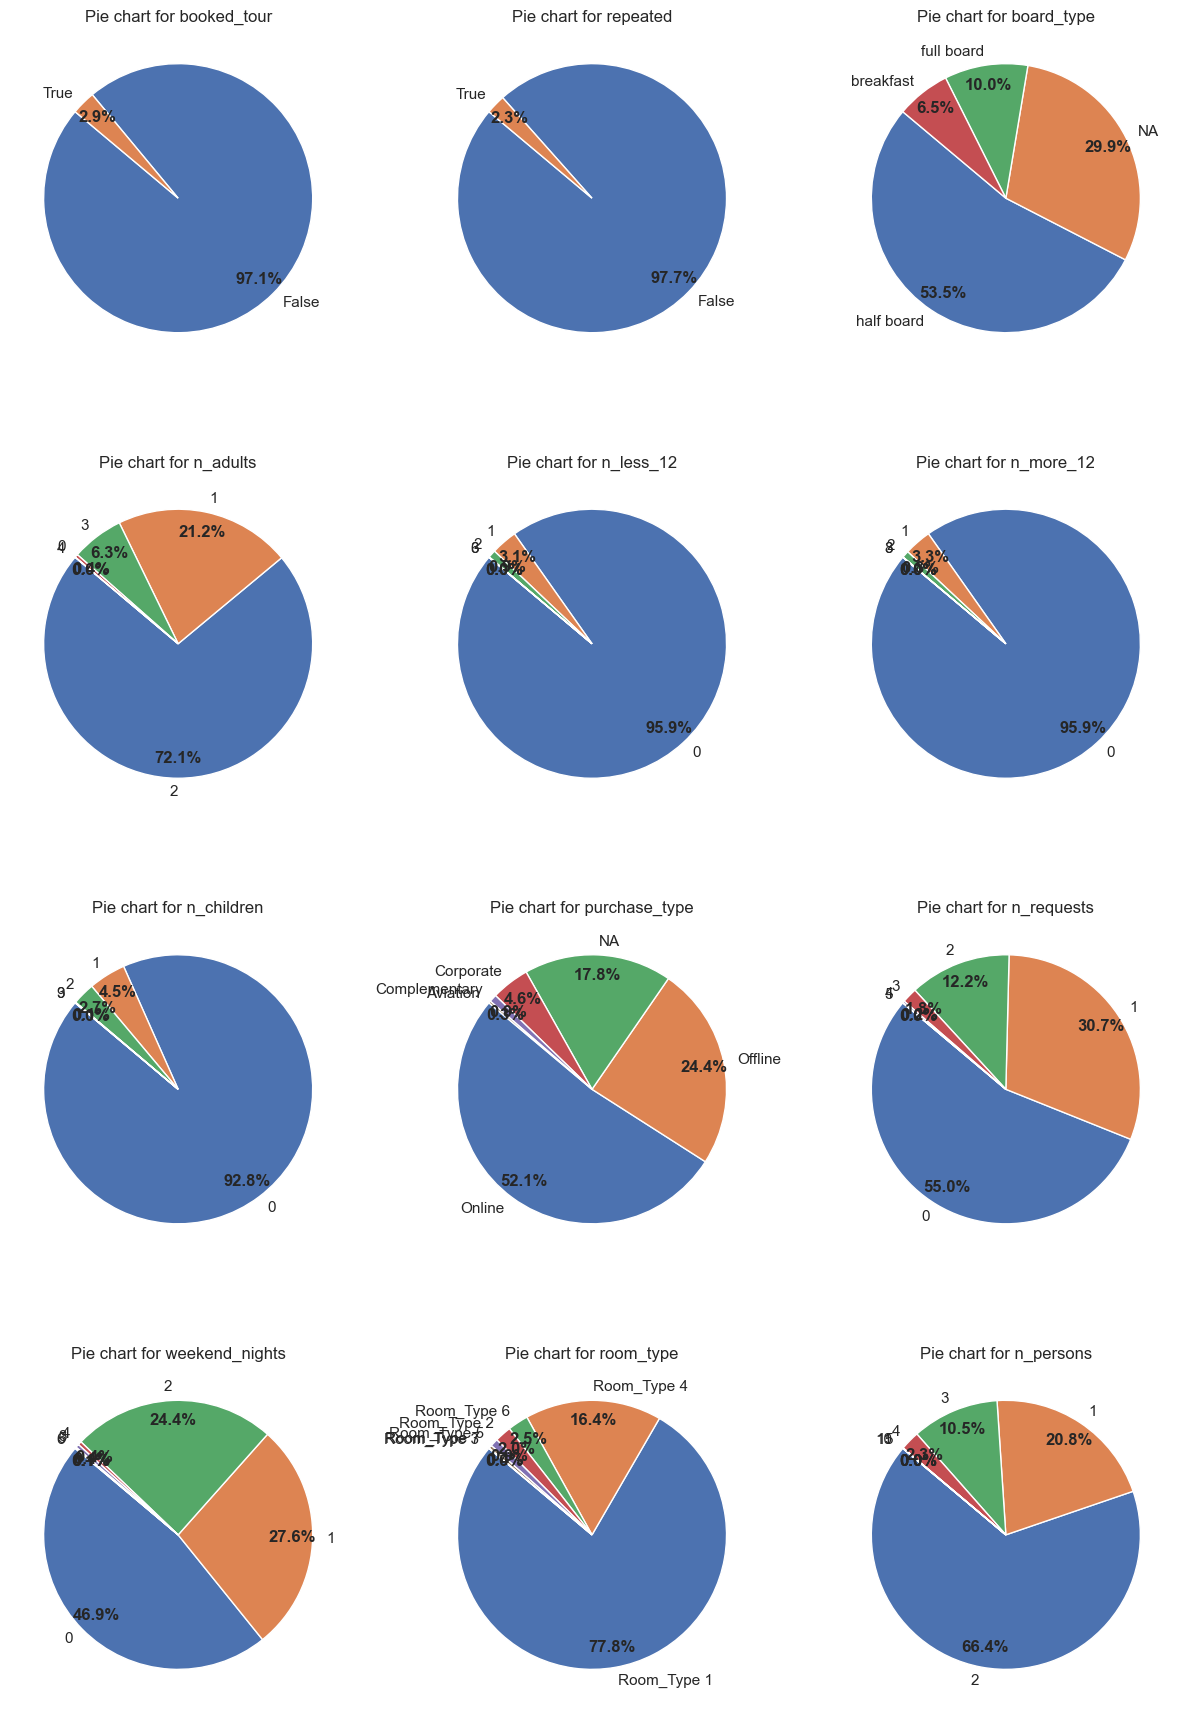

In [138]:
for col in test_hotel_df:
    test_hotel_df[col]=is_boolian_series(test_hotel_df[col])

# sum num of children and num of pearsons 
test_hotel_df['n_children'] = test_hotel_df['n_more_12']+test_hotel_df['n_less_12']
test_hotel_df['n_persons'] = test_hotel_df['n_adults']+test_hotel_df['n_children']

# sum total nights
test_hotel_df['total_nights'] = test_hotel_df['week_nights']+test_hotel_df['weekend_nights']

print('\n')
display(HTML(f'<span style="font-size:15px; color:black; font-weight:bold;">The number of unique values for each attribute:'))
nunique_df = show_nunique_summary(test_hotel_df)
print('')
upto8_unique_vals = nunique_df[nunique_df['Unique Values']<=8]
hotel_df[upto8_unique_vals['Variable']].head()
plot_pie_charts_in_subplots(test_hotel_df[upto8_unique_vals['Variable']])

In [139]:
print(test_hotel_df['n_persons'].unique(),'\n')
print(test_hotel_df['n_children'].unique(),'\n')
print(test_hotel_df[test_hotel_df['n_persons'] == 10])
print(test_hotel_df[test_hotel_df['n_persons'] == 11])


[ 3  1  2  4  5 10 11] 

[1 0 2 3 9] 

            ID  weekend_nights  week_nights    room_type  board_type  \
7560  INN10042               2            1  Room_Type 1  half board   

      n_adults  n_less_12  n_more_12  booked_tour  n_requests  lead_time  \
7560         1          6          3        False           0    14.0000   

     purchase_type  n_p_cacellation  n_p_not_cacellation  repeated    price  \
7560     Corporate                0                    0     False 115.0000   

            date  n_children  n_persons  total_nights  
7560  10/11/2017           9         10             3  
            ID  weekend_nights  week_nights    room_type  board_type  \
8037  INN10062               2            5  Room_Type 2  half board   

      n_adults  n_less_12  n_more_12  booked_tour  n_requests  lead_time  \
8037         2          1          8        False           1    10.0000   

     purchase_type  n_p_cacellation  n_p_not_cacellation  repeated   price  \
8037        Onli

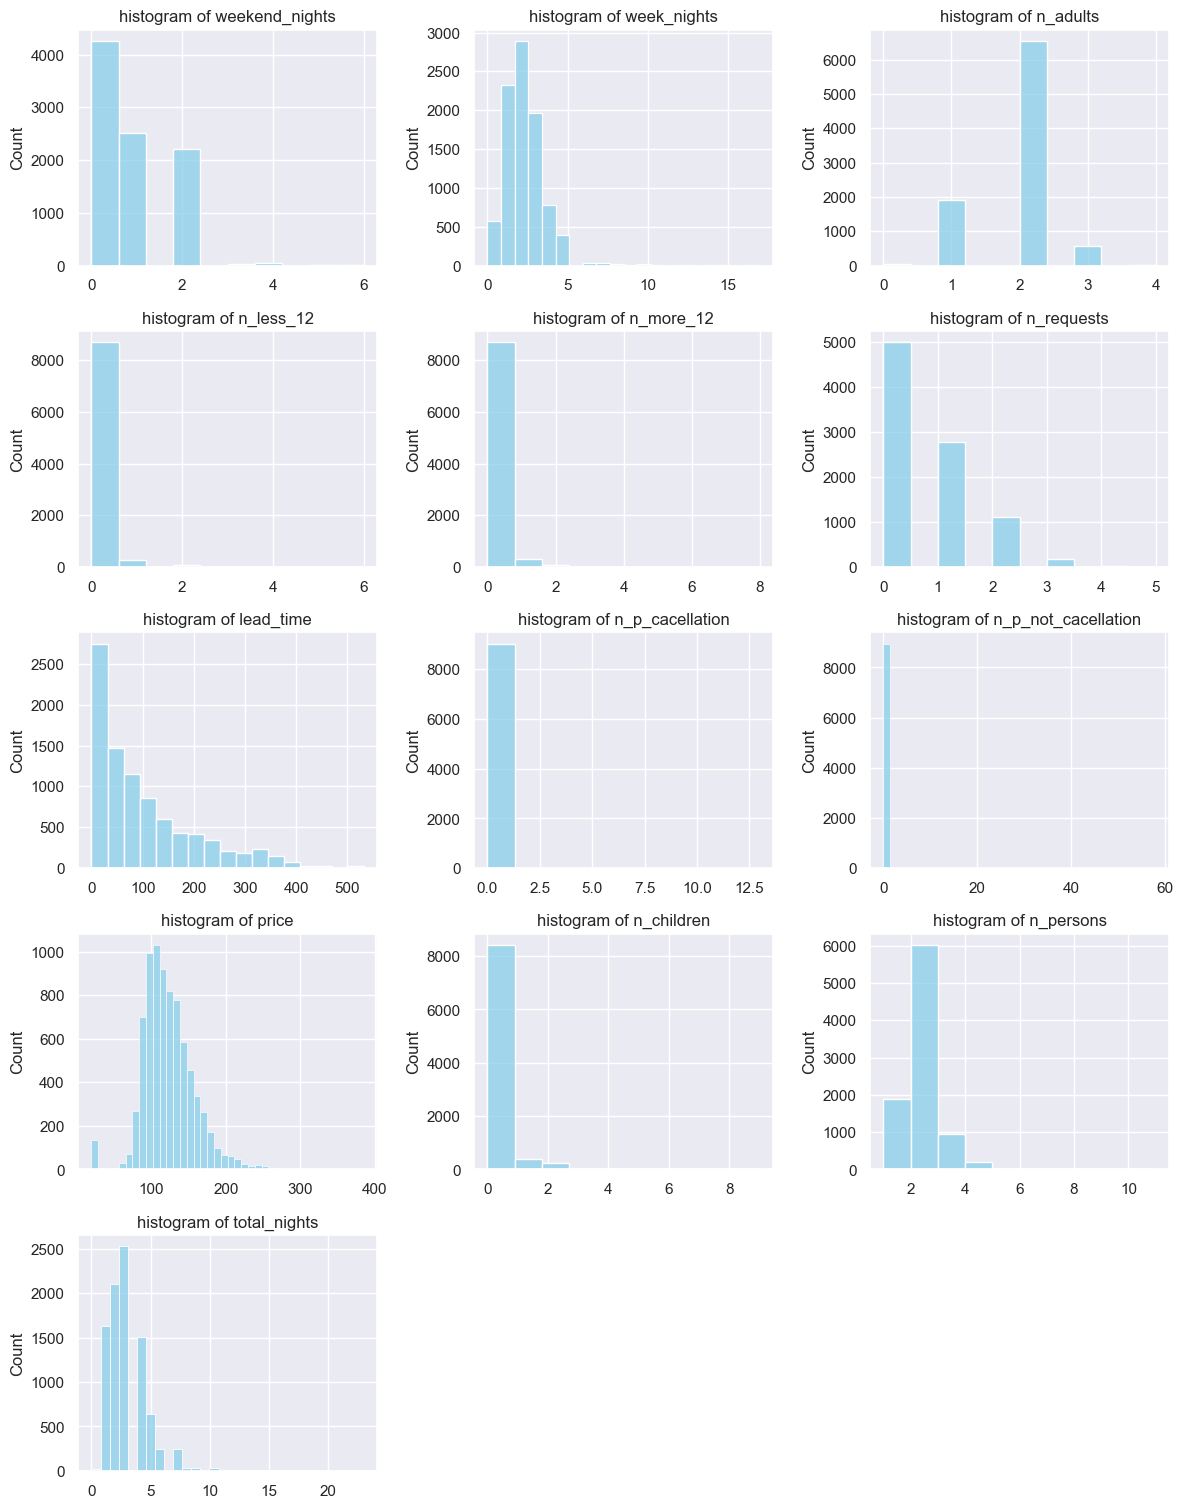

In [140]:
numeric_col = test_hotel_df.describe().columns # to get the numeric column
numerical_hotel_data = test_hotel_df[numeric_col]

plot_histograms_in_subplots(numerical_hotel_data)


In [141]:
# Convert the 'dates' column from string format to datetime format
test_hotel_df['date1'] = pd.to_datetime(test_hotel_df['date'], format='%m/%d/%Y', errors='coerce')
non_date = np.where(test_hotel_df['date1'].isnull())
print(f'number of non-date elements is: {len(non_date[0])}\n')
test_hotel_df.loc[non_date, 'date']

number of non-date elements is: 10



1020    2018-2-29
2177    2018-2-29
2351    2018-2-29
4973    2018-2-29
5679    2018-2-29
6306    2018-2-29
7047    2018-2-29
7336    2018-2-29
7347    2018-2-29
7852    2018-2-29
Name: date, dtype: object

<Axes: xlabel='day', ylabel='Count'>

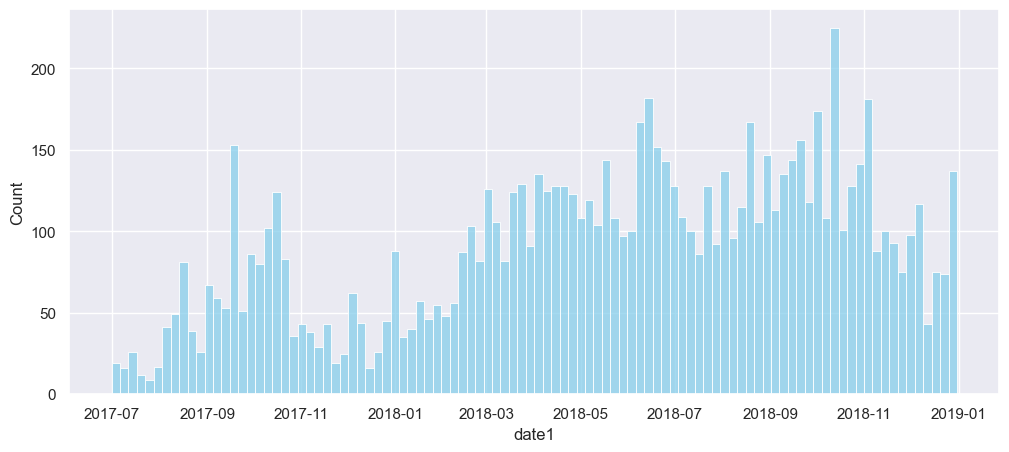

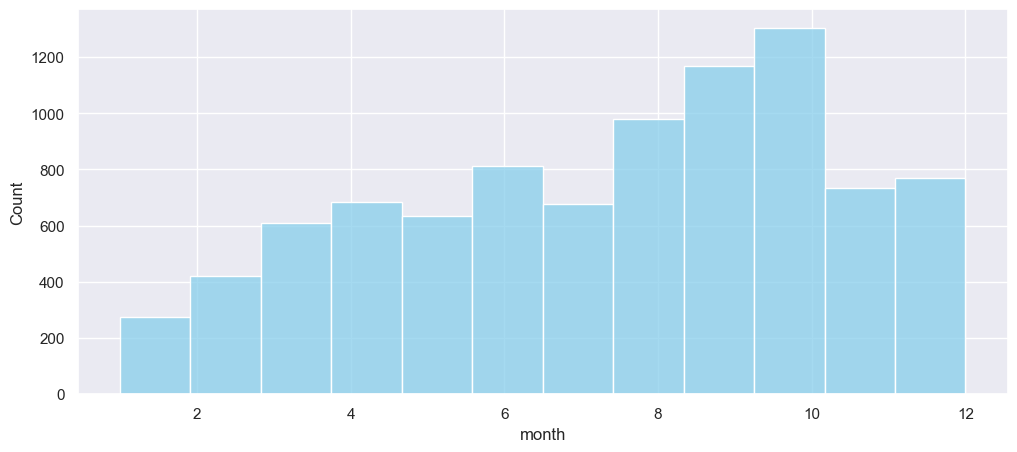

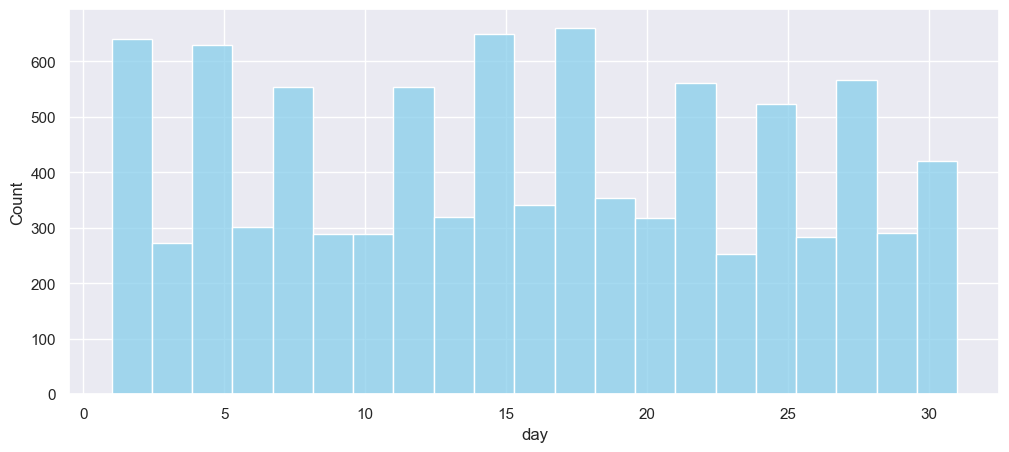

In [142]:
test_hotel_df['date1'] = test_hotel_df['date1'].fillna(pd.to_datetime('03/01/2018', format='%m/%d/%Y'))
fig, axs = plt.subplots(figsize = [12,5])
sns.histplot(test_hotel_df['date1'], bins=100, color='skyblue')
test_hotel_df['month'] = test_hotel_df['date1'].dt.month
test_hotel_df['day'] = test_hotel_df['date1'].dt.day
fig, axs = plt.subplots(figsize = [12,5])
sns.histplot(test_hotel_df['month'], bins=12, color='skyblue')
fig, axs = plt.subplots(figsize = [12,5])
sns.histplot(test_hotel_df['day'], color='skyblue')


### Preproccess
The steps of preprocceing are same to steps in train data. 

In [143]:
test_hotel_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9072 entries, 0 to 9071
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID                   9072 non-null   object        
 1   weekend_nights       9072 non-null   int64         
 2   week_nights          9072 non-null   int64         
 3   room_type            9072 non-null   object        
 4   board_type           6355 non-null   object        
 5   n_adults             9072 non-null   int64         
 6   n_less_12            9072 non-null   int64         
 7   n_more_12            9072 non-null   int64         
 8   booked_tour          9072 non-null   bool          
 9   n_requests           9072 non-null   int64         
 10  lead_time            8947 non-null   float64       
 11  purchase_type        7461 non-null   object        
 12  n_p_cacellation      9072 non-null   int64         
 13  n_p_not_cacellation  9072 non-nul

#### Missing values

First, analize the form of missing values

In [144]:
cols_with_missing_values = ['price', 'lead_time', 'board_type', 'purchase_type']
# Create a boolean DataFrame indicating missing values
missing_df = test_hotel_df[cols_with_missing_values].isna()
n = len(cols_with_missing_values)
missing_count_matrix = np.zeros((n, n), dtype=int)

# Loop over pairs of variables to count simultaneous missing values
for i in range(n):
    for j in range(n):
        # Count rows where both variables have missing values
        missing_count_matrix[i, j] = (missing_df.iloc[:, i] & missing_df.iloc[:, j]).sum()

# Convert the matrix to a DataFrame for easier viewing
missing_count_df = pd.DataFrame(missing_count_matrix, 
                                index=cols_with_missing_values, 
                                columns=cols_with_missing_values)
print('num of missing values for each variable:')
print(missing_df.sum(axis=0))
print('\nsum of pairs of missing values:')
print(missing_count_df)


num of missing values for each variable:
price            1130
lead_time         125
board_type       2717
purchase_type    1611
dtype: int64

sum of pairs of missing values:
               price  lead_time  board_type  purchase_type
price           1130        125        1130           1130
lead_time        125        125         125            125
board_type      1130        125        2717           1611
purchase_type   1130        125        1611           1611


Second, refer to the 'simple' missing values - Those where the missing value can be defined as an independent category.

In [145]:
test_hotel_df.loc[test_hotel_df['board_type'].isna(),'board_type'] = 'missing'
test_hotel_df.loc[test_hotel_df['purchase_type'].isna(),'purchase_type'] = 'missing'


Last, refer to another missing values - in price and in lead_time.

#### simple outliers

In [146]:
# check values seems to be outliers on charts
for colname in upto8_unique_vals['Variable']:
    print('Value count of', colname, ':\n', test_hotel_df[colname].value_counts(),'\n')

# check also n_p_not_cancelation
print('Value count of', 'n_p_not_cacellation', ':\n', test_hotel_df['n_p_not_cacellation'].value_counts(),'\n')

Value count of booked_tour :
 booked_tour
False    8812
True      260
Name: count, dtype: int64 

Value count of repeated :
 repeated
False    8861
True      211
Name: count, dtype: int64 

Value count of board_type :
 board_type
half board    4857
missing       2717
full board     909
breakfast      589
Name: count, dtype: int64 

Value count of n_adults :
 n_adults
2    6545
1    1921
3     569
0      35
4       2
Name: count, dtype: int64 

Value count of n_less_12 :
 n_less_12
0    8699
1     285
2      84
3       3
6       1
Name: count, dtype: int64 

Value count of n_more_12 :
 n_more_12
0    8698
1     295
2      76
3       2
8       1
Name: count, dtype: int64 

Value count of n_children :
 n_children
0    8415
1     405
2     244
3       6
9       2
Name: count, dtype: int64 

Value count of purchase_type :
 purchase_type
Online           4723
Offline          2217
missing          1611
Corporate         416
Complementary      82
Aviation           23
Name: count, dtype: int6


Conclusions:
If you choose a threshold value of 0.2% then you will discover outliers ​​in about ten variables..

In [147]:
# replace outliers with according values
test_hotel_df.loc[test_hotel_df['board_type']=='not selected','board_type'] = 'missing'

# In order to reduce outliers, log transform n_p_not_cacellation and n_p_cacellation
test_hotel_df['log_n_p_cancellation'] = np.int32(np.log2(test_hotel_df['n_p_cacellation']+1))
test_hotel_df['log_n_p_not_cancellation'] = np.int32(np.log2(test_hotel_df['n_p_not_cacellation']+1))
test_hotel_df['log_n_p_not_cancellation'].value_counts()

log_n_p_not_cancellation
0    8889
1      84
2      44
3      30
4      13
5      12
Name: count, dtype: int64

In [151]:
test_hotel_df.loc[test_hotel_df['room_type']=='Room_Type 3','room_type'] = 'Room_Type 1'
new_order = ['Room_Type 1', 'Room_Type 5', 'Room_Type 4', 'Room_Type 2', 'Room_Type 7', 'Room_Type 6'] 
# Apply the new order to the variables
test_hotel_df['room_type'] = pd.Categorical(test_hotel_df['room_type'], categories=new_order, ordered=True)
test_hotel_df['room_type_cat'] = test_hotel_df['room_type'].cat.codes

test_hotel_df.groupby(['room_type','room_type_cat']).size()

C:\Users\Moshe\AppData\Local\Temp\ipykernel_16352\2118588688.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  test_hotel_df.groupby(['room_type','room_type_cat']).size()


room_type    room_type_cat
Room_Type 1  0                7058
             1                   0
             2                   0
             3                   0
             4                   0
             5                   0
Room_Type 5  0                   0
             1                  85
             2                   0
             3                   0
             4                   0
             5                   0
Room_Type 4  0                   0
             1                   0
             2                1488
             3                   0
             4                   0
             5                   0
Room_Type 2  0                   0
             1                   0
             2                   0
             3                 181
             4                   0
             5                   0
Room_Type 7  0                   0
             1                   0
             2                   0
             3              

In [152]:
missing_price_idx = test_hotel_df[test_hotel_df['price'].isna()==True].index
outlier_index = test_hotel_df[test_hotel_df['n_persons']>5].index
test_hotel_df.loc[outlier_index,'n_persons']=5
test_hotel_df.loc[missing_price_idx,'price'] = test_hotel_df.loc[missing_price_idx].apply(lambda row: fill_price(
    mean_price_pivot_table[row['n_persons']][row['room_type']],
    std_price_pivot_table[row['n_persons']][row['room_type']]) ,axis=1)
missing_price_idx = test_hotel_df[test_hotel_df['price'].isna()==True].index
missing_price_idx

Index([], dtype='int64')

In [154]:
lead_time_data = test_hotel_df.loc[test_hotel_df['lead_time'].isna()==False,'lead_time']
# Fit an exponential distribution to the data
loc, scale = expon.fit(lead_time_data)
print(loc,scale)
locs.append(loc)
scales.append(scale)

missing_lead_time_idx = test_hotel_df[test_hotel_df['lead_time'].isna()==True].index
test_hotel_df.loc[missing_lead_time_idx,'lead_time'] = test_hotel_df.loc[missing_lead_time_idx].apply(lambda row: fill_lead_time(locs,scales,0),axis=1)
missing_lead_time_idx = test_hotel_df[test_hotel_df['lead_time'].isna()==True].index
missing_lead_time_idx

0.0 101.70124063932045


Index([], dtype='int64')

check if there are minus values of price and lead time

In [155]:
print(np.where(test_hotel_df['price']<0))
print(np.where(test_hotel_df['lead_time']<0))

(array([], dtype=int64),)
(array([], dtype=int64),)


#### New features
We can create a new feature for family size which combines Parch (parents/children's) and SibSp (siblings/spouses). This will enable us to drop Parch and SibSp from our datasets.

In [156]:
test_hotel_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9072 entries, 0 to 9071
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   ID                        9072 non-null   object        
 1   weekend_nights            9072 non-null   int64         
 2   week_nights               9072 non-null   int64         
 3   room_type                 9072 non-null   category      
 4   board_type                9072 non-null   object        
 5   n_adults                  9072 non-null   int64         
 6   n_less_12                 9072 non-null   int64         
 7   n_more_12                 9072 non-null   int64         
 8   booked_tour               9072 non-null   bool          
 9   n_requests                9072 non-null   int64         
 10  lead_time                 9072 non-null   float64       
 11  purchase_type             9072 non-null   object        
 12  n_p_cacellation     

##### children

In [157]:
test_hotel_df['With_children'] = 0
test_hotel_df.loc[test_hotel_df['n_children']>0, 'With_children'] = 1
test_hotel_df.groupby(['n_children','With_children']).size()

n_children  With_children
0           0                8415
1           1                 405
2           1                 244
3           1                   6
9           1                   2
dtype: int64

In [158]:
print(test_hotel_df['n_adults'].value_counts(),'\n')
print(test_hotel_df['n_persons'].value_counts(),'\n')


n_adults
2    6545
1    1921
3     569
0      35
4       2
Name: count, dtype: int64 

n_persons
2    6020
1    1887
3     949
4     210
5       6
Name: count, dtype: int64 



In [159]:
test_hotel_df['n_adults_cat'] = test_hotel_df['n_adults']
test_hotel_df.loc[test_hotel_df['n_adults'] >2,'n_adults_cat'] = 3
test_hotel_df['n_persons_cat'] = test_hotel_df['n_persons']
test_hotel_df.loc[test_hotel_df['n_persons'] >3,'n_persons_cat'] = 4
print(test_hotel_df['n_adults_cat'].value_counts(),'\n')
print(test_hotel_df['n_persons_cat'].value_counts(),'\n')


n_adults_cat
2    6545
1    1921
3     571
0      35
Name: count, dtype: int64 

n_persons_cat
2    6020
1    1887
3     949
4     216
Name: count, dtype: int64 



##### season

as we have see, the cancellation rate is bigger in summer and smaller in winter. Those, create categorical variable accordingly

In [160]:
# Function to classify seasons based on dates
def classify_season(date, type = 'obj'):
    month = date.month
    day = date.day

    if (month == 12 or month == 1 or month == 2):
        if type == 'cat':
            season = 0
        else:
            season = 'Winter'
    elif (month == 6 or month == 7 or month == 8):
        if type == 'cat':
            season = 2
        else:
            season = 'Summer'        
    else:
        if type == 'cat':
            season = 1
        else:
            season = 'Else'
    return season

# Apply the function to the 'date1' column and create a new column 'season'
test_hotel_df['season'] = test_hotel_df.apply(lambda row: classify_season(row['date1'],'obj'),axis = 1)
test_hotel_df['season_cat'] =test_hotel_df.apply(lambda row: classify_season(row['date1'],'cat'),axis = 1)

# Check the result
print(test_hotel_df[['date1', 'season']].tail(15))


          date1  season
9057 2017-10-14    Else
9058 2018-11-23    Else
9059 2018-12-16  Winter
9060 2018-07-04  Summer
9061 2018-06-30  Summer
9062 2018-10-13    Else
9063 2018-11-01    Else
9064 2017-09-13    Else
9065 2018-12-31  Winter
9066 2018-06-02  Summer
9067 2018-09-21    Else
9068 2017-09-15    Else
9069 2018-05-04    Else
9070 2018-08-20  Summer
9071 2018-06-02  Summer


##### nights

In [161]:
print(test_hotel_df['week_nights'].value_counts(),'\n')
print(test_hotel_df['weekend_nights'].value_counts(),'\n')
print(test_hotel_df['total_nights'].value_counts(),'\n')


week_nights
2     2890
1     2330
3     1967
4      783
0      575
5      397
6       37
7       29
10      21
8       17
9       10
11       6
15       4
14       3
12       2
17       1
Name: count, dtype: int64 

weekend_nights
0    4255
1    2508
2    2215
4      40
3      38
5      11
6       5
Name: count, dtype: int64 

total_nights
3     2530
2     2100
1     1635
4     1503
5      641
7      250
6      246
8       34
10      29
9       29
0       19
15      12
14      10
12       9
11       9
13       5
20       3
19       2
16       2
21       2
17       1
23       1
Name: count, dtype: int64 



In [162]:
test_hotel_df['week_nights_cat'] = test_hotel_df['week_nights']
test_hotel_df.loc[test_hotel_df['week_nights'] >5,'week_nights_cat'] = 6
test_hotel_df['week_nights_cat'].value_counts()

week_nights_cat
2    2890
1    2330
3    1967
4     783
0     575
5     397
6     130
Name: count, dtype: int64

In [163]:
test_hotel_df['weekend_nights_cat'] = test_hotel_df['weekend_nights']
test_hotel_df.loc[test_hotel_df['weekend_nights'] >2,'weekend_nights_cat'] = 3
test_hotel_df['weekend_nights_cat'].value_counts()

weekend_nights_cat
0    4255
1    2508
2    2215
3      94
Name: count, dtype: int64

In [164]:
test_hotel_df['total_nights_cat'] = test_hotel_df['total_nights']
test_hotel_df.loc[test_hotel_df['total_nights'] >5,'total_nights_cat'] = 6
test_hotel_df['total_nights_cat'].value_counts()

total_nights_cat
3    2530
2    2100
1    1635
4    1503
6     644
5     641
0      19
Name: count, dtype: int64

##### category and more

In [165]:
test_hotel_df['board_type_cat'] = test_hotel_df['board_type'].astype('category').cat.codes
print(test_hotel_df.groupby(['board_type','board_type_cat']).size(),'\n')
test_hotel_df['purchase_type_cat'] = test_hotel_df['purchase_type'].astype('category').cat.codes
test_hotel_df.groupby(['purchase_type','purchase_type_cat']).size()

board_type  board_type_cat
breakfast   0                  589
full board  1                  909
half board  2                 4857
missing     3                 2717
dtype: int64 



purchase_type  purchase_type_cat
Aviation       0                      23
Complementary  1                      82
Corporate      2                     416
Offline        3                    2217
Online         4                    4723
missing        5                    1611
dtype: int64

In [166]:
test_hotel_df['n_requests'].value_counts()

n_requests
0    4994
1    2783
2    1107
3     165
4      22
5       1
Name: count, dtype: int64

In [167]:
test_hotel_df['n_requests_cat'] = test_hotel_df['n_requests']
test_hotel_df.loc[test_hotel_df['n_requests']>3, 'n_requests_cat'] = 3
test_hotel_df['n_requests_cat'].value_counts()

n_requests_cat
0    4994
1    2783
2    1107
3     188
Name: count, dtype: int64

#### Discretization

##### price

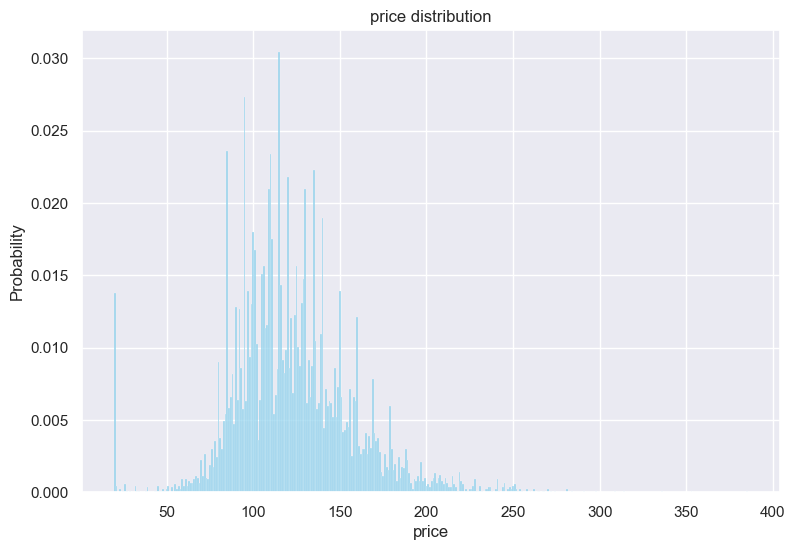

In [168]:
sns.histplot(data=test_hotel_df, x='price', color='skyblue', stat="probability", discrete=True)
plt.title('price distribution')
plt.xlabel('price')
plt.ylabel('Probability')
plt.show()

In [169]:
N = 9
test_hotel_df['price_bin'] = pd.cut(test_hotel_df['price'], bins=N, labels=False, include_lowest=True, right=False)

test_hotel_df['price_bin'].value_counts().sort_index()

price_bin
0     194
1    2283
2    4423
3    1720
4     350
5      84
6      13
7       3
8       2
Name: count, dtype: int64

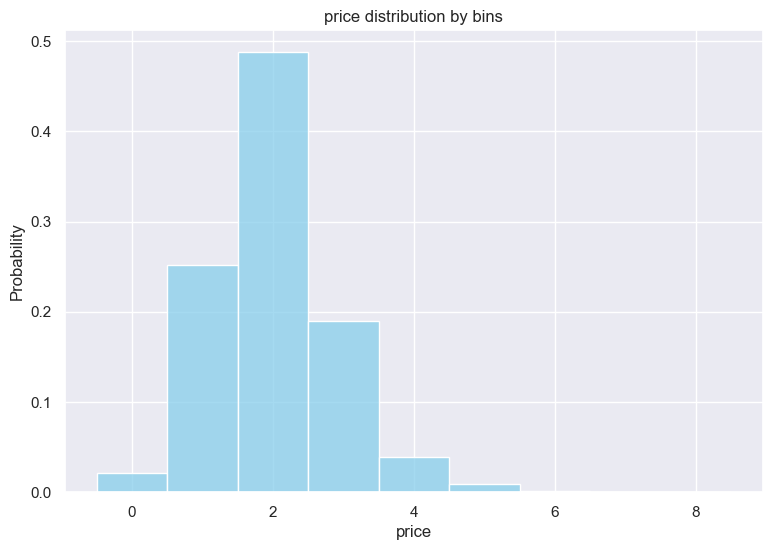

In [170]:
sns.histplot(data=test_hotel_df, x='price_bin', color='skyblue', stat="probability", discrete=True)
plt.title('price distribution by bins')
plt.xlabel('price')
plt.ylabel('Probability')
plt.show()

In [177]:
N = 5
hotel_df['price_bin_2'] = pd.qcut(hotel_df['price'], q=N, labels=False, duplicates='drop')

bins = pd.qcut(hotel_df['price'], q=N, duplicates='drop')
bin_ranges = bins.unique()
for i, bin_range in enumerate(sorted(bin_ranges)):
    print(f"Bin {i}: {bin_range.left} to {bin_range.right}")

for index in test_hotel_df.index:
    price = test_hotel_df.loc[index, 'price']
    for i, bin_range in enumerate(sorted(bin_ranges)):
        if bin_range.left <= price <= bin_range.right:
            price_bin = i
    if price<20:
        price_bin = 0
    if price> 500:
        price_bin = 4
    test_hotel_df.loc[index, 'price_bin_2'] = price_bin


C:\Users\Moshe\AppData\Local\Temp\ipykernel_16352\872456230.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hotel_df['price_bin_2'] = pd.qcut(hotel_df['price'], q=N, labels=False, duplicates='drop')


Bin 0: 2.165 to 96.5
Bin 1: 96.5 to 111.583
Bin 2: 111.583 to 128.0
Bin 3: 128.0 to 148.856
Bin 4: 148.856 to 560.0


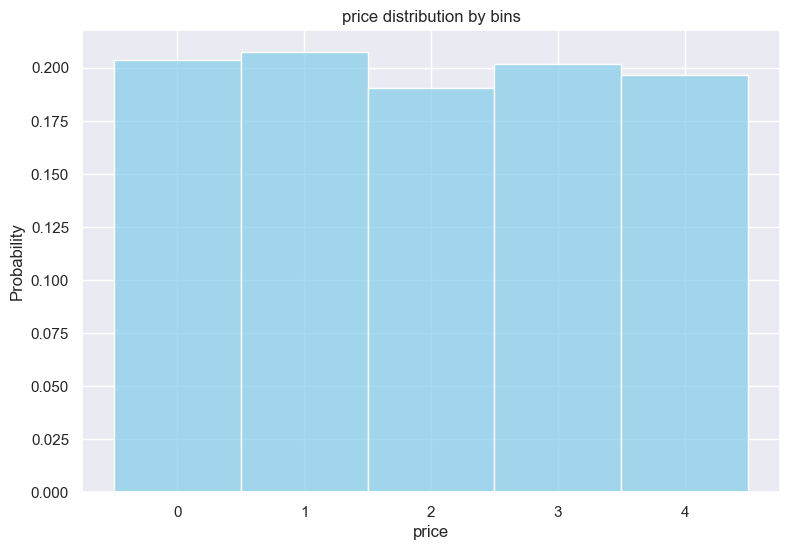

In [178]:
sns.histplot(data=test_hotel_df, x='price_bin_2', color='skyblue', stat="probability", discrete=True)
plt.title('price distribution by bins')
plt.xlabel('price')
plt.ylabel('Probability')
plt.show()

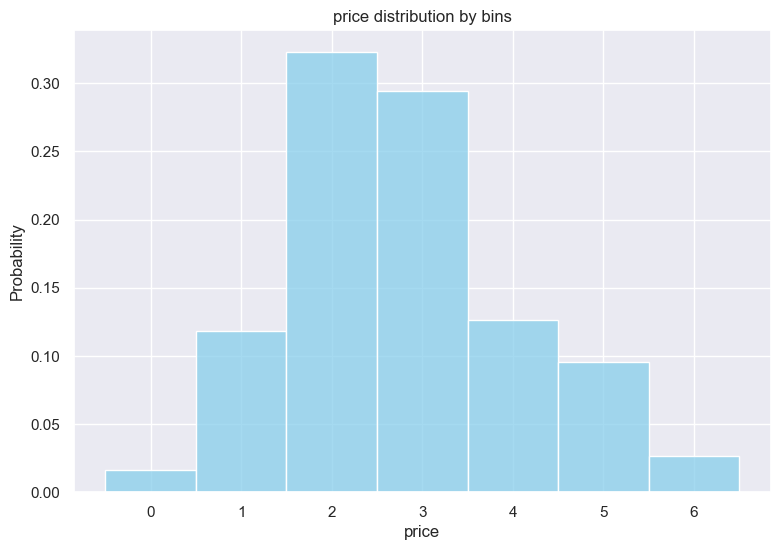

price_bin_3
0     149
1    1075
2    2928
3    2670
4    1143
5     865
6     242
Name: count, dtype: int64

In [179]:
# resonable bins - after observation on the probability graph
bins = [0, 40, 90, 115, 140, 160, 200, float('inf')]
test_hotel_df['price_bin_3'] = pd.cut(test_hotel_df['price'], bins=bins, labels=False, include_lowest=True)
sns.histplot(data=test_hotel_df, x='price_bin_3', color='skyblue', stat="probability", discrete=True)
plt.title('price distribution by bins')
plt.xlabel('price')
plt.ylabel('Probability')
plt.show()
test_hotel_df['price_bin_3'].value_counts().sort_index()

##### lead time

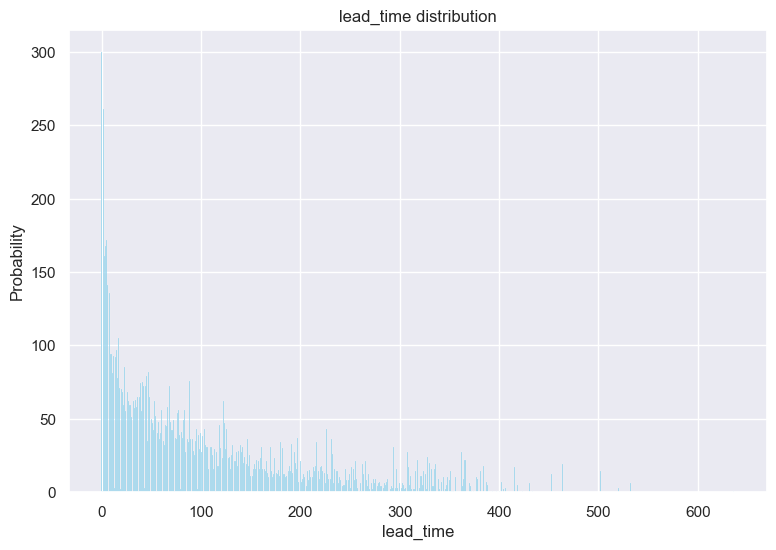

In [180]:
sns.histplot(data=test_hotel_df, x='lead_time', color='skyblue', stat="frequency", discrete=True)
plt.title('lead_time distribution')
plt.xlabel('lead_time')
plt.ylabel('Probability')
plt.show()

log_lead_time
11    1241
10    1084
12    1065
9      971
13     925
14     637
8      606
7      515
6      444
3      328
5      325
4      314
0      300
2      261
15      55
1        1
Name: count, dtype: int64
log base: 1.5


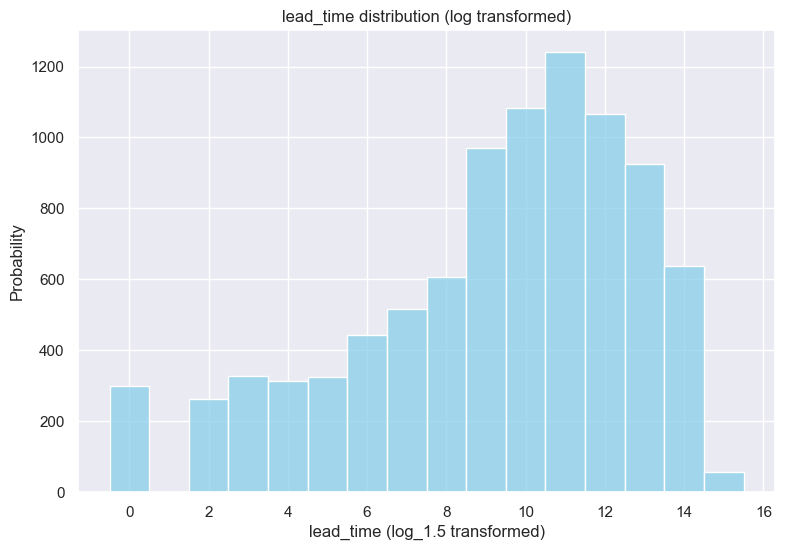

In [181]:
base = 1.5
test_hotel_df['log_lead_time'] = np.int32(np.emath.logn(base, test_hotel_df['lead_time']+1))
print(test_hotel_df['log_lead_time'].value_counts())
print("log base:", base)

sns.histplot(data=test_hotel_df, x='log_lead_time', color='skyblue', stat="frequency", discrete=True)
plt.title('lead_time distribution (log transformed)')
plt.xlabel(f'lead_time (log_{base} transformed)')
plt.ylabel('Probability')
plt.show()



the value 'log_lead_time'=9 is outlier. fix it:

In [182]:
test_hotel_df['lead_time_cat'] = test_hotel_df['log_lead_time']
test_hotel_df.loc[test_hotel_df['log_lead_time'] == 16, 'lead_time_cat'] = 15
test_hotel_df.loc[test_hotel_df['log_lead_time'] == 1, 'lead_time_cat'] = 0

In [187]:
N = 10
hotel_df['lead_time_cat_2'] = pd.qcut(hotel_df['lead_time'], q=N, labels=False, duplicates='drop')

# Print the range of each bin
bins = pd.qcut(hotel_df['lead_time'], q=N, duplicates='drop')
bin_ranges = bins.unique()
for i, bin_range in enumerate(sorted(bin_ranges)):
    print(f"Bin {i}: {bin_range.left} to {bin_range.right}")

for index in test_hotel_df.index:
    lead_time = test_hotel_df.loc[index, 'lead_time']
    for i, bin_range in enumerate(sorted(bin_ranges)):
        if bin_range.left <= lead_time <= bin_range.right:
            lead_time_bin = i
    if lead_time> 600:
        lead_time_bin = 9
    test_hotel_df.loc[index, 'lead_time_cat_2'] = lead_time_bin

C:\Users\Moshe\AppData\Local\Temp\ipykernel_16352\1839801958.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hotel_df['lead_time_cat_2'] = pd.qcut(hotel_df['lead_time'], q=N, labels=False, duplicates='drop')


Bin 0: -0.001 to 4.0
Bin 1: 4.0 to 14.0
Bin 2: 14.0 to 29.0
Bin 3: 29.0 to 47.0
Bin 4: 47.0 to 69.0
Bin 5: 69.0 to 96.0
Bin 6: 96.0 to 131.0
Bin 7: 131.0 to 182.0
Bin 8: 182.0 to 256.0
Bin 9: 256.0 to 813.471


Text(0.5, 1.0, 'Spearman correlation')

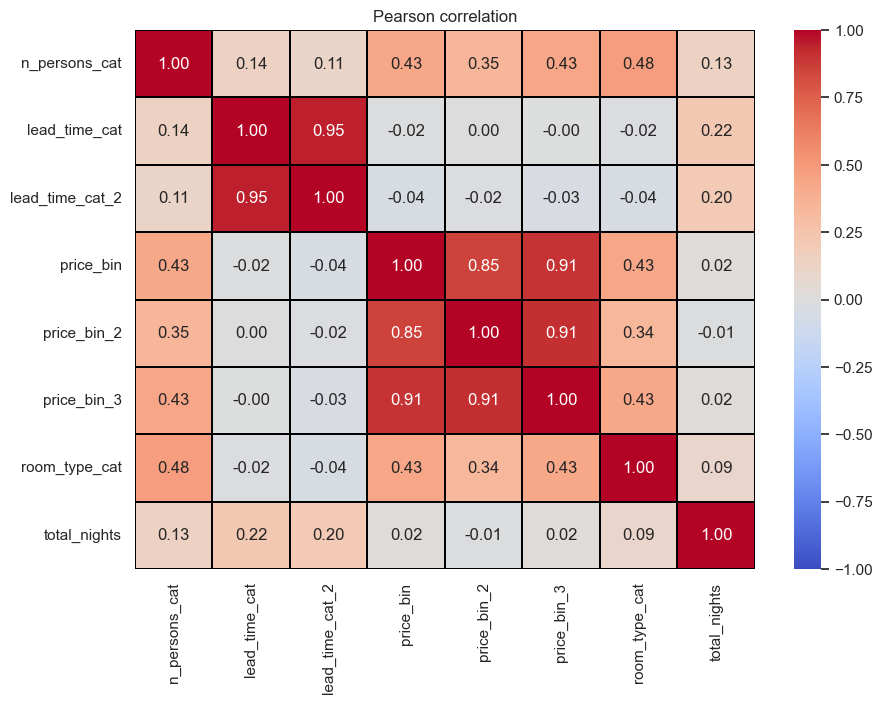

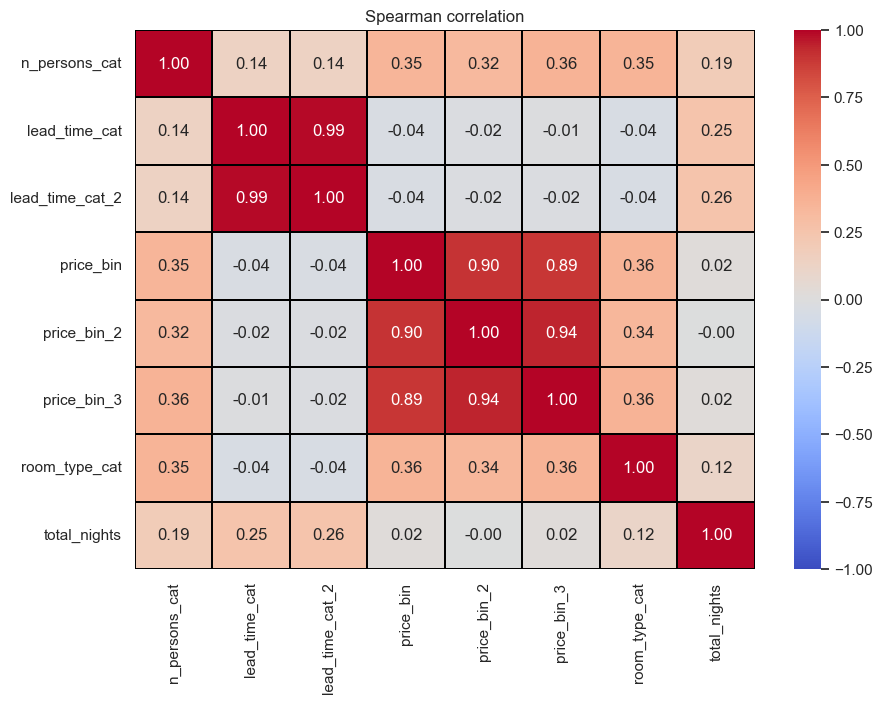

In [188]:
# mini heatmap
cat_columns = ['n_persons_cat',
       'lead_time_cat', 'lead_time_cat_2', 'price_bin', 'price_bin_2', 'price_bin_3', 'room_type_cat', 'total_nights'] 

display(HTML(f'<span style="font-size:24px; color:black; font-weight:bold;">Heatmap of meaning correlated variables:'))
f, ax = plt.subplots(figsize=(10, 7))
ax = sns.heatmap(test_hotel_df[cat_columns].corr(method = 'pearson'), annot = True, vmin=-1, vmax=1, center= 0,
            cmap= 'coolwarm', linewidths=0.2, fmt='.2f', linecolor='black')
ax.set_title('Pearson correlation')
f, ax = plt.subplots(figsize=(10, 7))
ax = sns.heatmap(test_hotel_df[cat_columns].corr(method = 'spearman'), annot = True, vmin=-1, vmax=1, center= 0,
            cmap= 'coolwarm', linewidths=0.2, fmt='.2f', linecolor='black')
ax.set_title('Spearman correlation')


### Prediction and results


#### choose same columns as in model training


In [268]:
columns_for_decition_tree = ['room_type_cat', 'With_children',
       'n_adults_cat', 'n_persons_cat', 'season_cat',
       'week_nights_cat', 'weekend_nights_cat', 'total_nights_cat', 'month', 'day', 
       'price_bin_2', 'price_bin_3', 'lead_time_cat',
       'booked_tour', 'n_requests_cat',
       'board_type_cat', 'purchase_type_cat', 'log_n_p_cancellation',
       'log_n_p_not_cancellation', 'repeated']

test_hotel_df['price_bin_2'] = test_hotel_df['price_bin_2'].astype(int)

In [269]:
X_test_data = test_hotel_df[columns_for_decition_tree]
dummies_col = []
for col in test_hotel_df[columns_for_decition_tree]:
    unique_values = len(hotel_df[col].unique())
    if 2 < unique_values < 8 :
        dummies_col.append(col)

X_dummies = pd.get_dummies(data=X_test_data, columns=dummies_col).astype(float)

X_dummies.head()
len(X_dummies)

9072

In [270]:

y_test_data = best_model.predict(X_dummies)

results = pd.read_csv("hotels_test.csv")
results['is_canceled'] = y_test_data
test_hotel_df['is_canceled'] = y_test_data


#### Show correlations between variables and the target

In [223]:
cat_columns = ['weekend_nights', 'week_nights', 'total_nights', 'n_persons', 'n_children',
       'n_adults', 'n_less_12', 'n_more_12', 'month', 'day', 'booked_tour', 'n_requests',
       'log_n_p_cancellation', 'log_n_p_not_cancellation',
       'repeated','lead_time',  'price', 'room_type_cat', 'is_canceled'] 
test_hotel_df[cat_columns].corr(method = 'pearson')

weekend_nights  week_nights  total_nights  \
weekend_nights                    1.0000       0.2001        0.6374   
week_nights                       0.2001       1.0000        0.8825   
total_nights                      0.6374       0.8825        1.0000   
n_persons                         0.0979       0.1093        0.1329   
n_children                        0.0383       0.0389        0.0490   
n_adults                          0.0942       0.1062        0.1287   
n_less_12                         0.0339       0.0131        0.0266   
n_more_12                         0.0240       0.0456        0.0474   
month                            -0.0073       0.0359        0.0248   
day                               0.0242      -0.0030        0.0093   
booked_tour                      -0.0243      -0.0382       -0.0417   
n_requests                        0.0596       0.0465        0.0652   
log_n_p_cancellation             -0.0204      -0.0470       -0.0468   
log_n_p_not_cancellation         -0.0394      -0.0868       -0.0871   
repeated                         -0.0508      -0.0979       -0.1014   
lead_time                         0.0460       0.1467        0.1375   
price                            -0.0141       0.0364        0.0219   
room_type_cat                     0.0490       0.0894        0.0939   
is_canceled                       0.0604       0.0870        0.0974   

                          n_persons  n_children  n_adults  n_less_12  \
weekend_nights               0.0979      0.0383    0.0942     0.0339   
week_nights                  0.1093      0.0389    0.1062     0.0131   
total_nights                 0.1329      0.0490    0.1287     0.0266   
n_persons                    1.0000      0.5768    0.7943     0.4445   
n_children                   0.5768      1.0000   -0.0230     0.7555   
n_adults                     0.7943     -0.0230    1.0000    -0.0173   
n_less_12                    0.4445      0.7555   -0.0173     1.0000   
n_more_12                    0.4265      0.7545   -0.0174     0.1400   
month                        0.0106      0.0001    0.0141    -0.0037   
day                          0.0323      0.0242    0.0200     0.0291   
booked_tour                  0.0303      0.0233    0.0187     0.0284   
n_requests                   0.2255      0.1100    0.1921     0.0762   
log_n_p_cancellation        -0.0768     -0.0203   -0.0792    -0.0167   
log_n_p_not_cancellation    -0.1390     -0.0269   -0.1511    -0.0235   
repeated                    -0.1584     -0.0352   -0.1687    -0.0295   
lead_time                    0.0563     -0.0377    0.0974    -0.0279   
price                        0.4376      0.3322    0.2786     0.2663   
room_type_cat                0.4788      0.4813    0.2155     0.3782   
is_canceled                  0.1229      0.0393    0.1196     0.0305   

                          n_more_12   month     day  booked_tour  n_requests  \
weekend_nights               0.0240 -0.0073  0.0242      -0.0243      0.0596   
week_nights                  0.0456  0.0359 -0.0030      -0.0382      0.0465   
total_nights                 0.0474  0.0248  0.0093      -0.0417      0.0652   
n_persons                    0.4265  0.0106  0.0323       0.0303      0.2255   
n_children                   0.7545  0.0001  0.0242       0.0233      0.1100   
n_adults                    -0.0174  0.0141  0.0200       0.0187      0.1921   
n_less_12                    0.1400 -0.0037  0.0291       0.0284      0.0762   
n_more_12                    1.0000  0.0038  0.0074       0.0068      0.0900   
month                        0.0038  1.0000 -0.0517      -0.0084      0.1142   
day                          0.0074 -0.0517  1.0000      -0.0034      0.0154   
booked_tour                  0.0068 -0.0084 -0.0034       1.0000      0.0771   
n_requests                   0.0900  0.1142  0.0154       0.0771      1.0000   
log_n_p_cancellation        -0.0139 -0.0301 -0.0135       0.0479     -0.0204   
log_n_p_not_cancellation    -0.0171 -0.0194 

Text(0.5, 1.0, 'Spearman correlation')

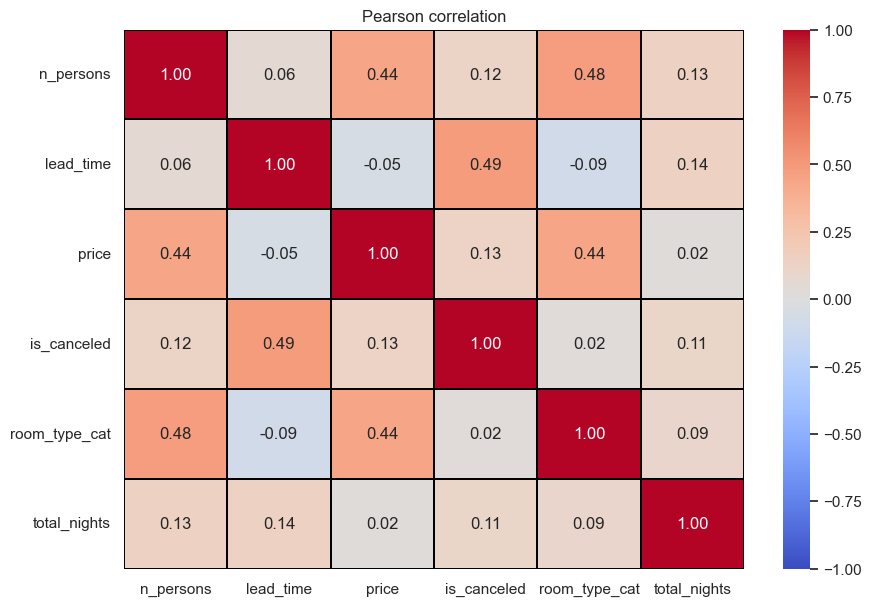

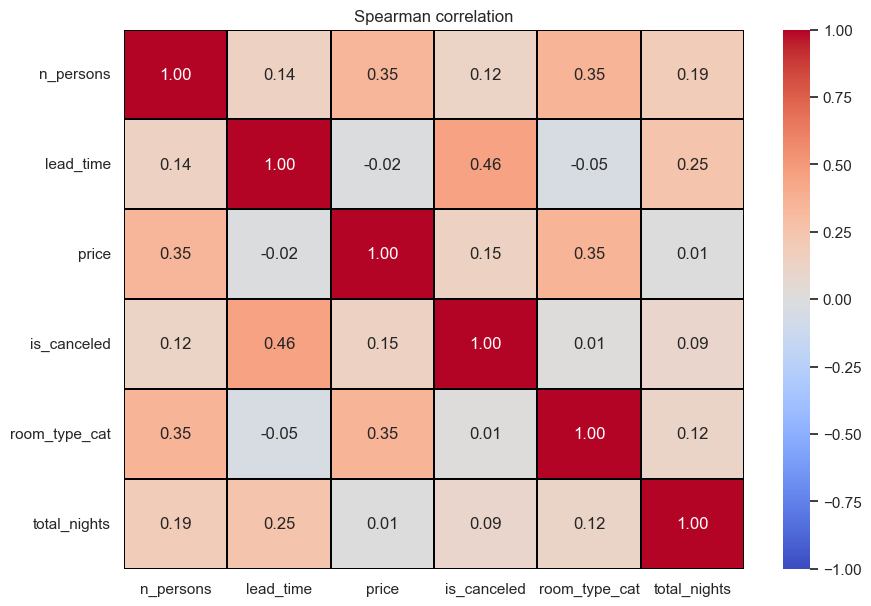

In [271]:
display(HTML(f'<span style="font-size:24px; color:black; font-weight:bold;">Pearson and spearman correlation map between numerical/ordinal variables:'))
f, ax = plt.subplots(figsize=(10, 7))
ax = sns.heatmap(test_hotel_df[cat_columns].corr(method = 'pearson'), annot = True, vmin=-1, vmax=1, center= 0,
            cmap= 'coolwarm', linewidths=0.2, fmt='.2f', linecolor='black')
ax.set_title('Pearson correlation')
f, ax = plt.subplots(figsize=(10, 7))
ax = sns.heatmap(test_hotel_df[cat_columns].corr(method = 'spearman'), annot = True, vmin=-1, vmax=1, center= 0,
            cmap= 'coolwarm', linewidths=0.2, fmt='.2f', linecolor='black')
ax.set_title('Spearman correlation')


Text(0.5, 1.0, 'Spearman correlation')

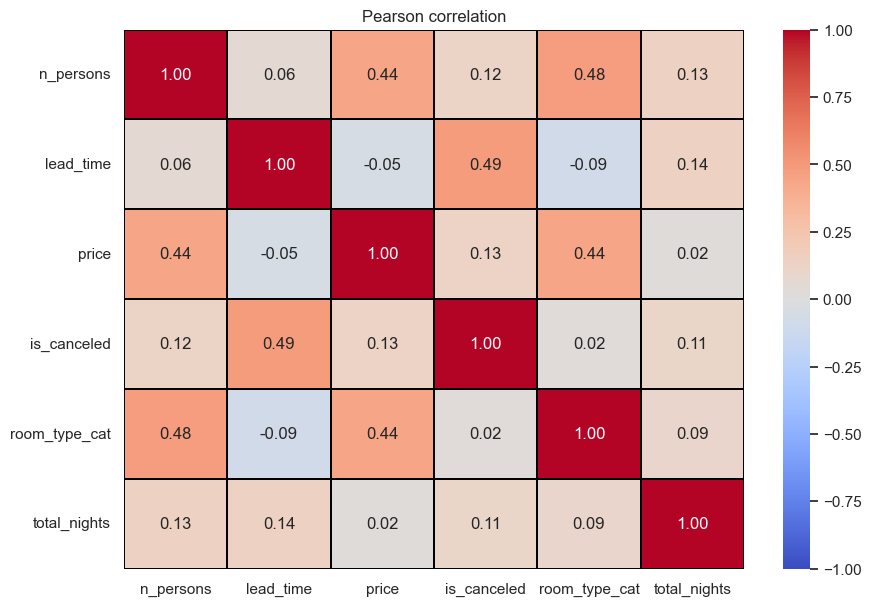

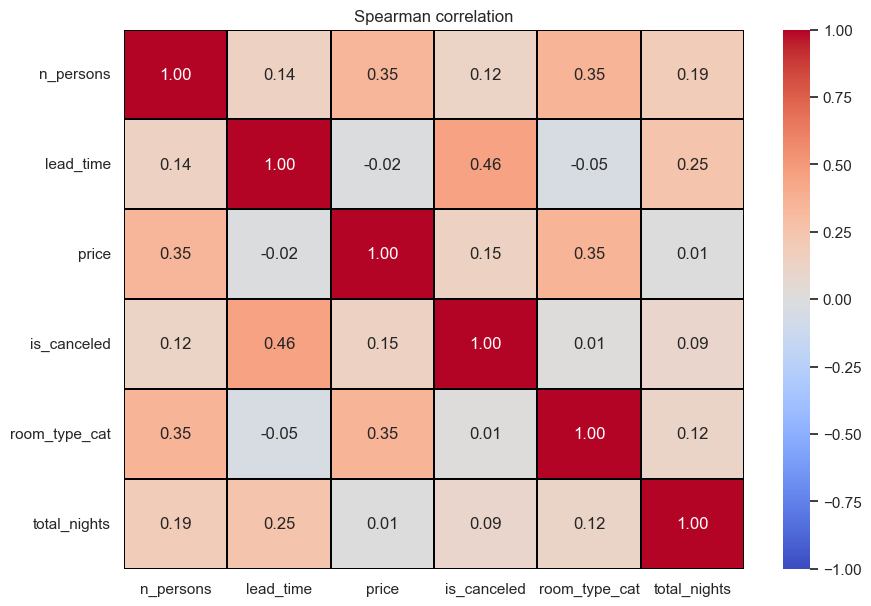

In [272]:
# mini heatmap
cat_columns = ['n_persons',
       'lead_time', 'price', 'is_canceled', 'room_type_cat', 'total_nights'] 

display(HTML(f'<span style="font-size:24px; color:black; font-weight:bold;">Heatmap of meaning correlated variables:'))
f, ax = plt.subplots(figsize=(10, 7))
ax = sns.heatmap(test_hotel_df[cat_columns].corr(method = 'pearson'), annot = True, vmin=-1, vmax=1, center= 0,
            cmap= 'coolwarm', linewidths=0.2, fmt='.2f', linecolor='black')
ax.set_title('Pearson correlation')
f, ax = plt.subplots(figsize=(10, 7))
ax = sns.heatmap(test_hotel_df[cat_columns].corr(method = 'spearman'), annot = True, vmin=-1, vmax=1, center= 0,
            cmap= 'coolwarm', linewidths=0.2, fmt='.2f', linecolor='black')
ax.set_title('Spearman correlation')


#### save relults

In [273]:
results.to_csv("results.csv", index=False)